

# Taiwan endophyte analysis

We will use our combined biom table of leaf and wood endophytes to ask some landscape level ecological questions about both leaf- and sapwood-inhabiting endophytes.

<a id='contents'></a>

## Contents

[Importing biom table and setup](#import)  

[Controls](#c)
* [Negative control](#nc)  
* [Single species](#sing)
* [Mock community](#MC)  
* [Clean-up using controls](#clean)

[Variance Stabilization of Read Counts](#deseq)  

[NMS/Permanova Ordinations](#Ords)
* [Wood vs Leaf libraries](#WvsL)
    + [Entire library comparison](#WvsL)
    + [Shared species only comparison](#shareWvsL)

* [Host](#hostord)
    + [Wood](#hostord)
    + [Leaf](#leafhost)
* [Other environmental variables](#otherperms)
    + [Wood](#woodotherperms)
    + [Leaf](#leafotherperms)  
    
[Cooccurrence networks](#cooc) 
* [Wood](#woodcooc)
* [Leaf](#leafcooc)
* [Shared species](#sharedcooc)

[Spatial analysis](#spatial)
* [Mantel tests](#mantel)
* [Distance-Based MEM](#dbmem)
    + [Leaf](#leafdbmem)

<a id='import'></a>

## Importing biom table and setup

Let's get the proper packages and import our biom table.

In [46]:
library('phyloseq')
library('DESeq2')
library('repr')
library('vegan')
library('randomcoloR')
library('cooccur')
library('igraph')
library('ecodist')
library('ade4')
library('png')

Import our biom tables. We used the green genes style of formatting for our taxonomy metadata, I think...

In [66]:
biom95 <- import_biom('combo_95_wMetaBeta.biom', parseFunction=parse_taxonomy_greengenes)
biom97 <- import_biom('combo_97_wMetaBeta.biom', parseFunction=parse_taxonomy_greengenes)

In [68]:
#save(biom95, file='biom95.rda'); save(biom97, file='biom97.rda')

In [71]:
biom95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10271 taxa and 232 samples ]
sample_data() Sample Data:       [ 232 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 10271 taxa by 7 taxonomic ranks ]

Our biom table:

Here is our current metadata for samples. We can subset by library type (leaf or wood), sample or control, and sample number. The unique identifiers (first column) were the name of the sample assigned by the illumina software.

In [72]:
head(sample_data(biom95))

,Host_genus,Library,stream_distance,Host_genus_species,X,Forest_Type,Host_species,vegcom,SampleNumber,Y,SorC,Host_family
160wood,NA,W,NA,NA,NA,NA,NA,NA,Dc-X,NA,Control,NA
161wood,NA,W,NA,NA,NA,NA,NA,NA,Dc-PosG,NA,Control,NA
162wood,NA,W,NA,NA,NA,NA,NA,NA,Dc-PosI,NA,Control,NA
163wood,NA,W,NA,NA,NA,NA,NA,NA,Dc-Neg,NA,Control,NA
164wood,Engelhardtia,W,24.11897,Engelhardtia_roxburghiana,360,7,roxburghiana,2,1,220,Sample,Juglandaceae
165wood,Pyrenaria,W,23.22664,Pyrenaria_shinkoensis,360,7,shinkoensis,2,2,221,Sample,Theaceae


In [73]:
head(sample_data(biom97))

,Forest_Type,Y,stream_distance,Library,Host_genus,vegcom,SampleNumber,Host_species,SorC,Host_family,X,Host_genus_species
160wood,NA,NA,NA,W,NA,NA,Dc-X,NA,Control,NA,NA,NA
161wood,NA,NA,NA,W,NA,NA,Dc-PosG,NA,Control,NA,NA,NA
162wood,NA,NA,NA,W,NA,NA,Dc-PosI,NA,Control,NA,NA,NA
163wood,NA,NA,NA,W,NA,NA,Dc-Neg,NA,Control,NA,NA,NA
164wood,7,220,24.11897,W,Engelhardtia,2,1,roxburghiana,Sample,Juglandaceae,360,Engelhardtia_roxburghiana
165wood,7,221,23.22664,W,Pyrenaria,2,2,shinkoensis,Sample,Theaceae,360,Pyrenaria_shinkoensis


Odd that the biom table metadata assignment process changes the order of the metadata columns. But looks okay.

# Controls

<a id='c'></a>

To get a glimpse at the biases that may be introduced in the various processes of amplifying, sequencing, and curating our sequences bioimformatically, we've included various types of control samples. We included "empty" (sterile water only) samples as negative controls, and three types of positive controls, or "mock communities." These are samples that we include in our illumina sequencing runs with known concentrations of DNA from species of our choice. We can then observe how these communities are presented to us at the end the entire sampling process, and get a clearer picture of what biases we may be introducing. In this study, we included three types of positive control samples: (1) a "pure" culture of a single species, *Xylaria hypoxylon*, (2) a mock community of 24 species with approximately equal concentrations of genomic DNA, and (3) a mock community of the same 24 species, but of ITS PCR-product region only. 

<a id='nc'></a>

## Negative controls

Okay, as per the recommendations of [Nguyen 2015](http://onlinelibrary.wiley.com/doi/10.1111/nph.12923/full), we'll remove sequences of OTUs found in our negative controls, up to the amount of reads found for these OTUs in our negative controls. These OTUs are presumably a mix of both lab contamination and tag-switching. 

What do we find in our negatives? Make a phyloseq object of just our wood negative:

In [13]:
neg95 <- subset_samples(biom95, SampleNumber=='Neg')

In [14]:
neg95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10271 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 10271 taxa by 7 taxonomic ranks ]

How many contaminants do we have? Total reads:

In [15]:
sum(taxa_sums(neg95)[taxa_sums(neg95)>0])

[1] 1759

Which OTUs, and how many of each?

In [16]:
taxa_sums(neg95)[taxa_sums(neg95)>0]

OTU116:65Leaf     OTU89:65Leaf  OTU1767:163wood OTU247:112.2Leaf 
             544               98                1               40 
  OTU667:114Leaf   OTU254:161wood   OTU737:164wood   OTU139:161wood 
              61                1               69                3 
   OTU127:12Leaf   OTU181:104Leaf   OTU285:161wood   OTU234:161wood 
               1               56              109                2 
  OTU210:161wood   OTU155:122Leaf    OTU230:70Leaf   OTU304:161wood 
               1                2                1              109 
  OTU246:161wood   OTU491:161wood   OTU825:192wood     OTU97:51Leaf 
               1               51                1                1 
  OTU339:167wood   OTU361:164wood   OTU391:164wood   OTU282:165wood 
               1               20                1                1 
    OTU67:14Leaf   OTU356:173wood    OTU252:35Leaf     OTU68:55Leaf 
               1                1                1                1 
   OTU69:100Leaf   OTU567:132Leaf  OTU1231:103Leaf  OTU1473:172wood 
               1                1               36               64 
  OTU288:167wood    OTU216:90Leaf  OTU1322:170wood  OTU2396:168wood 
             185                1                4                4 
  OTU789:254wood   OTU113:194wood   OTU2872:34Leaf  OTU1483:255wood 
               1               13                1               50 
 OTU1108:125Leaf   OTU848:121Leaf  OTU1143:172wood  OTU1806:252wood 
               1               60               48                1 
 OTU1376:240wood   OTU5194:51Leaf  OTU8517:173wood    OTU770:48Leaf 
              32               23                1                1 
  OTU518:190wood  OTU1591:183wood  OTU1228:199wood    OTU80:207wood 
               1                1               44                3 
  OTU808:252wood  OTU1816:253wood 
               1                2

<a id='blastpipe'</a>

There 54 OTUs in this negative control with a 95% similarity radius for OTU clustering. They are presumably a mix of lab contaminants, tag-switching, possibly with some error-amplification due to splitting of real otus by our similarity radius. 

How do we know which are contaminants/tag-switched/otu-splits, and which are intended members of our mock community? Ultimately, we probably can't make this distinction. However, we can get an idea of rates of tag switching by using our positive controls. To do this we search our original sanger sequences from our pure cultures that were put into the mock community. Any matches these that we find in our negative control we'll assume are tag-switched, since we did not use common lab contaminants (except for possibly one of our *Penicillium* sp.)

Start by getting a list of all the names of the OTU's found in our illumina sample of the mock community. 

In [50]:
reads <- taxa_sums(neg95)[taxa_sums(neg95) > 0]
reads <- sort(reads, decreasing = TRUE)
sink('neg95names.txt') ## read out these OTUs so we can use them in python env
names(reads)
sink()

[1] "OTU116:65Leaf"    "OTU288:167wood"   "OTU285:161wood"   "OTU304:161wood"  
 [5] "OTU89:65Leaf"     "OTU737:164wood"   "OTU1473:172wood"  "OTU667:114Leaf"  
 [9] "OTU848:121Leaf"   "OTU181:104Leaf"   "OTU491:161wood"   "OTU1483:255wood" 
[13] "OTU1143:172wood"  "OTU1228:199wood"  "OTU247:112.2Leaf" "OTU1231:103Leaf" 
[17] "OTU1376:240wood"  "OTU5194:51Leaf"   "OTU361:164wood"   "OTU113:194wood"  
[21] "OTU1322:170wood"  "OTU2396:168wood"  "OTU139:161wood"   "OTU80:207wood"   
[25] "OTU234:161wood"   "OTU155:122Leaf"   "OTU1816:253wood"  "OTU1767:163wood" 
[29] "OTU254:161wood"   "OTU127:12Leaf"    "OTU210:161wood"   "OTU230:70Leaf"   
[33] "OTU246:161wood"   "OTU825:192wood"   "OTU97:51Leaf"     "OTU339:167wood"  
[37] "OTU391:164wood"   "OTU282:165wood"   "OTU67:14Leaf"     "OTU356:173wood"  
[41] "OTU252:35Leaf"    "OTU68:55Leaf"     "OTU69:100Leaf"    "OTU567:132Leaf"  
[45] "OTU216:90Leaf"    "OTU789:254wood"   "OTU2872:34Leaf"   "OTU1108:125Leaf" 
[49] "OTU1806:252wood"  "OTU8517:173wood"  "OTU770:48Leaf"    "OTU518:190wood"  
[53] "OTU1591:183wood"  "OTU808:252wood"

Exit R, and clean this up with SED, in BASH kernel. Then into python3 to search for our OTU names in the file that contains our OTU sequences, so we can write these out to a .fasta file.

In [52]:
## bash kernel
## clean up a little with SED 
sed 's/\[.*\]//g' neg95names.txt |sed 's/^\s*//g' | sed 's/\s\+/,/g' | sed '$s/,$/\)/' | sed '1s/\"OTU/\(\"OTU/' > neg95list.txt

I used vim to read in the neg95names.txt file into the following python script:

In [ ]:
## python3
mcseq=("OTU116:65Leaf","OTU288:167wood","OTU285:161wood","OTU304:161wood",
"OTU89:65Leaf","OTU737:164wood","OTU1473:172wood","OTU667:114Leaf",
"OTU848:121Leaf","OTU181:104Leaf","OTU491:161wood","OTU1483:255wood",
"OTU1143:172wood","OTU1228:199wood","OTU247:112.2Leaf","OTU1231:103Leaf",
"OTU1376:240wood","OTU5194:51Leaf","OTU361:164wood","OTU113:194wood",
"OTU1322:170wood","OTU2396:168wood","OTU139:161wood","OTU80:207wood",
"OTU234:161wood","OTU155:122Leaf","OTU1816:253wood","OTU1767:163wood",
"OTU254:161wood","OTU127:12Leaf","OTU210:161wood","OTU230:70Leaf",
"OTU246:161wood","OTU825:192wood","OTU97:51Leaf","OTU339:167wood",
"OTU391:164wood","OTU282:165wood","OTU67:14Leaf","OTU356:173wood",
"OTU252:35Leaf","OTU68:55Leaf","OTU69:100Leaf","OTU567:132Leaf",
"OTU216:90Leaf","OTU789:254wood","OTU2872:34Leaf","OTU1108:125Leaf",
"OTU1806:252wood","OTU8517:173wood","OTU770:48Leaf","OTU518:190wood",
"OTU1591:183wood","OTU808:252wood")

with open('otus_95_combo_asstax.fasta', 'r') as zoop:
        refseq = zoop.readlines()

with open('mcseq.txt', 'w') as goop:
        for j,otu in enumerate(mcseq):
                for i,line in enumerate(refseq):
                        if mcseq[j] in line:
                                goop.write(line)
                                for l in refseq[i+1:i+5]:
                                        if ">" in l:
                                                goop.write('\n')
                                                break
                                        goop.write(l)


These will be used as our query sequences. Now we need a database to query against. This will be the fasta file that we received when we sanger-sequenced each of the pure cultures that ultimately went into our mock community. We'll use the  [blastn algorithm/software](https://www.ncbi.nlm.nih.gov/books/NBK279690/) to do our search, which means we need to make a database in the format that blastn likes, then conduct our search. 

<a id='blastn'></a>

In [5]:
## my sanger sequences are in an obscure location. Make a friendly symbolic link:
ln -s /home/daniel/Documents/Taiwan_data/wood/mock_community/BioI-6098_OConnor_34875/BioI-6098_OConnor_34875.seq.txt mcsanger.fasta
## make our database for blast:
makeblastdb -in mcsanger.fasta -dbtype nucl -logfile dberrors.txt

Do the blast searches, with two formats for outputs. The first blast output is very human readable, good for checking several matches and other info. The second blast search above gives us a just a summary csv that we can use in R as a dataframe. But we'll add a header, and clean it up a little to make it more useful. The [default columns](https://www.ncbi.nlm.nih.gov/books/NBK279675/) have been outputted from blastn, we'll add the official abbreviations for these:

In [ ]:
## Shell kernel
## reformat, blast
sed '/^>/ s/;size=.*//' mcseq.txt | sed '/^>/ s/;size=.*//' mcseq.txt > mockseqs_Neg95.fasta
blastn -query mockseqs_Neg95.fasta -db mcsanger.fasta -out mcblast_Neg95.txt -num_descriptions 3 -num_alignments 3
blastn -query mockseqs_Neg95.fasta -db mcsanger.fasta -out mcblast_Neg95.csv -outfmt 10 -max_target_seqs 1
sed '1 i\qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore' mcblast_Neg95.csv -i
sed 's/_ITS[1,4],/,/g' mcblast_Neg95.csv -i
sed 's/Sample//g' mcblast_Neg95.csv -i


Back to R. We read in the csv we just got from our blast search, and institute some quality cutoffs.

In [56]:
library('phyloseq')
blast <- read.csv("mcblast_Neg95.csv", stringsAsFactors=FALSE)
blast

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU285:161wood,9,100.00,176,0,0,1,176,504,329,3e-92,326.0
OTU304:161wood,19,100.00,175,0,0,1,175,513,339,1e-91,324.0
OTU181:104Leaf,8,100.00,143,0,0,1,143,451,309,5e-74,265.0
OTU491:161wood,4,100.00,180,0,0,1,180,485,306,2e-94,333.0
OTU247:112.2Leaf,6,100.00,184,0,0,1,184,535,352,1e-96,340.0
OTU113:194wood,9,100.00,31,0,0,27,57,530,500,1e-11,58.4
OTU1322:170wood,1,90.22,92,8,1,37,128,459,369,6e-30,119.0
OTU139:161wood,1,99.31,144,1,0,1,144,434,291,7e-73,261.0
OTU234:161wood,20,100.00,217,0,0,1,217,605,389,6e-115,401.0
OTU155:122Leaf,14,100.00,197,0,0,1,197,566,370,7e-104,364.0


Notice the short read match, and the low confidence match ("OTU1322:170wood" - % match = 90.22). We have standards. Let's get rid of these:

In [57]:
## cutoffs
goodblast <- blast[blast$pident > 94 & blast$length > 90,]

Make some useful vectors for a dataframe that we'll use for visualizing this negative control sample:

In [62]:
Neg95.gen <- tax_table(neg95)[names(reads),6] ## genus, from initial tax assignments
Neg95.gen[is.na(Neg95.gen)] <- "NoID"
Neg95.species <- tax_table(neg95)[names(reads),7] ## species, from initial tax assignments
Neg95.species[is.na(Neg95.species)] <- "NoID"
member <- names(reads) %in% goodblast$qseqid ## membership in mock community (probably tag-switchers)
MC <- vector(length = length(reads)); MC[] <- 0 ## empty vector, for MC sample #, filled below
Neg95bar <- data.frame(reads, member, MC, Neg95.gen, Neg95.species, stringsAsFactors=FALSE) ## dataframe
##fill the mock community sample number by querying our csv from blast results
colnames(Neg95bar)[1] <- "reads"
for (i in 1:nrow(Neg95bar)){
        if (rownames(Neg95bar)[i] %in% goodblast$qseqid) {
                search <- grep(rownames(Neg95bar)[i], goodblast$qseqid)
                Neg95bar$MC[i] <- goodblast$sseqid[search]
        }
    }

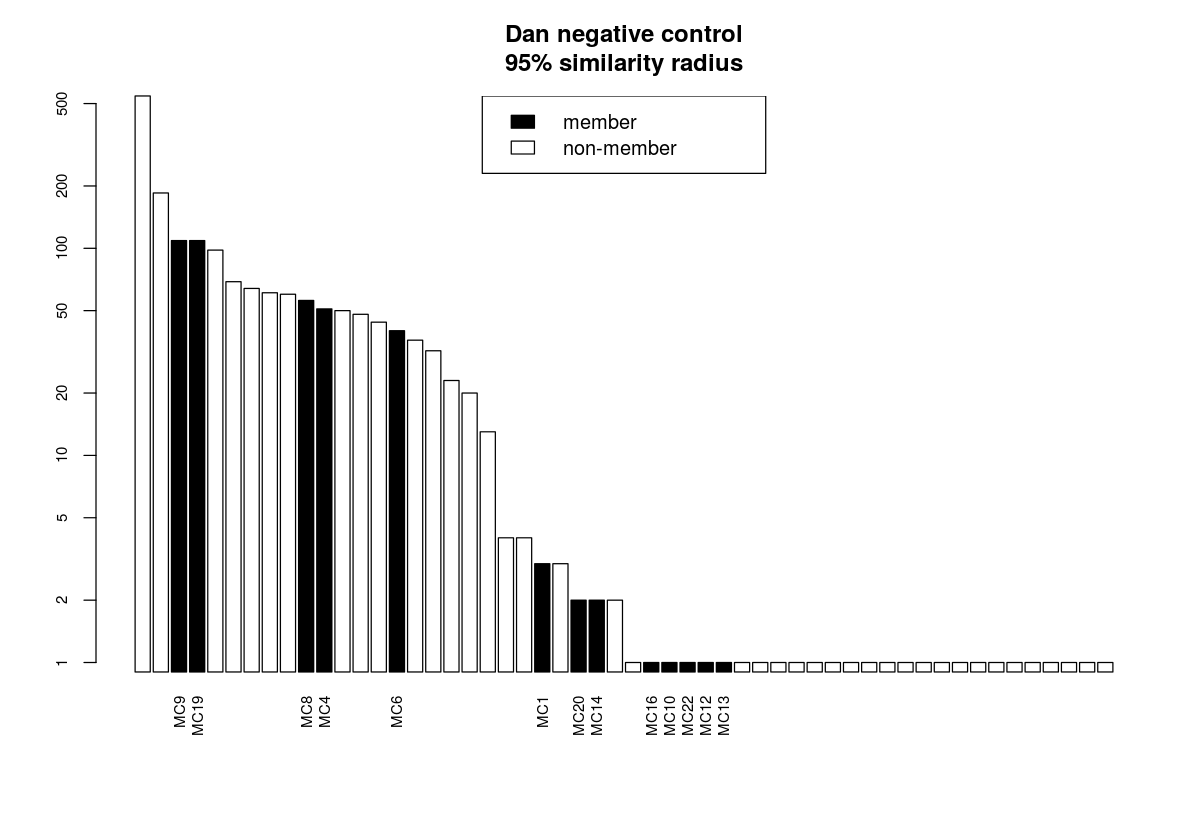

In [67]:
inout <- paste('MC', Neg95bar$MC, sep='')
inout[inout=='MC0'] <- NA

par(cex.axis = .75, mar=c(7,4,4,2))
barplot(Neg95bar$reads,las=3,log='y', names.arg=inout, col = member,
       main = 'Dan negative control\n95% similarity radius')
legend("top", legend=c('member','non-member'), fill=c(1,0))

Although I don't have much faith in these assignments, here's the same with assignments.

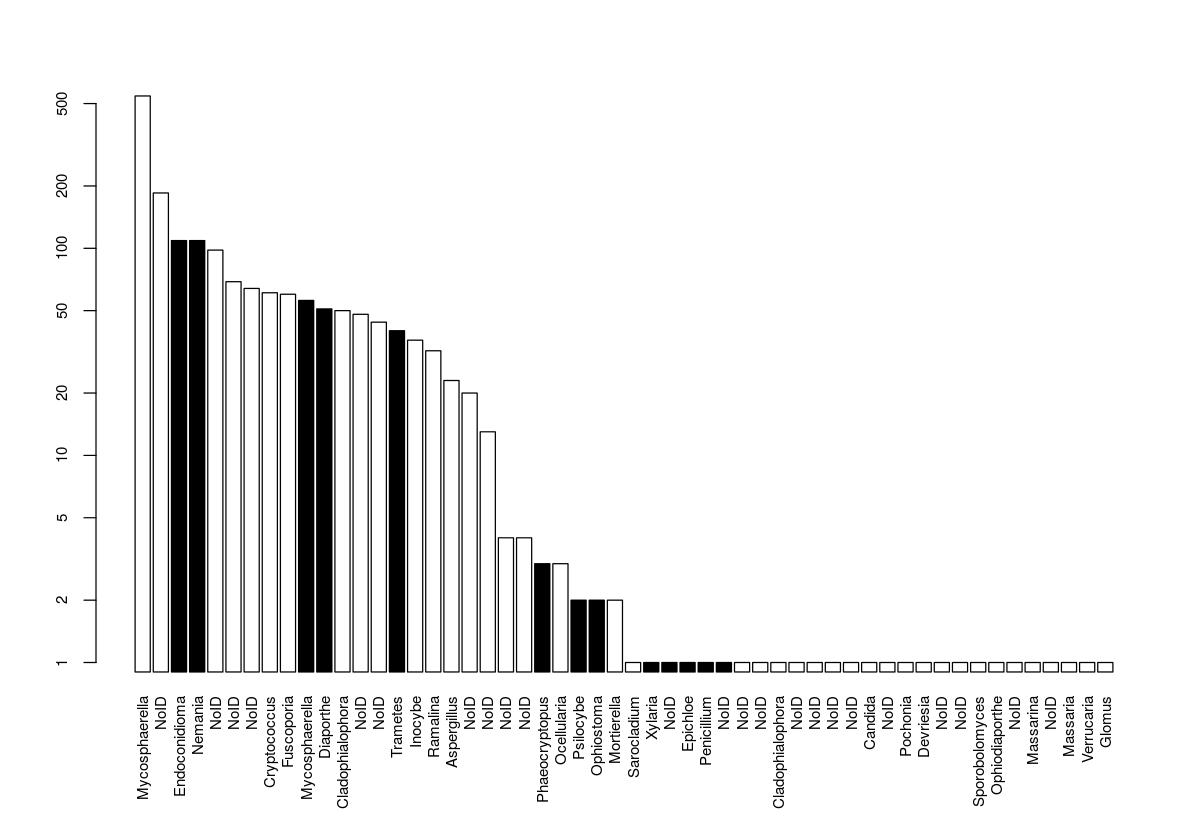

In [69]:
par(cex.axis = .75, mar=c(7,4,4,2))
barplot(Neg95bar$reads,las=3,log='y', names.arg=Neg95bar$Genus, col = member)

<a id='bleed'></a>

Here is a another negative control that was included in the illumina run, supplied by graham, created with a similar pipeline as above:

<img src='grahamneg95bar1.png', width="600", height="200">

Hmm. Time to panic? Not sure, but it seems like our positive controls are bleeding into our negative controls somehow. We took steps to reduce the possibility of cross-contamination in the lab, and this type of contamination is odd, mostly because some but not all of our mock community members are bleeding into these negative controls. At the time of illumina preps, the mock community was a single sample in the lab (one eppendorf with DNA purified from 23 of our various pure cultures). So I would expect contamination by all the OTUs in our positive controls. I would take this as a general indicator of high levels of tag-switching, but the positive controls seem to be disproportionately affecting the negative samples. If tag-switching really were this common, the ecological samples would also be leaking OTUs into our negatives at a high rate, and they would be swamped, as would our positive controls. But neither are. Curious. 

<a id='sing'></a>

### Single species positive control

Kind of a hybrid between our mock community and negative controls is our single species positive control. We'll use this control to check our radius for splitting, to get more info on what sort of contaminant abundances to subtract, and to look for tag switching. To plot what is in this sample, we begin by subsetting to just our single-species control:

In [33]:
library('phyloseq')
xyl.biom <- subset_samples(biom95, SampleNumber == 'Dc-X')

Using the same basic code as [above](#blastpipe), I blasted the sequences from all of the OTUs in this sample against the sanger sequences of our mock community. For the purposes of this search I added in the known sequence of the species that is our single-species-positive, *Xylaria hypoxylon* to our reference database of the mock community. The results:

In [39]:
blast <- read.csv("mcblast_DCX95.csv", stringsAsFactors=FALSE)
blast

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU1:X_hypoxylon_Oregon,X_hypoxylon_Oregon,100.00,180,0,0,1,180,53,232,2e-94,333
OTU247:112.2Leaf,6,100.00,184,0,0,1,184,535,352,1e-96,340
OTU254:161wood,16,100.00,180,0,0,1,180,502,323,2e-94,333
OTU347:NC.1Leaf,7,100.00,193,0,0,1,193,524,332,1e-101,357
OTU9405:160wood,11,92.13,178,8,6,1,176,487,314,2e-68,246


Five of our sequences are present in the mock community. The first is expected, *Xylaria hypoxylon*. The others:

sseqid | Taxon
-|-
6 | *Trametes versicolor*
16 | *Xylaria nigripes*
7 | cf. *Alternaria*
11 | *Penicillium* sp.

Let's make a nice dataframe to plot from:

In [40]:
reads <- taxa_sums(xyl.biom)[taxa_sums(xyl.biom)>0] ## read abundances
reads <- sort(reads, decreasing = TRUE)
xyl.gen <- tax_table(xyl.biom)[names(reads),6] ## genus names
xyl.gen[is.na(xyl.gen)] <- "NoID" ## unidentified OTUs
xyl.species <- tax_table(xyl.biom)[names(reads),7] ## species names
xyl.species[is.na(xyl.species)] <- "NoID" ## unidentified OTUs
member <- names(reads) %in% blast$qseqid ## is the OTU one of our mock community members?
MC <- vector(length = length(reads)); MC[] <- 0 ## fill with zeroes
DCX95bar <- data.frame(reads, member, MC, xyl.gen,xyl.species, stringsAsFactors=FALSE)
## check our blast results for mock community sample number, if it's a member.
for (i in 1:nrow(DCX95bar)){
        if (rownames(DCX95bar)[i] %in% blast$qseqid) {
                search <- grep(rownames(DCX95bar)[i], blast$qseqid)
                DCX95bar$MC[i] <- blast$sseqid[search]
        }
    }

Visualize these abundances:

<a id='ssbar'></a>

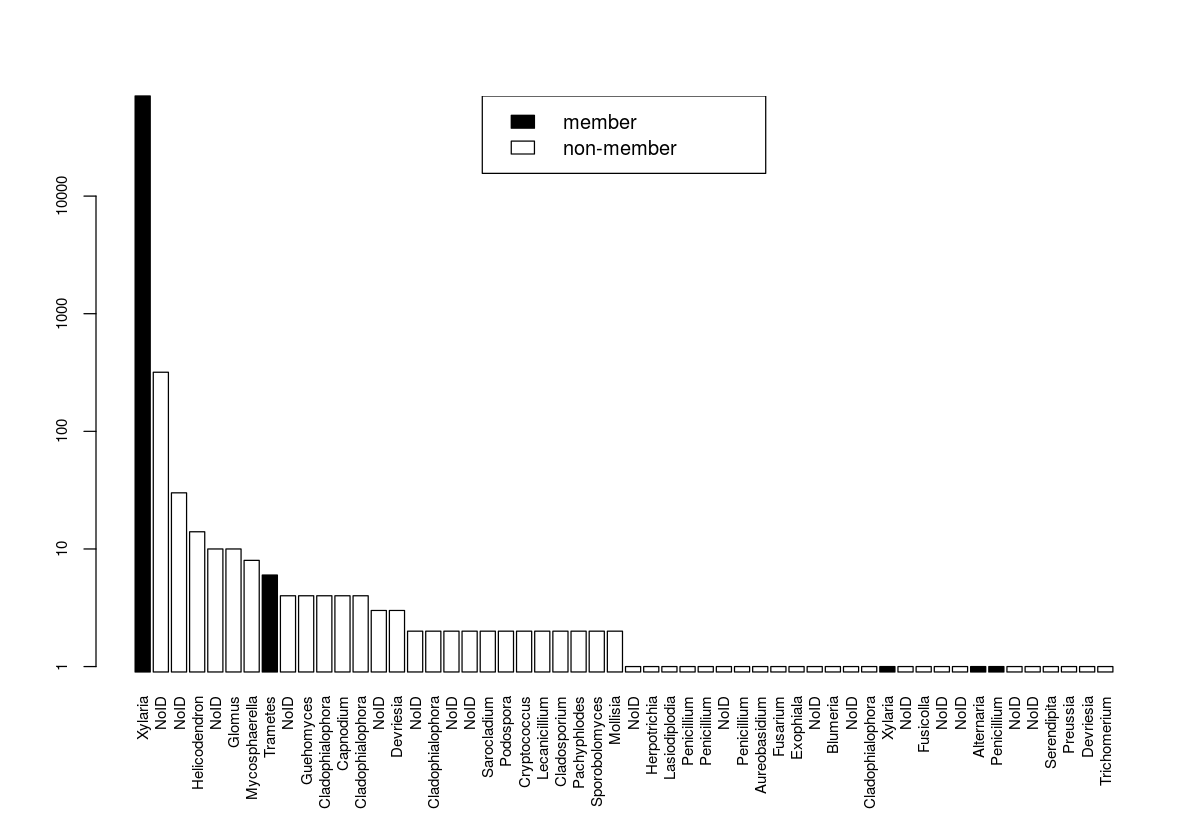

In [45]:
options(repr.plot.width = 10, repr.plot.height = 7)
par(cex.axis = .75, mar=c(7,4,4,2))
barplot(DCX95bar$reads,las=3,log='y', names.arg=DCX95bar$Genus, col = member)
legend("top", legend=c('member','non-member'), fill=c(1,0))

Some pretty clear culprits here. The tag-switched groups are in black, except for our high abundance positive control species on the far left. 

<a id='MC'></a>

### Mock community

Let's look at my mock community genomic controls, with an OTU similarity radius of 95%. Start out in R kernel, packages as [above](#import):

In [3]:
library('phyloseq')
load('biom95.rda')

In [5]:
aa95 <- subset_samples(biom95, SampleNumber == 'PosG')
dangen95 <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
dangen95 <- sort(dangen95, decreasing = TRUE)
length(dangen95)

[1] 78

<a id='split'></a>

We put in 24 species, and got 78 out. This is probably due to a combination of contamination and splitting by our OTU radius. What is the distribution of these OTU's?

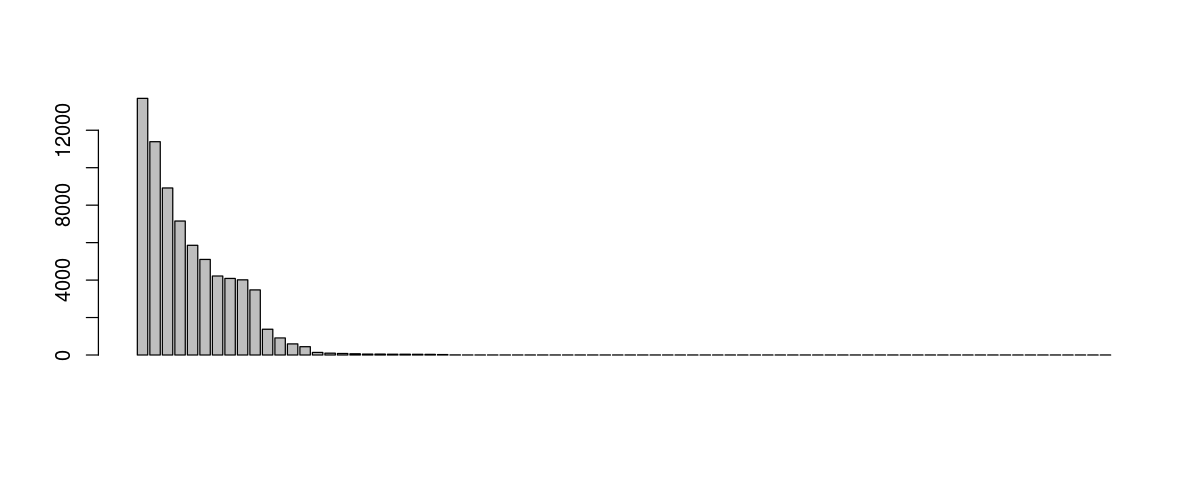

In [6]:
options(repr.plot.width = 10, repr.plot.height = 4)
barplot(dangen95, names.arg='')

Do our ITS-only positive controls show a similar distribution?

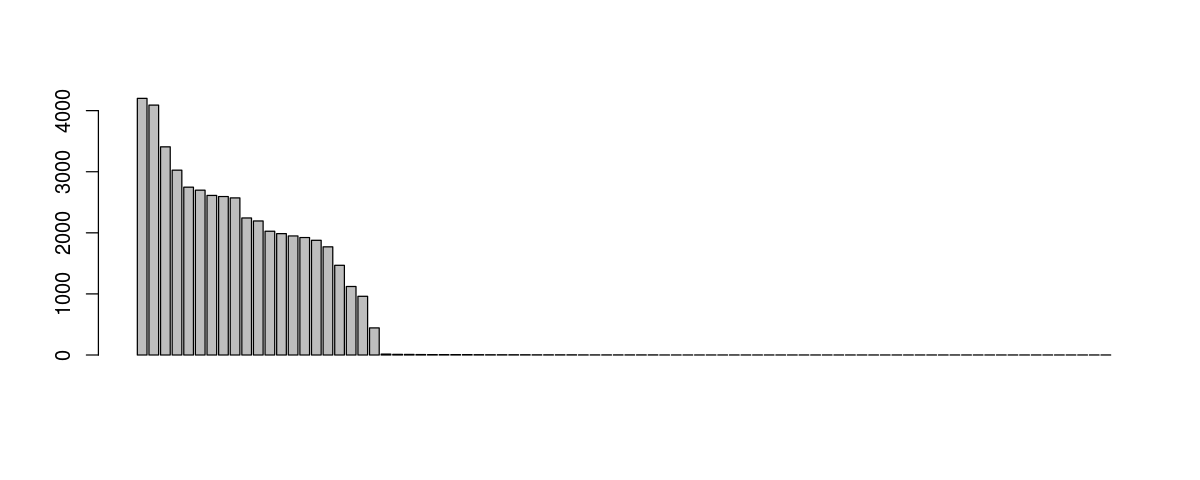

In [7]:
aa95 <- subset_samples(biom95, SampleNumber == 'PosI')
danITS95 <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
danITS95 <- sort(danITS95, decreasing = TRUE)
options(repr.plot.width = 10, repr.plot.height = 4)
barplot(danITS95, names.arg='')

Interesting, the genomic controls show a more dramatic difference in detection among samples. 

But how do we know which are contaminants/tag-switched/otu-splits, and which are intended members of our mock community? Using a pretty much identical pipeline as with our [negative control visualization](#nc), we blast the species in our positive control samples against our sanger sequences of our mock community and plot the abundances, resulting in the following plot. 

In [14]:
blast <- read.csv("mcblast_dangen95.csv")
head(blast)

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU127:12Leaf,10,100.00,174,0,0,1,174,482,309,4e-91,322
OTU139:161wood,1,99.31,144,1,0,1,144,434,291,7e-73,261
OTU181:104Leaf,8,100.00,143,0,0,1,143,451,309,5e-74,265
OTU155:122Leaf,14,100.00,197,0,0,1,197,566,370,7e-104,364
OTU210:161wood,22,100.00,168,0,0,1,168,512,345,8e-88,311
OTU234:161wood,20,100.00,217,0,0,1,217,605,389,6e-115,401


Let's check to see if all of the fungi that we intentionally put into the mock community are present. The sseqid column values are equivalent to numbers that we gave each DNA sample from our individual pure cultures. They go from MC1 to MC24, with sample MC21 skipped. 

In [15]:
1:24 %in% blast$sseqid

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE

In [21]:
sort(unique(blast$sseqid))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24

Looks like we're missing MC17, *Schizosaccharomyces pombe*. Odd.

Do we trust all of these blast results? Notice that the last three are very short matches (65, 33, and 65 bp). Also there are low percentage matches. Let's get rid of these, using ~95% cutoff. 

In [22]:
goodblast <- blast[blast$pident > 94 & blast$length > 100,] 
## use 94 instead of 95, cuz we don't want to lose the 94.89 match 

In [23]:
dim(blast); dim(goodblast)

[1] 38 12

[1] 32 12

We lose 6 matches. Any of our mock community memmbers?

In [19]:
1:24 %in% goodblast$sseqid

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE

Nope, same as before we cut out the low quality or short matches, MC17 is still the only member missing (MC21 wasn't included in the final mix). 

We can now use this dataframe of high-confidence blast matches in the same way as we did with our [negative control](#nc) to plot membership and read abundances:

In [24]:
member <- names(dangen95) %in% goodblast$qseqid
MC <- vector(length = length(dangen95))
dangen95bar <- data.frame(cbind(dangen95, member, MC))
for (i in 1:nrow(dangen95bar)){
        if (rownames(dangen95bar)[i] %in% goodblast$qseqid) {
                search <- grep(rownames(dangen95bar)[i], goodblast$qseqid)
                dangen95bar$MC[i] <- goodblast$sseqid[search]
        }
    }

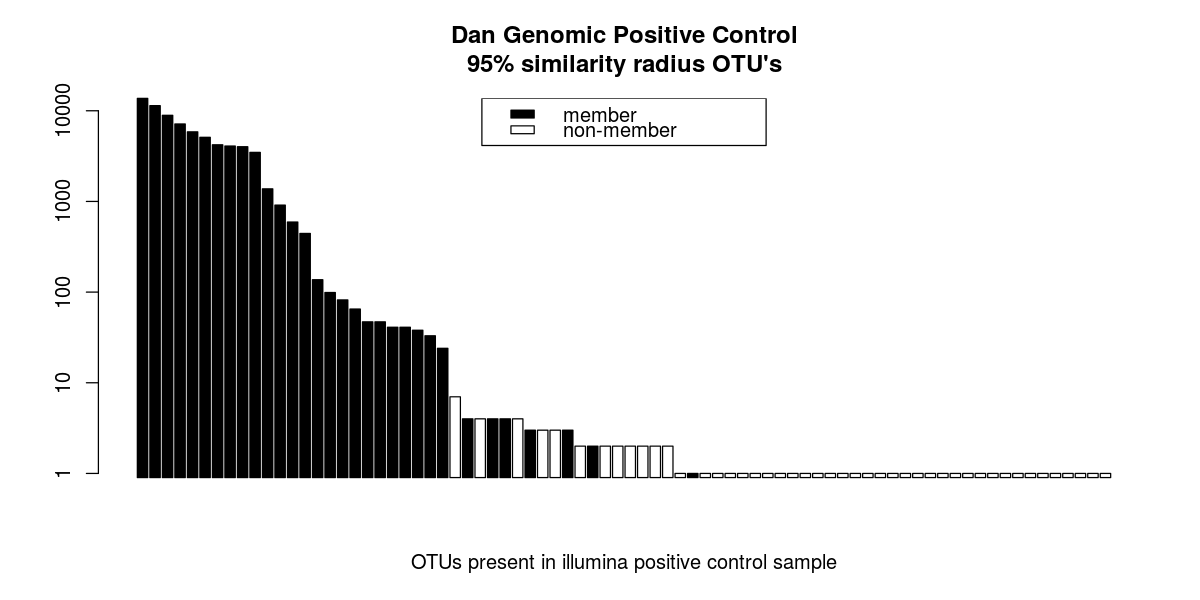

In [27]:
options(repr.plot.width = 10, repr.plot.height = 5)
barplot(dangen95bar$dangen95, names.arg=NULL, col = dangen95bar$member,
        log="y", main="Dan Genomic Positive Control\n95% similarity radius OTU's",
        xlab='OTUs present in illumina positive control sample')
        legend("top", legend=c('member','non-member'), fill=c(1,0))

Log transformed. OTUs with no match to our sanger sequences are colored white. Notice that most of the rare OTUs are not members of our original mock community. They are presumably contaminants or the results of tag-switching. 

Let's get a closer look at the intended members of our mock community:

In [28]:
dtab <- table(dangen95bar$MC)
dtab <- dtab[-1] #exclude non-members
dtab


 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24 
 5  1  1  1  1  1  1  7  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

This table shows us that MC1 and MC8 were split up by our biominformatics. Let's visualize this, and compare to our other radius. For the plotter, get a matrix, each column representing our sanger-sequence sample numbers, and each row our otus in the illumina sample that matched to these sanger-sequences (MC#'s). 

In [29]:
stackmat <- matrix(nrow=max(dtab), ncol=24)
stackmat[] <- 0
stackmatnames <- paste("MC", 1:24, sep='')
colnames(stackmat) <- stackmatnames

for (i in 1:24){
        bb <- dangen95bar[dangen95bar$MC == i,, drop=FALSE]
        for (j in 1:nrow(bb)){stackmat[j,i] <- bb$dangen95[j]}
    }

In [30]:
stackmat <- stackmat[,-21] ## no MC21, wasn't put into MC mix
## sort by read abundances:
stackmat <- stackmat[,order(colSums(stackmat), decreasing = TRUE)]
stackmat

MC10,MC1,MC8,MC14,MC22,MC20,MC13,MC12,MC24,MC15,⋯,MC5,MC7,MC11,MC6,MC3,MC2,MC23,MC4,MC18,MC17
13701,11388,8917,7153,5856,5102,4218,4087,4013,3475,⋯,444,137,99,82,65,33,24,4,4,NA
0,47,47,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,41,41,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,4,38,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,3,3,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,2,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Now use this to plot our read abundances, to look at splitting of OTUs at this radius:

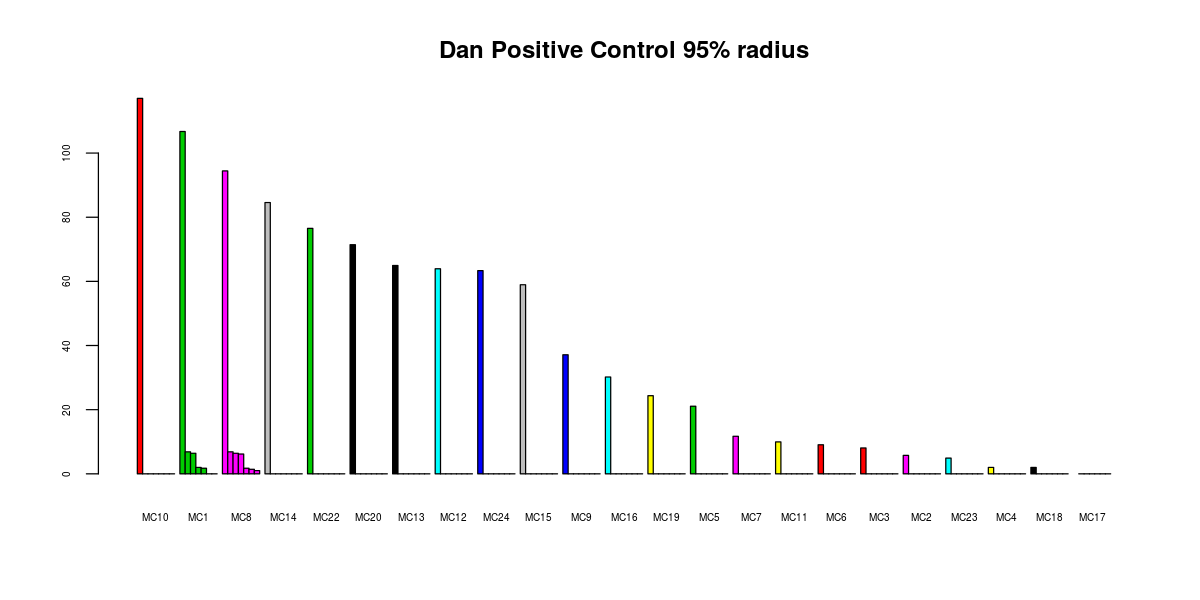

In [31]:
## make our colors from a palette. Randomize for better separation
bcols <- rep(sample(1:ncol(stackmat), replace=FALSE, size=23), each=nrow(stackmat))

par(cex.axis=.5)
## we can see our lower abundances better with sqrt:
barplot(sqrt(stackmat), beside = TRUE, col = bcols, main="Dan Positive Control 95% radius") 
par(mfrow=c(1,1))


We can see that MC1 and MC8 were heavily split by our OTU radius. This is the 95% radius, so we assume that the 97% radius was even more divisive. MC1 is *Phaeocryptopus gaeumannii* and MC8 is a *Ramularia* sp. The otus that are split tend to create low abundance splinter OTUs, so perhaps the best way to deal with this is by introducing abundance cutoffs [below](#clean), requiring that each OTU have at least 10 reads to be used. 

We can run our other positive controls through the above pipeline, and compare. A comparison of OTU numbers, using the code [here](#split). Our numbers of OTUs in each are:

DNA | Similarity | #OTUs
----|-------------|------
Genomic | 95% | 78   
Genomic | 97% | 80   
ITS-only | 95% | 84   
ITS-only | 97% | 90   

Both genomic positive controls lack two OTUs (MC4 and MC17). In the ITS-only positive controls we recover MC4. How do the read abundance distributions in these compare?

Introduced vs. un-intended otus in our illumina sample of the mock community ("members vs. non-members"). Black colored OTUs were an original pure culture that was included in our mock community, then recovered in the illumina sample:

<img src='dangen95bar1.png', width=500, height=500>

<img src='dangen97bar1.png', width=500, height=500>

<img src='danITS95bar1.png', width=500, height=500>

<img src='danITS97bar1.png', width=500, height=500>

Graham also ran a positive control sample. Looking at this with the 95% similarity radius:

<img src='grahamgen95bar1.png', width="500", height="100"/>

A look at OTU splitting. Note that these are square-root transformed, though the axis units aren't transformed. 

<a id='danmc'></a>

<img src='dangen95bar2.png', width=900, height=900>

<img src='dangen97bar2.png', width=900, height=900>

<img src='danITS95bar2.png', width=900, height=900>

<img src='danITS97bar2.png', width=900, height=900>

<a id='grahammc'></a>

Graham's positive control:

<img src='grahamgen95bar2.png'>

The ITS distributions are much more even among the OTUs. There is more splitting of OTUs with the stricter similarity cutoffs for OTUs (97%), and more splitting with the ITS-only samples. Notice that there appears to be some loss of information in the genomic samples as compared to the ITS samples, species aren't being observed evenly at all in this process.  

<a id='clean'></a>

## Cleanup using controls

We want to run ecological analyses on our data. To keep false positives to a minimum, we want to reduce the effects of tag switching and lab contamination, and splitting of true species into multiple OTUs. So we (1) remove low abundance samples and controls (2) remove minimum abundances (3) subtract remaining abundances of contaminants that we find in our controls and (4) remove our positive control species from wherever they occur, because my negative controls have convinced me that these OTUs are bleeding over to other samples at high rates, so I can't trust observations of these OTUs in our ecological samples (sucks). 

### Removing low abundance samples:

As a first step, let's remove samples with very low read abundances. These are problematic downstream for comparisons among samples, because of the unequal variances, etc. Which are our low abundance samples that we should remove?

In [74]:
sample_sums(biom95)[sample_sums(biom95) < 2000]

255wood    86Leaf    18Leaf 112_1Leaf 113_2Leaf    74Leaf 113_1Leaf 126_2Leaf 
     1759      1579      1405         3         6       328        54         5 
   91Leaf     Strom 
        6        51

Some loss, but many of these are controls, etc. So we'll prune these low-read samples out, and control samples also get removed.

In [75]:
biom95eco <- subset_samples(biom95, SorC=='Sample')
biom95eco_hiread <- prune_samples(sample_sums(biom95eco)>=2000, biom95eco)

### Minimum abundances of observations

We have two ways of reducing error from OTU splitting, (1) choosing the "correct" radius of OTU similarity clusters, and then (2) looking for a minimum read abundance cutoff for every OTU observation, since we expect a "correct" OTU radius will generate only low abundance "splinters". Looking above, we have two radii to choose from, a 95% and 97% similarity radius. The 95% radius seems to cause less splitting, and we don't have any indication we're lumping species: MC11 and MC12 are species in the same genus, *Penicillium*, and remain distinct at a 95% radius. 

We can get an idea of levels of OTU splitting by zooming in on the two mock-community genomic positive controls that we have. If we zoom into [my MC positive control](#danmc) at read abundances less than 150...

<img src='dangen95bar3.png'>

And if we look closely at [Graham's positive control](#grahammc) we see similar levels of splitting. 

<img src='grahamgen95bar3.png'>

Given these abundances, we are presented with a choice: larger minimum cutoffs will get rid of our splinter OTUs, but lose real OTUs in the process. For example, to get rid of all of our spinter OTUs in our positive controls, we could use a minimum cutoff of 80 reads. However, in the process we lose 5 real OTUs in my positive control and 7 real OTUs in Graham's.  

For now, in the wood library, let's choose a minimum OTU-per-sample cutoff of 60 reads. In my positive control sample this removes \[all\] 10 splinter OTUs, while costing us 4 real OTUs (MC2, MC23, MC4, and MC18). In Graham's, this removes 10 splinter OTUs (= all but one), costing us 7 real OTUs. This cutoff also gets rid of many of the tag-switched OTUs we find in our [single species](#sing)and [negative controls](#nc), though far from all of these. 

We have no positive controls from the leaf data, since Roo sequenced those in a separate study, so for now we'll assume that these samples have a +/- similar level of error from tag-switching. To figure the level of subtraction for tag-switching and splinter OTUs in his study, we'll subtract the same proportion of reads/library as the wood. Relative to the total number of reads (4,521,655) in the wood library, this is a reduction in each OTU/sample observation of 60/4,521,655 = 0.000013269 times the library size. If we multiply the size of the leaf library by this, we get (0.000013269)x(10,751,750 reads) = 142.6972, or 143 reads. 

Let's break up our biom table into wood and leaf reads, subtract our minimum abundances, then merge them back together.

In [76]:
## split biom
leafeco <- subset_samples(biom95eco_hiread, Library=='L')
woodeco <- subset_samples(biom95eco_hiread, Library=='W')

## wood, take out 60 reads
bb <- otu_table(woodeco)
bb <- bb-60
bb[bb<0] <- 0
otu_table(woodeco) <- bb

## leaf, take out 140 reads
bb <- otu_table(leafeco)
bb <- bb-140
bb[bb<0] <- 0
otu_table(leafeco) <- bb

## does "merging" work here to bring these back together?
biom95.mend <- merge_phyloseq(woodeco,leafeco)

## check to make sure structure is intact
dim(otu_table(biom95eco_hiread))
dim(otu_table(biom95.mend))

## spot check wood territory
otu_table(biom95eco_hiread)[1:5,1:5]
otu_table(biom95.mend)[1:5,1:5]


## spot check leaf territory
otu_table(biom95eco_hiread)[140:145,172:177]
otu_table(biom95.mend)[140:145,172:177]

## row and column order changed after merging?
all(rownames(otu_table(biom95.mend)) == rownames(otu_table(biom95eco_hiread)))
all(colnames(otu_table(biom95.mend)) == colnames(otu_table(biom95eco_hiread)))

[1] 10271   214

[1] 10271   214

,164wood,165wood,166wood,167wood,168wood
OTU1:X_hypoxylon_Oregon,8,59,0,0,0
OTU7654:160wood,0,1,0,0,0
OTU2438:53Leaf,0,0,0,0,0
OTU541:114Leaf,0,0,0,0,0
OTU116:65Leaf,74,190,19,29,69


,164wood,165wood,166wood,167wood,168wood
OTU1:X_hypoxylon_Oregon,0,0,0,0,0
OTU7654:160wood,0,0,0,0,0
OTU2438:53Leaf,0,0,0,0,0
OTU541:114Leaf,0,0,0,0,0
OTU116:65Leaf,14,130,0,0,9


,4Leaf,29Leaf,24Leaf,9Leaf,53Leaf,6Leaf
OTU271:163wood,0,0,0,0,0,0
OTU676:177wood,0,0,0,0,0,0
OTU125:12Leaf,0,0,213,0,91,0
OTU8501:26Leaf,0,0,0,0,0,0
OTU466:192wood,0,0,0,0,0,0
OTU616:163wood,0,0,0,0,0,0


,4Leaf,29Leaf,24Leaf,9Leaf,53Leaf,6Leaf
OTU271:163wood,0,0,0,0,0,0
OTU676:177wood,0,0,0,0,0,0
OTU125:12Leaf,0,0,73,0,0,0
OTU8501:26Leaf,0,0,0,0,0,0
OTU466:192wood,0,0,0,0,0,0
OTU616:163wood,0,0,0,0,0,0


[1] TRUE

[1] TRUE

Okay, looks good. Order of rows and columns maintained, leaves have had 140 reads removed, and wood have had 60 reads removed. 

### Subtracting contaminant abundances 

Now we remove every contaminant OTU at the level of abundances that they appeared in any of our controls. In our positive controls, these are the non-mock-community fungi that appeared in our samples. All OTUs that appeared in negative controls are removed in the abundances that they appeared.

To get our control samples OTU matrix:

In [77]:
controls <- subset_samples(biom95, SorC=='Control' & Library != 'S') ## no stromata sample

In [78]:
controls

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10271 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 10271 taxa by 7 taxonomic ranks ]

Get the maximum values from these various controls. This is what we will subtract from our ecological samples:

In [79]:
contam <- apply(otu_table(controls), 1, max)

In [80]:
sum(contam>0)

[1] 310

310 contaminants and mock community OTUs. Subtract these out. 

In [81]:
aa <- otu_table(biom95.mend) - contam
aa[aa < 0] <- 0 ## bring negatives up to zero
biom95.contam.rem <- biom95.mend
otu_table(biom95.contam.rem) <- aa

In [82]:
#save(biom95.contam.rem, file='biom95.contam.rem.rda')

### Remove all mock community OTUs

Unfortunately, it doesn't appear that we can trust observations of our mock community OTUs [in our data](#bleed), so we'll go ahead and remove any OTU that seems to be a member of our mock community. This will involve using blastn again to search all representative OTU sequences from the illumina library against our sanger sequence database of our mock community. 

Out of R, into BASH for a few minutes. As before, our reference OTU sequences have messy identifier lines, let's clean them up a little with sed:

In [1]:
sed "/>O/s/;.*;$//" otus_95_combo_asstax.fasta > otus_95.fasta

Using the same blast-formatted database as [before](#blastn), look for matches:

In [2]:
blastn -query otus_95.fasta -db mcsanger.fasta -out mcblast_allOTUs.csv -outfmt 10 -max_target_seqs 1

Read this into R, assign some column names. Back to R kernel:

In [4]:
## pick the biom tables back up into workspace
load('biom95.contam.rem.rda') 
load('biom95.rda')

In [83]:
blast <- read.csv('mcblast_allOTUs.csv', header=FALSE)
blasthead <- c('qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore')
colnames(blast) <- blasthead

This gives us a dataframe of OTUs in our illumina study that might be members of the mock community.

In [84]:
head(blast)

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU1:X_hypoxylon_Oregon,Sample16_ITS4,95.24,63,3,0,1,63,502,440,2e-24,100.0
OTU4:N_sp_1,Sample16_ITS4,93.33,60,3,1,2,61,501,443,2e-20,87.9
OTU3:H_notatum,Sample24_ITS4,100.00,209,0,0,1,209,537,329,2e-110,387.0
OTU17:X_sp_nov_1_long,Sample16_ITS4,91.67,60,3,1,1,58,502,443,7e-19,82.4
OTU15:H_perforatum_USA,Sample24_ITS4,86.28,226,12,8,1,224,537,329,1e-62,228.0
OTU27:X_apiculata_California,Sample16_ITS4,96.61,59,1,1,1,58,502,444,3e-23,97.1


But we have standards...

In [85]:
goodblast <- blast[blast$pident > 95 & blast$length > 100,] 

How many OTUs match strongly to our mock commmunity?

In [86]:
nrow(blast) ## 687 otus, but...
nrow(goodblast) ## only 36 OTUs are strong matches

[1] 687

[1] 36

687 OTUs blasted as possible matches, but only 36 OTUs blast strong and long. To remove these from our biom table:

In [87]:
## which of our rownames (= OTU names) are not in this list of strong matches?
pcotus <- !(rownames(otu_table(biom95)) %in% goodblast$qseqid) 
## keep only these:
biom95.mc.rem <- prune_taxa(pcotus, biom95.contam.rem)

In [88]:
#save(biom95.mc.rem, file='biom95.mc.rem.rda')

What's the damage so far?

In [89]:
biom95; biom95.mc.rem

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10271 taxa and 232 samples ]
sample_data() Sample Data:       [ 232 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 10271 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10235 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 10235 taxa by 7 taxonomic ranks ]

How many total reads have been lost by this clean up process?

In [90]:
sum(sample_sums(biom95))
sum(sample_sums(biom95.mc.rem))

[1] 15273456

[1] 12898479

Loss of ~3 million reads. More importantly, how many observations have been lost?

In [91]:
sum(otu_table(biom95) > 0)
sum(otu_table(biom95.mc.rem) > 0)

[1] 53424

[1] 10456

Wow, we lost 80% of our observations. Hope some statistical power remains...

<a id='deseq'></a>

## Variance stabilization of our reads

It's important to [stabilize the variance](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003531of) of our combined-leaf-and-wood-endophyte read depths, we'll do this using the [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) package in R. This is a way of making the samples, which have highly variable numbers of reads in them, comparable for downstream statistical analyses.

Roo has written a function in R to stream-line the process of using deseq variance stabilization, because it was originally written for RNA-seq data, with dense matrices. Species matrices are usually pretty sparse, so deseq needs a few workarounds to handle our kind of data. Thankfully, Roo has worked on this, and saved me probably weeks of work. His function looks like this: 


In [92]:
DESeq_varstab <- function(phyloseq, design) {
# phyloseq = the input phyloseq object that you want to get DESeq transformed counts for
# design_variable = the design for the conversion to the DESeq object. must be in the form "as a function of", for example "~Host_Genus", must be a variable in the phyloseq object
        deseq.vst = NULL
        geo_Means = NULL
        phyloseq.DESeq = NULL
        # Convert to a DESeq object
        deseq = phyloseq_to_deseq2(phyloseq, design)
        # calculate geometric means prior to estimate size factors
        gm_mean = function(x, na.rm=TRUE){
                exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
                }
        geo_Means = apply(counts(deseq), 1, gm_mean)
        # Check to see if any columns (samples) don't have any OTUs in them:
        if(sum(colSums(counts(deseq)) == 0) == 0) { # if all samples have taxa, go on
                # Now we step through the size factors, dispersions, and varience stabilization:
                deseq = estimateSizeFactors(deseq, geoMeans = geo_Means)
                deseq = estimateDispersions(deseq) # long step
                deseq.vst = getVarianceStabilizedData(deseq)
                # replace negatives with zeros
                deseq.vst[deseq.vst <0] <- 0
                # add the varience stabilized otu numbers into the dataset:
                otu_table(phyloseq) <- otu_table(deseq.vst, taxa_are_rows = TRUE)
                # create a new object for the varience stabalized set
                phyloseq -> phyloseq.DESeq
                # And, filter any taxa that became 0s all the way across
                phyloseq.DESeq = filter_taxa(phyloseq.DESeq, function(x) sum(x) > 0.1, T)
                # return the new phyloseq object
                return(phyloseq.DESeq)
        } # end of IF loop 
        else {return("Error: your phyloseq object has samples with no taxa present.")}
} # end function


So let's try it out on our data. DESeq asks for an experimental design to incorporate in its modeling of read counts. In this instance, we are making comparisons of the relative importance of the origins of our endophytes - are wood endophytes or leaf endophytes more predictive of decomposers (stromata) at a given site? With this question, I believe the design variable is the origin of the sample, leaf or wood, (our "Library" metadata variable). 

In [93]:
deseq95 <- DESeq_varstab(biom95.mc.rem, ~Library)

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Roo's function goes into DESeq land and back, returning us a phyloseq object. How does our data look after touching the void and coming back to us?

In [95]:
#save(deseq95, file='deseq95.rda')

In [96]:
deseq95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2051 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 2051 taxa by 7 taxonomic ranks ]

In [97]:
biom95.mc.rem

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10235 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 10235 taxa by 7 taxonomic ranks ]

Looks like we lost some taxa. Let's compare the distributions of our read depths before and after variance stabilization:

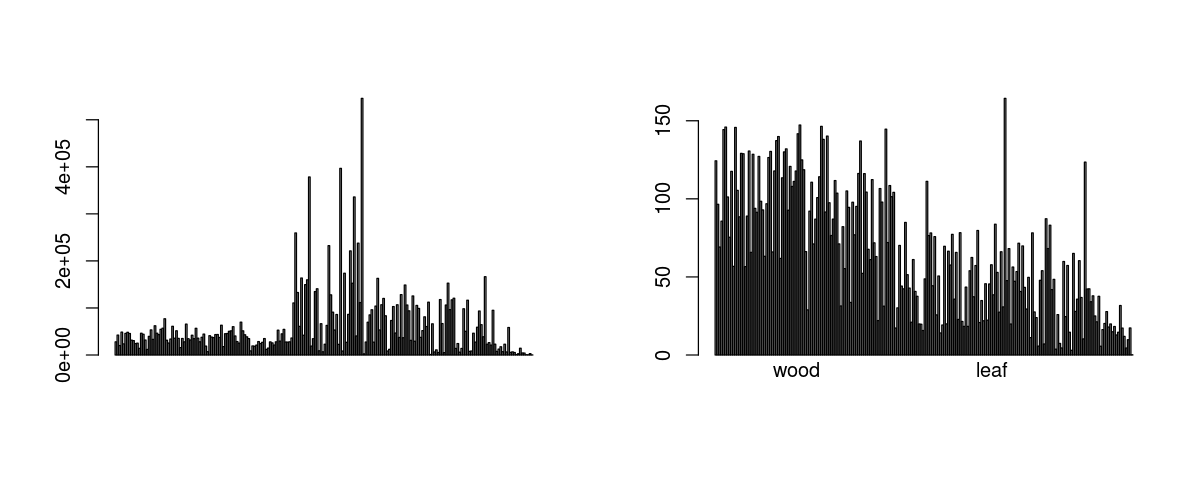

In [98]:
par(mfrow = c(1,2))
options(repr.plot.width = 10, repr.plot.height = 4)

barplot(sample_sums(biom95.mc.rem), axisnames=FALSE)
#mtext(text='wood', side = 1, at=50)
#mtext(text='leaf', side = 1, at=170)

barplot(sample_sums(deseq95), axisnames=FALSE)
mtext(text='wood', side = 1, at=50)
mtext(text='leaf', side = 1, at=170)

Huh, it looks like the wood retained more reads than the leaves. I'm a bit confused by this and our low read numbers in general after variance stabilization. Maybe this is due to the very different abundances present between the two studies.  

<a id='Ords'></a>

## NMS/PERMANOVA Ordinations

As a first look at our data, we'll model similarity among our communities of endophytes use [PERMANOVA (or 'NPMANOVA')](https://sites.google.com/site/mb3gustame/hypothesis-tests/manova/npmanova) and visualize differences among groups using [non-metric multidimensional scaling](https://mb3is.megx.net/gustame/dissimilarity-based-methods/nmds). There are built-in visualization methods for NMS in phyloseq that use ggplot, notably the [ordinate/plot_ordination](https://joey711.github.io/phyloseq/plot_ordination-examples.html), that can do this for us, but I like to do things the hard way...

<a id='WvsL'></a>

### Wood vs. Leaf libraries 

Our first, most basic comparison is that of the wood communities to the leaf communities. I cannot confidently say that any differences we notice between these two types of sample are ecological, though, as they were prepared separately by Roo and myself, and sequenced in different runs. Differences that we find may be due to lab and sequencer. 

In [99]:
## get two otu tables out, one for all wood samples, one for all leaf samples:
woodOTU <- otu_table(subset_samples(deseq95, Library=='W'))
wood <- t(woodOTU@.Data) ## transpose so samples are rows

leafOTU <- otu_table(subset_samples(deseq95, Library=='L'))
leaf <- t(leafOTU@.Data) ## transpose so samples are rows

In [100]:
dim(wood); dim(leaf) ## note this 
nmsmat <- rbind(wood, leaf)

[1]   91 2051

[1]  123 2051

In [101]:
WvsL <- metaMDS(nmsmat)

Wisconsin double standardization
Run 0 stress 0.09478001 
Run 1 stress 0.09504606 
... Procrustes: rmse 0.06524677  max resid 0.7192965 
Run 2 stress 0.09493494 
... Procrustes: rmse 0.06503096  max resid 0.6922704 
Run 3 stress 0.09519018 
... Procrustes: rmse 0.06706998  max resid 0.7837193 
Run 4 stress 0.09489367 
... Procrustes: rmse 0.01074522  max resid 0.1053357 
Run 5 stress 0.09461839 
... New best solution
... Procrustes: rmse 0.06010406  max resid 0.71572 
Run 6 stress 0.09443446 
... New best solution
... Procrustes: rmse 0.02276839  max resid 0.3006734 
Run 7 stress 0.09481623 
... Procrustes: rmse 0.02567602  max resid 0.2753104 
Run 8 stress 0.09526362 
Run 9 stress 0.09473444 
... Procrustes: rmse 0.02462409  max resid 0.2673362 
Run 10 stress 0.09437555 
... New best solution
... Procrustes: rmse 0.01069752  max resid 0.13112 
Run 11 stress 0.09485432 
... Procrustes: rmse 0.02981683  max resid 0.324763 
Run 12 stress 0.09444346 
... Procrustes: rmse 0.01241138  max r

Multiple attempts didn't converge on a single solution, but the stress is low enough for all of them, and I think they are pretty similar solutions (~.09), let's look at it:

In [102]:
## make a color vector, leaves green, wood brown:
color <- NULL
color[1:91] <- 'brown'
color[92:214] <- 'green'

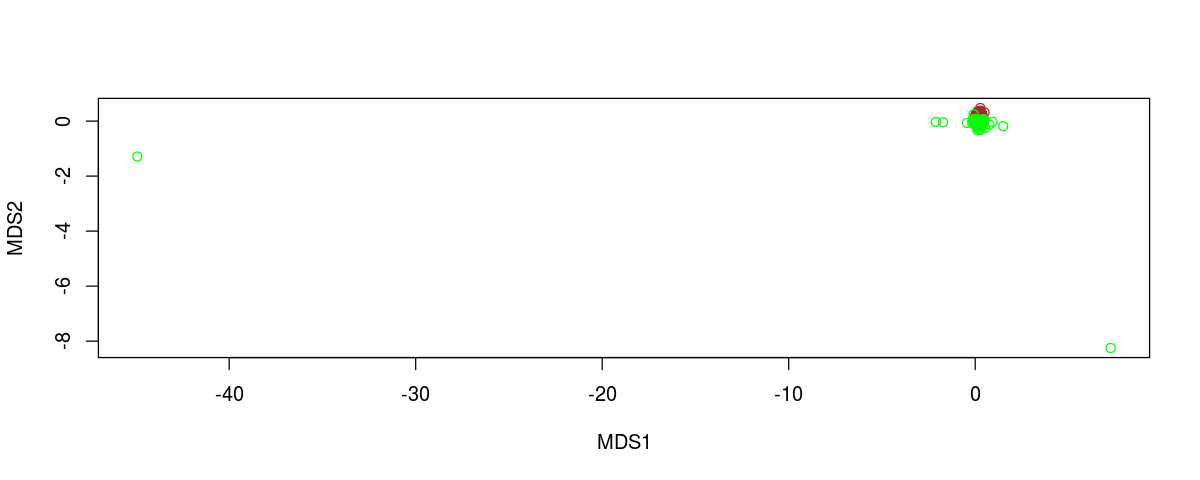

In [103]:
plot(WvsL$points, col=color)

Well, that's weird looking. There are two outliers that we can identify with some point-n-click:

In [105]:
identify(WvsL$points) ## 169, 214

What are these?

In [106]:
WvsL$points[169,,drop=FALSE]
WvsL$points[214,,drop=FALSE]

,MDS1,MDS2
61Leaf,-44.92389,-1.286973


,MDS1,MDS2
67Leaf,7.262901,-8.247818


Well, these points presumably have some weird stuff in them. If we exclude them for the moment, what does our ordination look like?

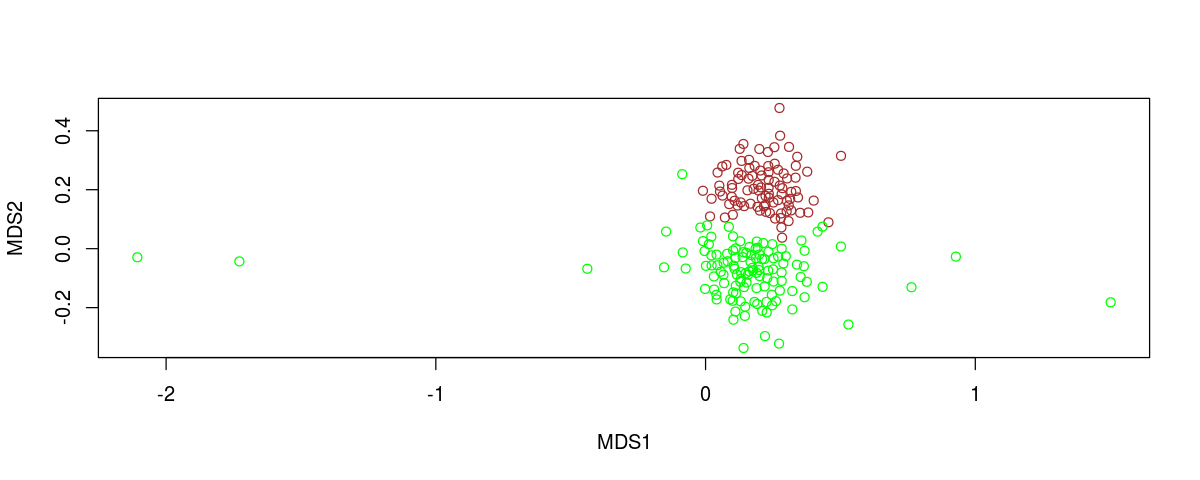

In [107]:
plot(WvsL$points[-c(169,214),], col=color[-c(169,214)])

Do we see any sort of difference if we transform our data to presence/absence?

In [108]:
nmsmat.PA <- nmsmat
nmsmat.PA[nmsmat.PA > 0] <- 1
WvsL.PA <- metaMDS(nmsmat.PA)

Run 0 stress 0.0947475 
Run 1 stress 0.0948473 
... Procrustes: rmse 0.01533415  max resid 0.1546018 
Run 2 stress 0.09474519 
... New best solution
... Procrustes: rmse 0.06245672  max resid 0.680729 
Run 3 stress 0.09459834 
... New best solution
... Procrustes: rmse 0.01706311  max resid 0.1772848 
Run 4 stress 0.09464746 
... Procrustes: rmse 0.05210577  max resid 0.6706163 
Run 5 stress 0.09562312 
Run 6 stress 0.09486754 
... Procrustes: rmse 0.01430802  max resid 0.1216936 
Run 7 stress 0.09483498 
... Procrustes: rmse 0.01608942  max resid 0.1633024 
Run 8 stress 0.09499032 
... Procrustes: rmse 0.02815602  max resid 0.3117484 
Run 9 stress 0.09453789 
... New best solution
... Procrustes: rmse 0.01490791  max resid 0.1745514 
Run 10 stress 0.09461045 
... Procrustes: rmse 0.03455184  max resid 0.442943 
Run 11 stress 0.0947326 
... Procrustes: rmse 0.02224217  max resid 0.2428005 
Run 12 stress 0.09493162 
... Procrustes: rmse 0.02543145  max resid 0.2624695 
Run 13 stress 0.0

Similar stresses. 

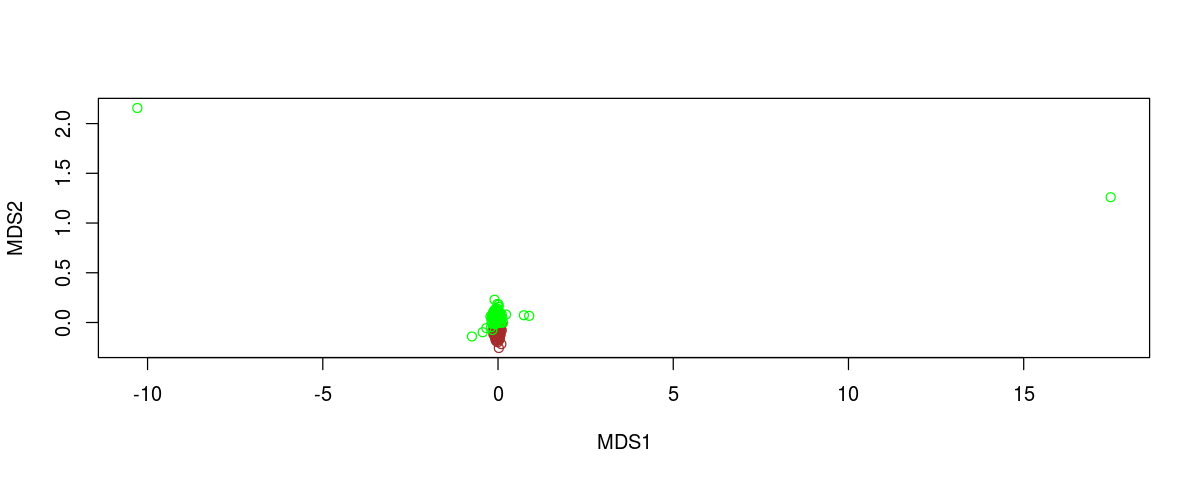

In [110]:
plot(WvsL.PA$points, col=color)

Same outliers. Without them?

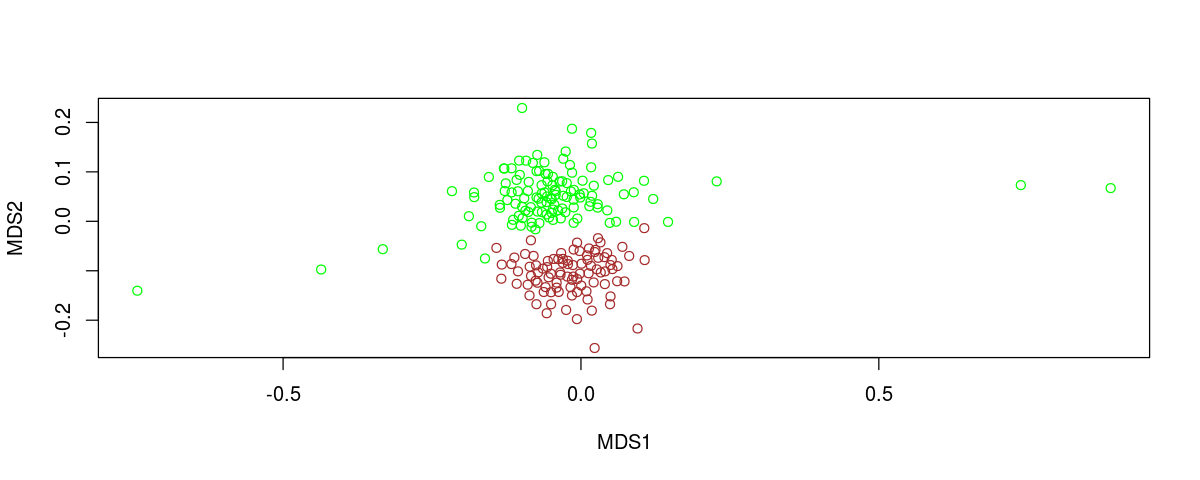

In [111]:
plot(WvsL.PA$points[-c(169,214),], col=color[-c(169,214)])

Presence/Absence doesn't seem to affect the grouping much. In either case, we observe a strong difference between the communities of leaf and wood communities, though I can't say whether this is a "natural" difference or a result of the separate laboratory preps and sequencer runs. 

<a id='shareWvsL'></a>

**Wood vs. Leaf endophyte comparison, with shared species only**

One way to address the lack of information about the reasons for this separation between leaf and wood endophyte communities is to constrain our analysis to just those OTUs that were detected by both studies, and transforming to just presence/absence data. We can then be somewhat more assured that differences in the communities of these OTUs are "real" and not only the artifact of the different lab preps and sequencing events. 

In [80]:
wood <- subset_samples(deseq95, Library=="W")
leaf <- subset_samples(deseq95, Library=="L")

## reduce these OTU tables to non-zero rows:
woodOTU <- otu_table(wood) ## otus are rows
woodspp <- rownames(woodOTU[rowSums(woodOTU)>0,])

## do the same for the leaves:
leafOTU <- otu_table(leaf)
leafspp <- rownames(leafOTU[rowSums(leafOTU)>0,])

## which species are in both?
shared <- woodspp[woodspp %in% leafspp]

## use this to subset our biom table
shared95 <- prune_taxa(rownames(otu_table(deseq95)) %in% shared, deseq95)
## we need to get rid of samples with nothing in
## in them, not meaningful for our ordinations.
shared95 <- prune_samples(colSums(otu_table(shared95)) > 0, shared95)

In [82]:
#save(shared95, file='shared95.rda')

In [208]:
deseq95
shared95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2051 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 2051 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 220 taxa and 208 samples ]
sample_data() Sample Data:       [ 208 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 220 taxa by 7 taxonomic ranks ]

We lose 6 samples that have no species in common between wood and leaf communities. 

In [212]:
woodOTU <- otu_table(subset_samples(shared95, Library=='W'))
wood <- t(woodOTU@.Data) ## transpose so samples are rows
leafOTU <- otu_table(subset_samples(shared95, Library=='L'))
leaf <- t(leafOTU@.Data) ## transpose so samples are rows
nmsmat <- rbind(wood, leaf)
nmsmat[nmsmat > 0] <- 1 ## transform to presence/absence
WvsL <- metaMDS(nmsmat)
dim(wood); dim(leaf) ## note this  

Run 0 stress 0.09733358 
Run 1 stress 0.0971552 
... New best solution
... Procrustes: rmse 0.04049175  max resid 0.4674275 
Run 2 stress 0.09726078 
... Procrustes: rmse 0.009034514  max resid 0.06908972 
Run 3 stress 0.09730505 
... Procrustes: rmse 0.02903737  max resid 0.2943405 
Run 4 stress 0.09705711 
... New best solution
... Procrustes: rmse 0.02150993  max resid 0.2438883 
Run 5 stress 0.09693829 
... New best solution
... Procrustes: rmse 0.03114944  max resid 0.3424164 
Run 6 stress 0.09728614 
... Procrustes: rmse 0.03456474  max resid 0.4379352 
Run 7 stress 0.09730037 
... Procrustes: rmse 0.05513816  max resid 0.5743197 
Run 8 stress 0.09691576 
... New best solution
... Procrustes: rmse 0.0125691  max resid 0.1150411 
Run 9 stress 0.09732104 
... Procrustes: rmse 0.05525011  max resid 0.690595 
Run 10 stress 0.0971481 
... Procrustes: rmse 0.0433337  max resid 0.5232529 
Run 11 stress 0.09709833 
... Procrustes: rmse 0.02933834  max resid 0.28508 
Run 12 stress 0.09713

[1]  91 220

[1] 117 220

Visualize this:

In [229]:
## wood/leaf categorical assignments
color <- NULL
color[1:nrow(wood)] <- 'brown'
color[(nrow(wood)+1):nrow(nmsmat)] <- 'green'

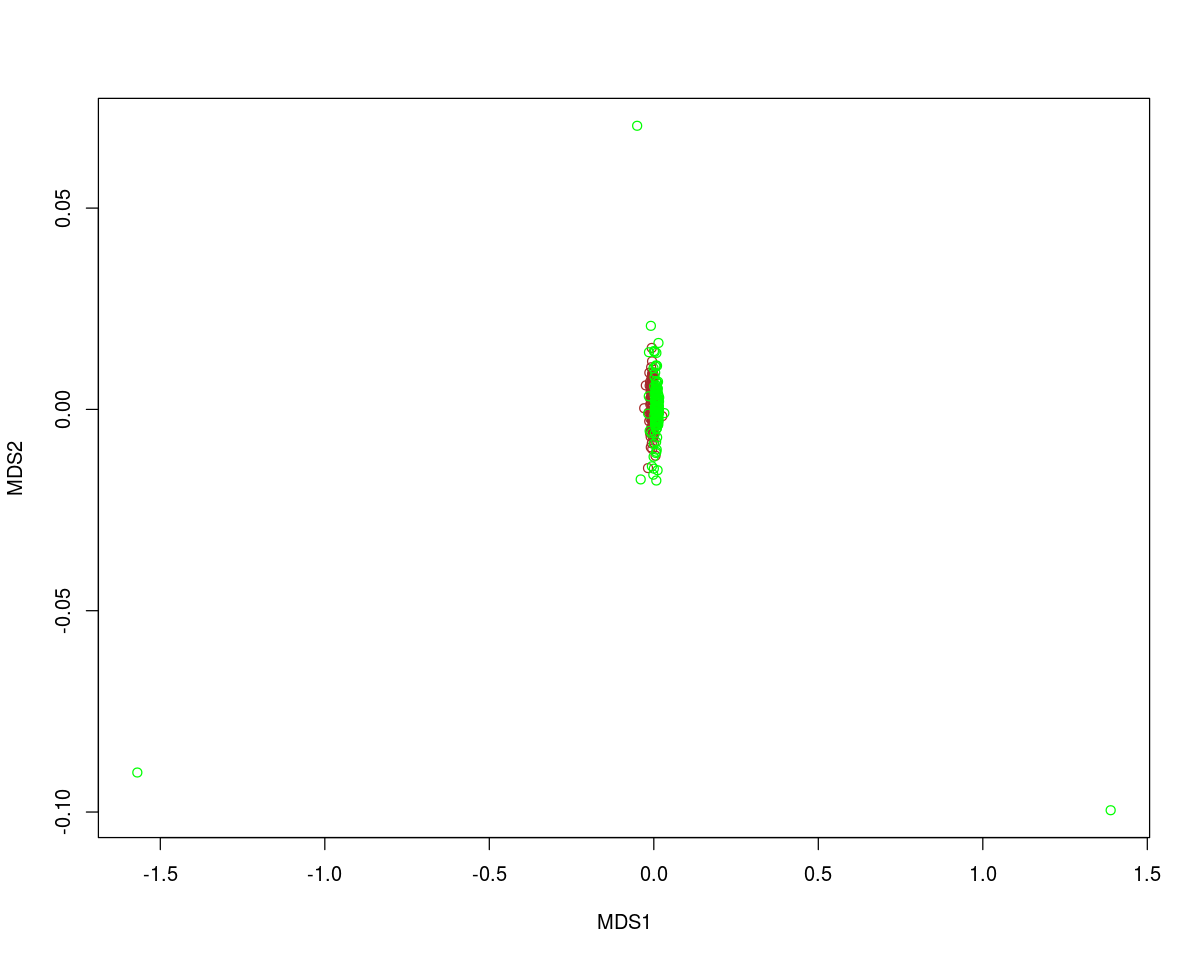

In [231]:
plot(WvsL$points, col=color)

<a id='WLNMS'></a>

As per usual, there are several outliers, including the two samples that we found above as outliers. Zoom in beyond them... 

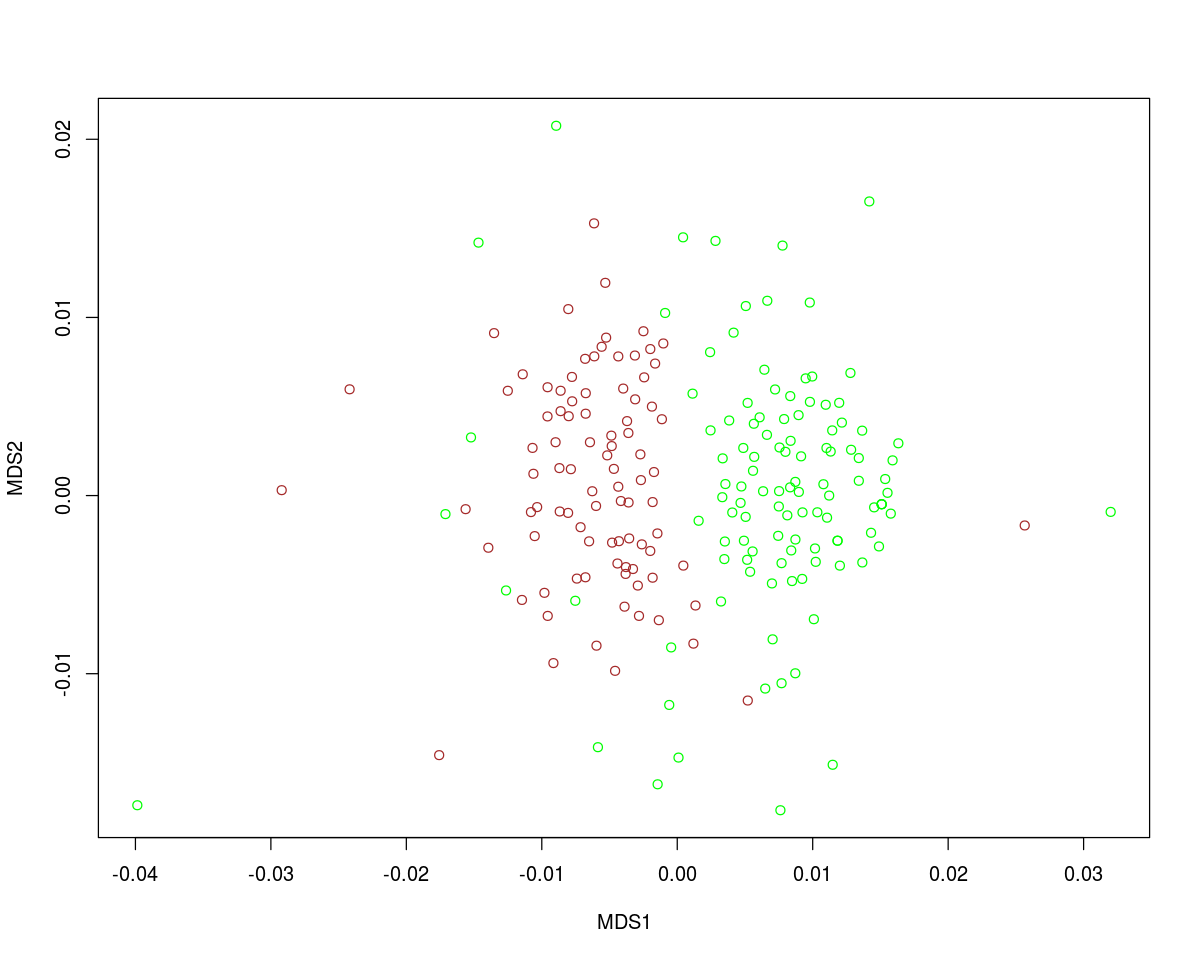

In [232]:
plot(WvsL$points[-c(107,137,173),], col=color[-c(107,137,173)])

Pretty clear separation, even when we constrain our ordination to just species that are shared. Model it with permanova:

In [233]:
WvsLmod <- adonis(nmsmat ~ color, permutations=10000)

In [234]:
WvsLmod


Call:
adonis(formula = nmsmat ~ color, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)    
color       1    11.965 11.9650  34.538 0.14359 9.999e-05 ***
Residuals 206    71.365  0.3464         0.85641              
Total     207    83.330                 1.00000              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

So even within species of fungi found only in both of our libraries, we find that leaf and wood endophyte communities seem to be somewhat distinct. This is probably a conservative model, because we are looking at fungi that may be generalists, they have appeared in both types of plant tissue. Also we are not able to take read abundances into account. The reality probably lies somewhere between the two positions, there is a definite difference between wood and leaf communities, but we have probably created some artificial differences from doing separate library preps and sequencer runs. 

<a id='hostord'></a>

### Host NMS/PermANOVA

Start with **wood** communities:

In [113]:
woodbiom  <- subset_samples(deseq95, Library=='W')
woodOTU <- otu_table(woodbiom)
wood <- t(woodOTU@.Data) ## transpose, default phyloseq uses otus as rows
wood_data <- sample_data(woodbiom)
WoodMDS <- metaMDS(wood)

Wisconsin double standardization
Run 0 stress 0.2823399 
Run 1 stress 0.2741476 
... New best solution
... Procrustes: rmse 0.08483421  max resid 0.2606421 
Run 2 stress 0.2867258 
Run 3 stress 0.284313 
Run 4 stress 0.2717112 
... New best solution
... Procrustes: rmse 0.05501814  max resid 0.268618 
Run 5 stress 0.2771693 
Run 6 stress 0.2814238 
Run 7 stress 0.2729783 
Run 8 stress 0.273142 
Run 9 stress 0.2831328 
Run 10 stress 0.2758152 
Run 11 stress 0.2737853 
Run 12 stress 0.2727623 
Run 13 stress 0.2764486 
Run 14 stress 0.2746532 
Run 15 stress 0.2733928 
Run 16 stress 0.2748617 
Run 17 stress 0.2727637 
Run 18 stress 0.2764795 
Run 19 stress 0.2720801 
... Procrustes: rmse 0.02674999  max resid 0.1986123 
Run 20 stress 0.2933577 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


Stress is pretty high, but still under .3, let's look at it. There are 93 samples, but only 30 species of tree hosts for the wood data. We need a factor that assigns each row to it's respective host tree species ('hostspp'), and to generate a palette. 

In [159]:
samps <- table(wood_data$Host_genus_species)
spp <- names(samps)
hostspp <- sapply(wood_data$Host_genus_species, FUN= function(x){which(spp == x)})
n <- length(spp)
palette <- distinctColorPalette(n)

What do our samples sizes look like for each tree host?

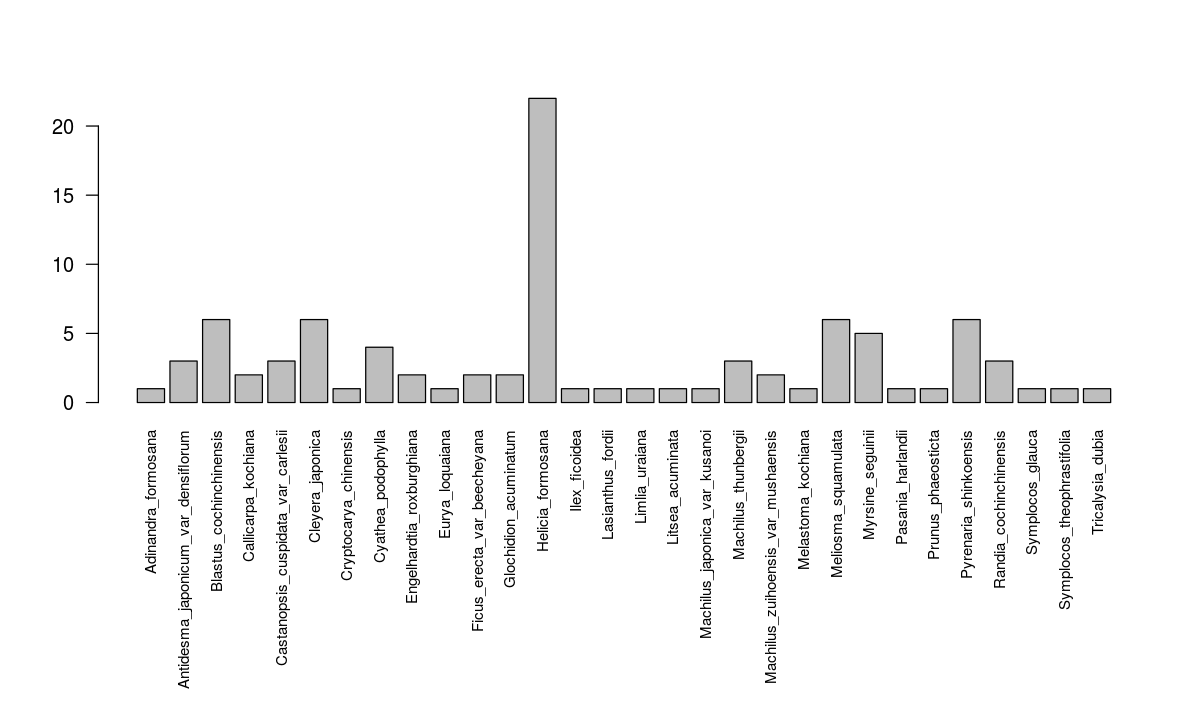

In [169]:
options(repr.plot.width = 10,repr.plot.height = 6)
par(oma=c(8,0,0,0))
barplot(samps, las=2, cex.names=.75)

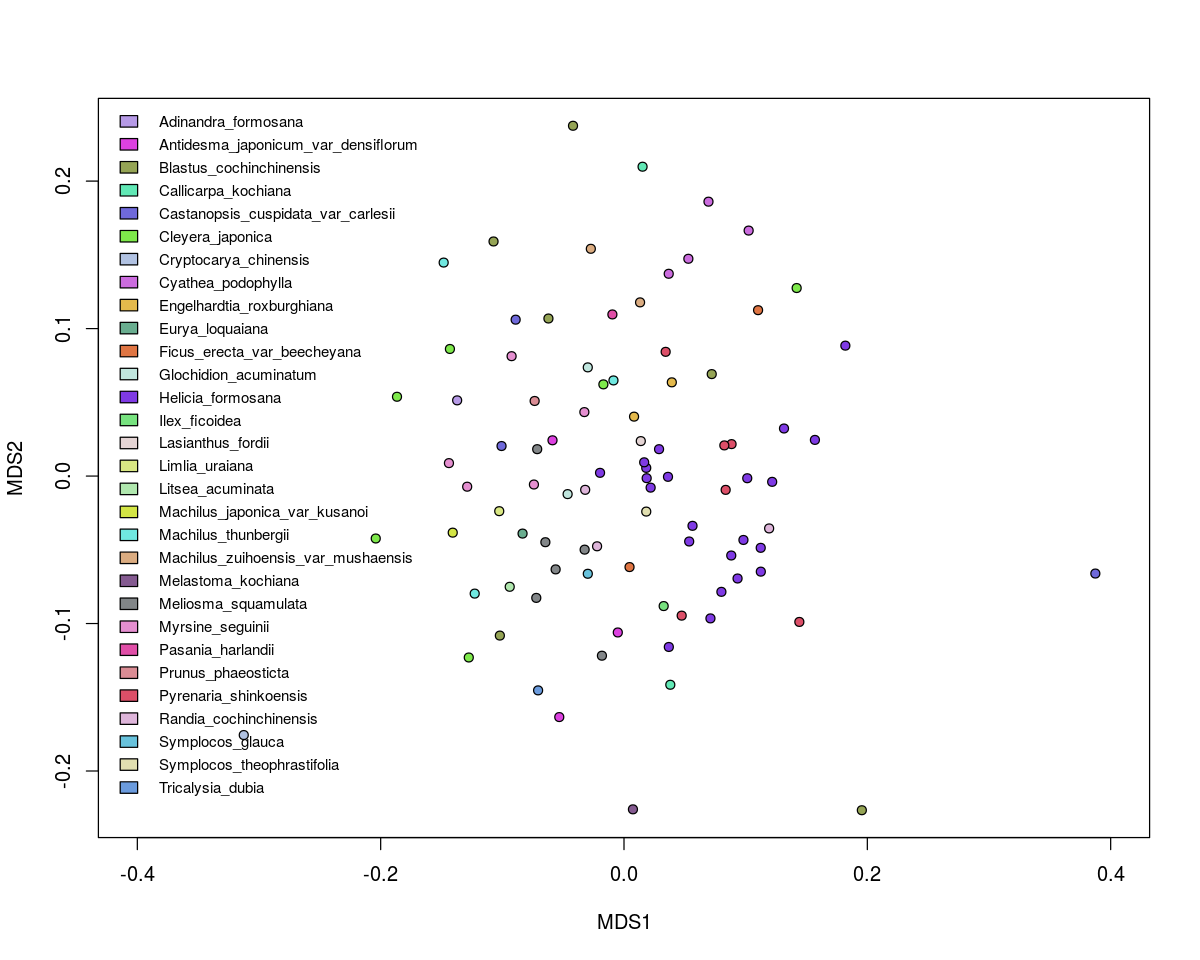

In [166]:
plot(WoodMDS$points,
    bg=palette[hostspp],
    col='black',
    pch=21,
    xlim=c(-0.4,0.4)
    )
legend('topleft',
        legend=spp,
        fill=palette,
        cex=.75,
        bty='n')

Suggestive, looks like some host communities are grouping together. We have a lot of low-sample hosts, we can remove host trees with less than 3 samples from the graphic to clear things up a bit. 

In [170]:
hisamps <- samps[samps > 2] ## only hosts with >2 samples
hihosts <- wood_data$Host_genus_species %in% names(hisamps)
## make new groups/color palette
hispp <- names(hisamps)
hihostspp <- sapply(wood_data$Host_genus_species[hihosts], FUN= function(x){which(hispp == x)})
n <- length(hispp)
palette <- distinctColorPalette(n)

Plot this, also with some [hulls](http://cc.oulu.fi/~jarioksa/softhelp/vegan/html/ordihull.html) to clarify the groups.

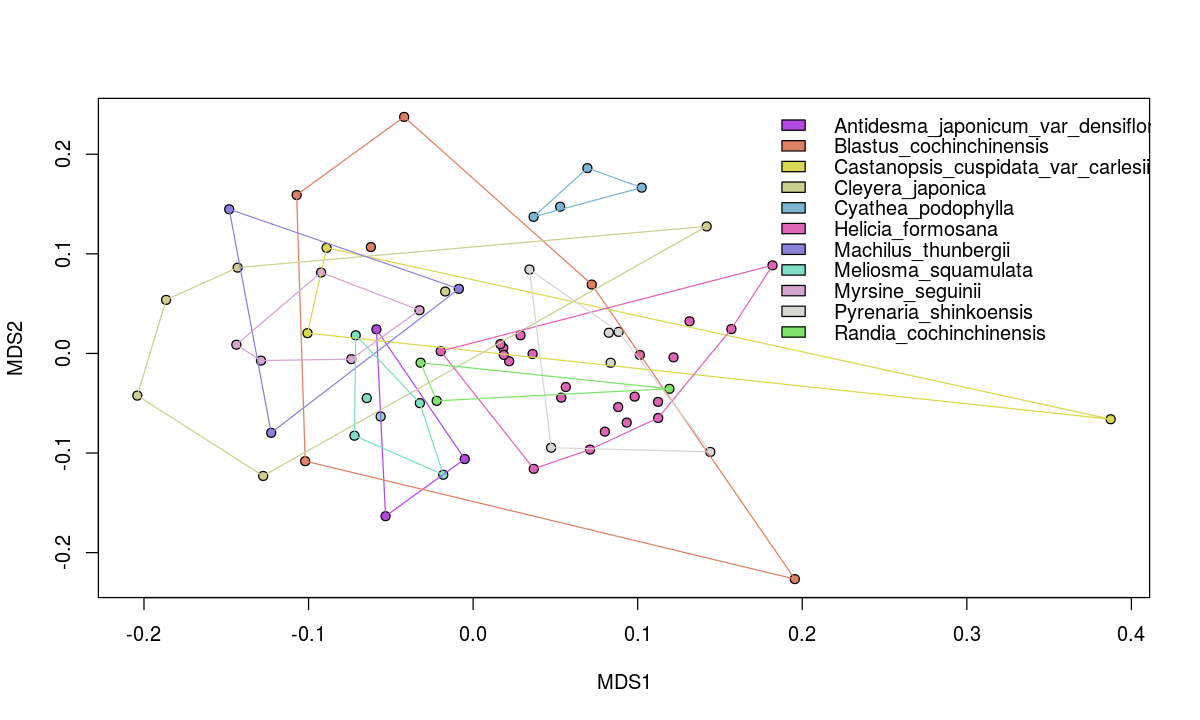

In [179]:
plot(WoodMDS$points[hihosts,],
        col="black",
        pch = 21,
        bg = palette[hihostspp]
)
legend( x=0.17, y=0.25,
        legend=hispp,
        fill=palette,
        bty='n')

## hulls have to be drawn one by one if we use ordihull():
for(i in 1:length(hispp)){
ordihull(WoodMDS, groups=wood_data$Host_genus_species, show.groups=hispp[i], col=palette[i])
}


With these we can see that some grouping seems to be happening by host. 
Test/quantify this with a [permANOVA](http://onlinelibrary.wiley.com/doi/10.1111/j.1442-9993.2001.01070.pp.x/full) using the [adonis](http://cc.oulu.fi/~jarioksa/softhelp/vegan/html/adonis.html) function. 

In [135]:
testwoodhost <- adonis(wood ~ wood_data$Host_genus_species, permutations=10000)

In [136]:
testwoodhost


Call:
adonis(formula = wood ~ wood_data$Host_genus_species, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                             Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)    
wood_data$Host_genus_species 29    16.043 0.55320  1.4865 0.41407 9.999e-05 ***
Residuals                    61    22.701 0.37215         0.58593              
Total                        90    38.744                 1.00000              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Well, that's interesting. Strong effect by host species within wood samples. However, since we have variable numbers of samples from each host, we want to make sure that these differences among groups aren't due to dispersion (which often increases with sample size) alone. Let's test the variation with [betadisper](http://cc.oulu.fi/~jarioksa/softhelp/vegan/html/betadisper.html).

In [156]:
dis <- vegdist(wood)
disp <- betadisper(dis, hostspp)
anova(disp) ## still significantly different

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,29,3.7202552,0.128284663,51.20996,7.01686e-33
Residuals,61,0.1528094,0.002505072,NA,NA


So we have statistically significant differences in dispersion among the groups by host. Differences in dispersion are interesting among groups of ~ equal sample size, but not as informative when comparing groups of differing sample size. What are our sample sizes?

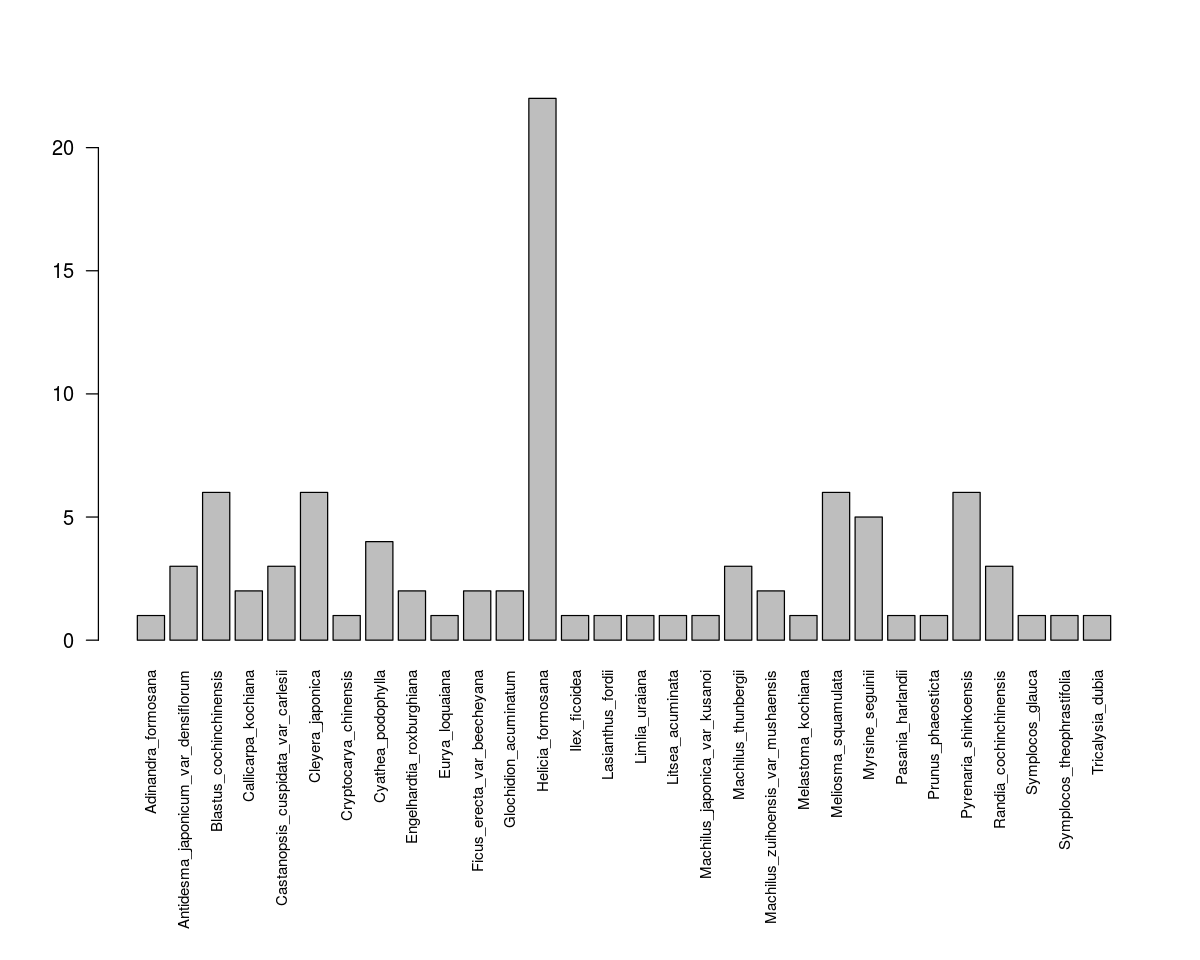

In [137]:
options(repr.plot.width = 10,repr.plot.height = 8)
par(oma=c(8,0,0,0))
barplot(samps, las=2, cex.names=.75)

What happens to our groupings when we just examine groups with more equal numbers of samples?

In [143]:
sampsmid <- names(samps[samps > 2 & samps < 10]) ## not many, enough to ordinate?
woodmidbiom  <- subset_samples(deseq95, Library=='W' & Host_genus_species %in% sampsmid)
woodmidOTU <- otu_table(woodmidbiom)
woodmid <- t(woodmidOTU@.Data)
woodmid_data <- sample_data(woodmidbiom)
woodmidMDS <- metaMDS(woodmid)

Wisconsin double standardization
Run 0 stress 0.2388575 
Run 1 stress 0.2415043 
Run 2 stress 0.2395026 
Run 3 stress 0.2535783 
Run 4 stress 0.2363924 
... New best solution
... Procrustes: rmse 0.1083349  max resid 0.3009225 
Run 5 stress 0.2441897 
Run 6 stress 0.2401051 
Run 7 stress 0.2347044 
... New best solution
... Procrustes: rmse 0.09450859  max resid 0.300067 
Run 8 stress 0.2463296 
Run 9 stress 0.2265351 
... New best solution
... Procrustes: rmse 0.06268331  max resid 0.3277037 
Run 10 stress 0.2449425 
Run 11 stress 0.2266479 
... Procrustes: rmse 0.01838375  max resid 0.09686707 
Run 12 stress 0.2348959 
Run 13 stress 0.2375988 
Run 14 stress 0.2265169 
... New best solution
... Procrustes: rmse 0.00276396  max resid 0.01528368 
Run 15 stress 0.2268301 
... Procrustes: rmse 0.01115153  max resid 0.04966065 
Run 16 stress 0.2344772 
Run 17 stress 0.2406002 
Run 18 stress 0.2295336 
Run 19 stress 0.2295097 
Run 20 stress 0.2379455 
*** No convergence -- monoMDS stopping 

Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”

In [181]:
testwoodmidhost <- adonis(woodmid ~ woodmid_data$Host_genus_species, permutations=10000)

testwoodmidhost


Call:
adonis(formula = woodmid ~ woodmid_data$Host_genus_species, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                                Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)
woodmid_data$Host_genus_species  9     5.778 0.64200  1.6597 0.29911 9.999e-05
Residuals                       35    13.539 0.38683         0.70089          
Total                           44    19.317                 1.00000          
                                   
woodmid_data$Host_genus_species ***
Residuals                          
Total                              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Still very significant. How is the dispersal?:

In [147]:
dis <- vegdist(woodmid)
disp <- betadisper(dis, hostspp)
anova(disp) ## still significantly different

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,9,0.07790768,0.008656409,2.809592,0.01355293
Residuals,35,0.10783570,0.003081020,NA,NA


Still unequal dispersion. But it's pretty apparent from the NMS that groups are distinct despite unequal sample sizes and dispersions. I think these models are valid enough, though they aren't taking spatial/habitat effects into account. As in, are these communities similar just due to the fact that their hosts tend to occur in particular habitats and tend to be found close together? To attempt to understand the relative influence of host, habitat, and neutral/spatial effects, we'll model our leaf and wood endophyte system using variation partitioning, [below](#).  

Presence/absence same pipeline as above produces an almost identical ordination and permANOVA model. 

<a id='leafhost'></a>

**Leaf/Host effects** 

Repeat the above code with leaf data:

In [186]:
load('deseq95.rda')

In [188]:
leafbiom  <- subset_samples(deseq95, Library=='L')
leafOTU <- otu_table(leafbiom)
leaf <- t(leafOTU@.Data)
leaf_data <- sample_data(leafbiom)
leafMDS <- metaMDS(leaf)

Wisconsin double standardization
Run 0 stress 0.1221576 
Run 1 stress 0.1214475 
... New best solution
... Procrustes: rmse 0.05287136  max resid 0.3222598 
Run 2 stress 0.1217825 
... Procrustes: rmse 0.02290089  max resid 0.1308918 
Run 3 stress 0.121318 
... New best solution
... Procrustes: rmse 0.03274478  max resid 0.2598241 
Run 4 stress 0.1224614 
Run 5 stress 0.1211884 
... New best solution
... Procrustes: rmse 0.008146457  max resid 0.03044356 
Run 6 stress 0.1211978 
... Procrustes: rmse 0.05213542  max resid 0.4215468 
Run 7 stress 0.1218093 
Run 8 stress 0.1215647 
... Procrustes: rmse 0.02116344  max resid 0.121374 
Run 9 stress 0.1221099 
Run 10 stress 0.1221056 
Run 11 stress 0.1211952 
... Procrustes: rmse 0.04478121  max resid 0.413998 
Run 12 stress 0.1214217 
... Procrustes: rmse 0.05437341  max resid 0.3744916 
Run 13 stress 0.1215907 
... Procrustes: rmse 0.05775591  max resid 0.4482714 
Run 14 stress 0.1221614 
Run 15 stress 0.121241 
... Procrustes: rmse 0.0343

Stresses much lower. Look at it:

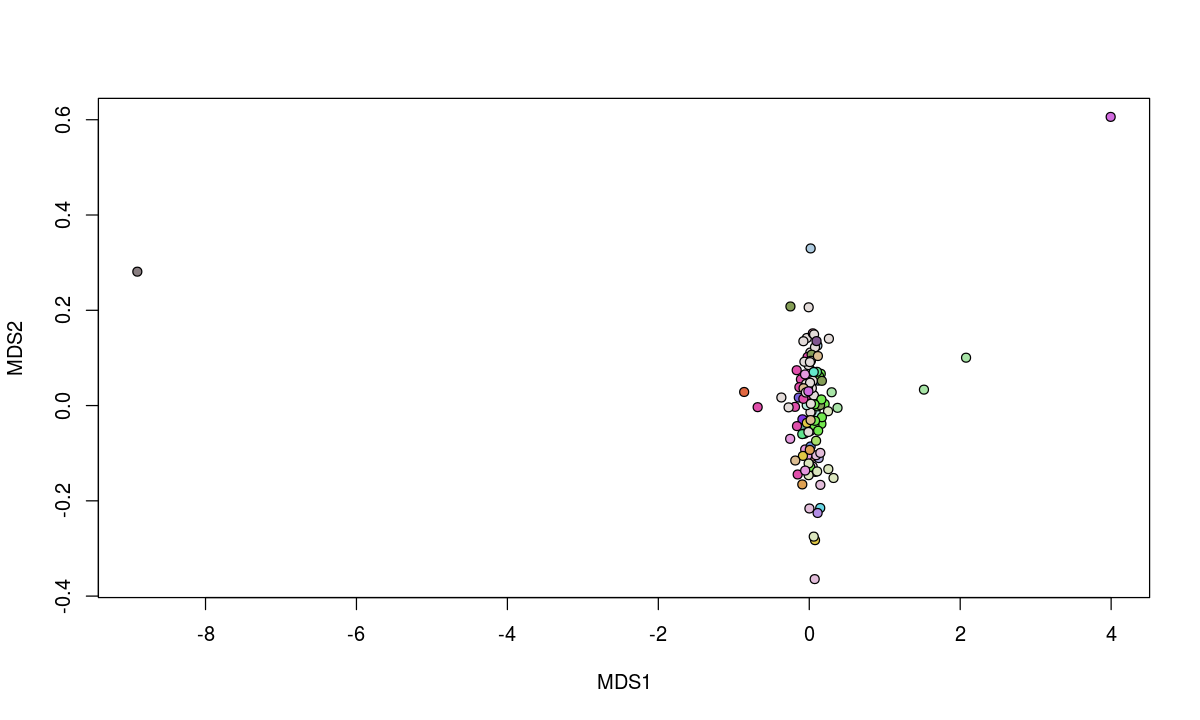

In [193]:
## host groups/colors
samps <- table(leaf_data$Host_genus_species)
spp <- names(samps)
hostspp <- sapply(leaf_data$Host_genus_species, FUN= function(x){which(spp == x)})
#spp == sort(unique(leaf_data$Host_genus_species)) ## yup, table function does this
n <- length(spp)
palette <- distinctColorPalette(n)

plot(leafMDS$points,
        col="black",
        pch = 21,
        bg = palette[hostspp]
)

Weird outliers again. We'll want to look at these sometime, but for now, zoom in a little, by excluding them.

In [195]:
#identify(leafMDS$points) ## hunt them down with mouse
leafMDS$points[c(78,123),] 

,MDS1,MDS2
61Leaf,-8.903558,0.2811270
67Leaf,3.993794,0.6060444


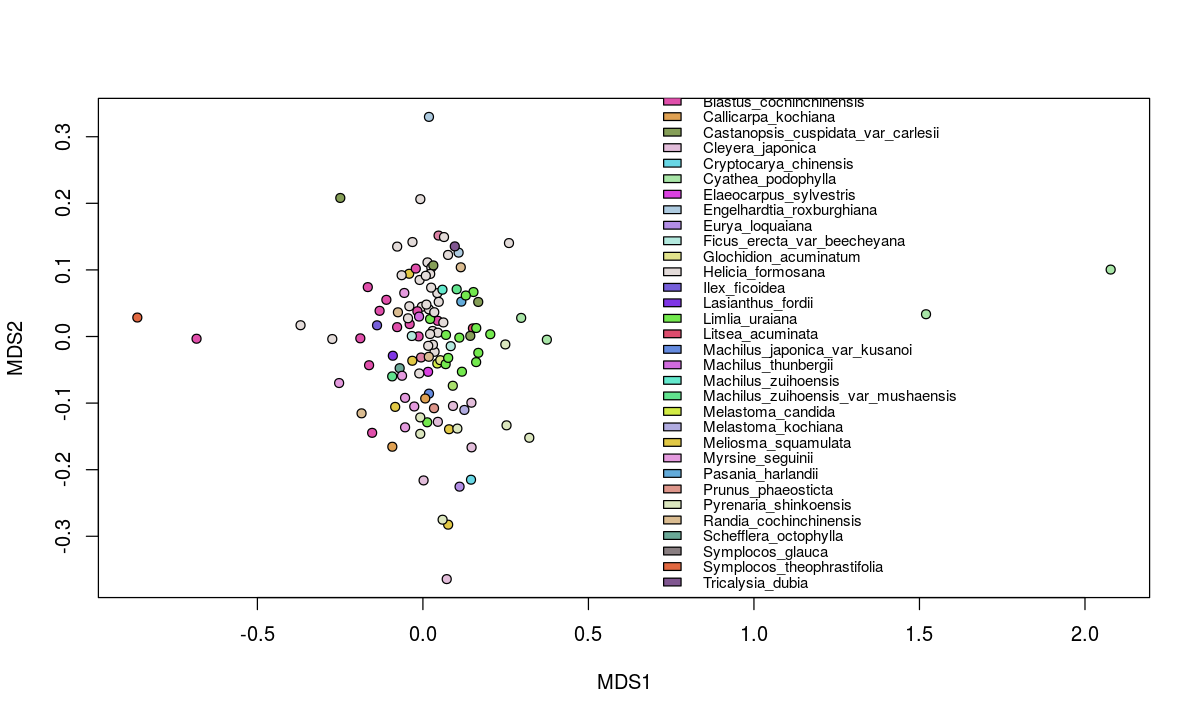

In [200]:
plot(leafMDS$points[-c(78,123),],
        col="black",
        pch = 21,
        bg = palette[hostspp[-c(78,123)]]
)

legend('bottomright',
        legend=spp,
        fill=palette,
        cex=.75,
        bty='n')

Again, suggestive. Test groupings:

In [203]:
testleafhost <- adonis(leaf ~ leaf_data$Host_genus_species, permutations=10000)
testleafhost


Call:
adonis(formula = leaf ~ leaf_data$Host_genus_species, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                              Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)
leaf_data$Host_genus_species  33    22.566 0.68381  2.1017 0.43797 9.999e-05
Residuals                     89    28.958 0.32537         0.56203          
Total                        122    51.523                 1.00000          
                                
leaf_data$Host_genus_species ***
Residuals                       
Total                           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Highly significant effect by host. This is hard to see with the above NMS, so let's repeat the above visualization pipeline for just tree hosts for which we have at least 3 samples. 

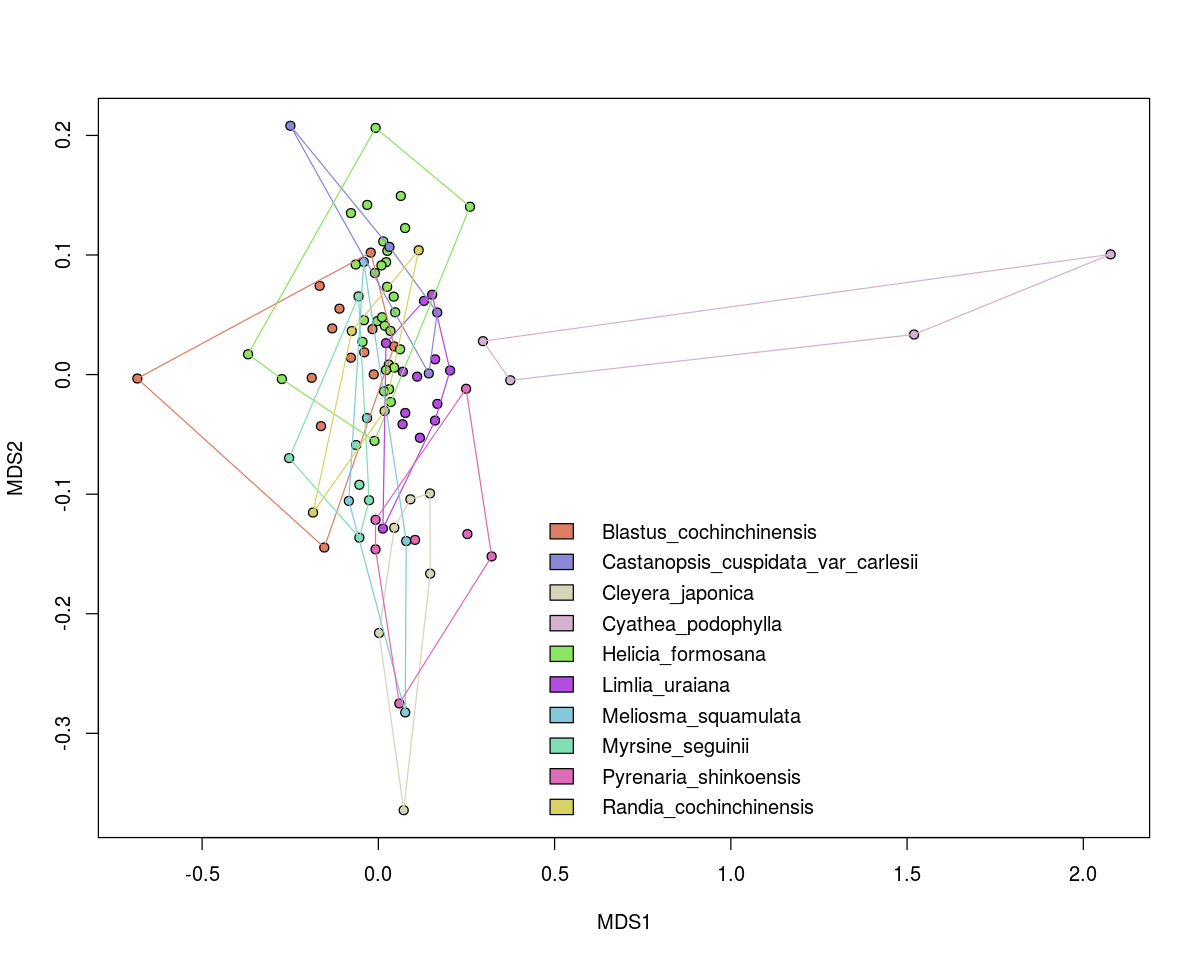

In [206]:
hisamps <- samps[samps > 2]
hihosts <- leaf_data$Host_genus_species %in% names(hisamps)
## reassign colors
hispp <- names(hisamps)
hihostspp <- sapply(leaf_data$Host_genus_species[hihosts], FUN= function(x){which(hispp == x)})
n <- length(hispp)
palette <- distinctColorPalette(n)

options(repr.plot.width = 10,repr.plot.height = 8)

plot(leafMDS$points[hihosts,],
        col="black",
        pch = 21,
        bg = palette[hihostspp]
)
legend('bottomright',
        legend=hispp,
        fill=palette,
        bty='n')

for(i in 1:length(hispp)){
ordihull(leafMDS, groups=leaf_data$Host_genus_species, show.groups=hispp[i], col=palette[i])
}

<a id='otherperms'></a>

###  PERMANOVA models of environmental variables:

We have some environmental data, that were supplied to us by Dr. Su and his colleagues at the botanical reserve. We've included them in our metadata, so we can look at these:

In [241]:
head(sample_data(deseq95), n=2)

,Host_genus,Library,stream_distance,Host_genus_species,X,Forest_Type,Host_species,vegcom,SampleNumber,Y,SorC,Host_family
164wood,Engelhardtia,W,24.11897,Engelhardtia_roxburghiana,360,7,roxburghiana,2,1,220,Sample,Juglandaceae
165wood,Pyrenaria,W,23.22664,Pyrenaria_shinkoensis,360,7,shinkoensis,2,2,221,Sample,Theaceae


"Forest_type" is a composite variable of numerous very localized topographical measurements taken from each point, which Dr. Su et al. have written about [here](http://tai2.ntu.edu.tw/taiwania/pdf/tai.2013.58.35.pdf). Vegcom is a four-category classification of the above-ground woody plant community at each site of the Fushan FDP, written about in the [Fushan FDP manual](http://fushan.tfri.gov.tw/en/images/download/Fushan%20Subtropical%20Forest%20Dynamics%20Plot.pdf). Distance to stream is a variable the Roo and I generated from GIS data. It is a little problematic to use a spatial variable as a continuous, uncorrected term in a pseudo-linear model like PERMANOVA, but we'll look at it anyway. 

<a id='woodotherperms'></a>

**Wood**

In [242]:
## get wood matrix:
wood95 <- subset_samples(deseq95, Library=="W")
woodOTU <- otu_table(wood95) ## otus are rows
wood <- t(woodOTU@.Data) ## transpose so samples are rows
all(rownames(sample_data(wood95)) == rownames(wood)) 

[1] TRUE

In [244]:
woodmod_VC <- adonis(wood ~ sample_data(wood95)$vegcom, permutations=10000)
woodmod_FT <- adonis(wood ~ sample_data(wood95)$Forest_Type, permutations=10000)
woodmod_SD <- adonis(wood ~ as.numeric(sample_data(wood95)$stream_distance), permutations=10000)

Look at these. Wood endophyte community as a function of plant community:

In [245]:
woodmod_VC 


Call:
adonis(formula = wood ~ sample_data(wood95)$vegcom, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                           Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)    
sample_data(wood95)$vegcom  3     1.945 0.64821  1.5325 0.05019 9.999e-05 ***
Residuals                  87    36.799 0.42298         0.94981              
Total                      90    38.744                 1.00000              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

============================================================================  
Wood endophyte community as a function of microtopography ("Forest type"):

In [246]:
woodmod_FT


Call:
adonis(formula = wood ~ sample_data(wood95)$Forest_Type, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                                Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)
sample_data(wood95)$Forest_Type  6     3.247 0.54121  1.2807 0.08381 9.999e-05
Residuals                       84    35.497 0.42258         0.91619          
Total                           90    38.744                 1.00000          
                                   
sample_data(wood95)$Forest_Type ***
Residuals                          
Total                              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

============================================================================  
Wood endophyte community as a function of distance-to-nearest-stream:

In [247]:
woodmod_SD


Call:
adonis(formula = wood ~ as.numeric(sample_data(wood95)$stream_distance),      permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                                                Df SumsOfSqs MeanSqs F.Model
as.numeric(sample_data(wood95)$stream_distance)  1     0.622 0.62187  1.4518
Residuals                                       89    38.122 0.42834        
Total                                           90    38.744                
                                                     R2 Pr(>F)   
as.numeric(sample_data(wood95)$stream_distance) 0.01605 0.0046 **
Residuals                                       0.98395          
Total                                           1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

===============================================================================

These environmental variables seem to have an effect on our endophyte communities, but it seems like host is the biggest predictor that we have by far. 

<a id='leafotherperms'></a>

### Leaves

In [249]:
leaf95 <- subset_samples(deseq95, Library=="L")
leafOTU <- otu_table(leaf95) ## otus are rows
leaf <- t(leafOTU@.Data) ## transpose so samples are rows

In [250]:
leafmod_VC <- adonis(leaf ~ sample_data(leaf95)$vegcom, permutations=10000)
leafmod_FT <- adonis(leaf ~ sample_data(leaf95)$Forest_Type, permutations=10000)
leafmod_SD <- adonis(leaf ~ as.numeric(sample_data(leaf95)$stream_distance), permutations=10000)

Leaf endophyte community as a function of plant community:

In [251]:
leafmod_VC


Call:
adonis(formula = leaf ~ sample_data(leaf95)$vegcom, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                            Df SumsOfSqs MeanSqs F.Model     R2    Pr(>F)    
sample_data(leaf95)$vegcom   3     2.700 0.89993  2.1934 0.0524 9.999e-05 ***
Residuals                  119    48.824 0.41028         0.9476              
Total                      122    51.523                 1.0000              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

============================================================================  
Leaf endophyte community as a function of microtopography ("Forest type"):

In [252]:
leafmod_FT


Call:
adonis(formula = leaf ~ sample_data(leaf95)$Forest_Type, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                                 Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)   
sample_data(leaf95)$Forest_Type   6     3.265 0.54411  1.3079 0.06336 0.0016 **
Residuals                       116    48.259 0.41602         0.93664          
Total                           122    51.523                 1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

============================================================================  
Leaf endophyte community as a function of distance-to-nearest-stream:

In [253]:
leafmod_SD


Call:
adonis(formula = leaf ~ as.numeric(sample_data(leaf95)$stream_distance),      permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                                                 Df SumsOfSqs MeanSqs F.Model
as.numeric(sample_data(leaf95)$stream_distance)   1     0.942 0.94151  2.2522
Residuals                                       121    50.582 0.41803        
Total                                           122    51.523                
                                                     R2 Pr(>F)    
as.numeric(sample_data(leaf95)$stream_distance) 0.01827  2e-04 ***
Residuals                                       0.98173           
Total                                           1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

===============================================================================

Very similar to wood endophyte responses. We'll need to disentangle spatial effects, and these dissimilarity-distance-based methods are a little underpowered for determining interactions among variables, etc, so we'll use variance-partitioning methods later to get at this. 

<a id='cooc'></a>

## Cooccurrence networks

In order to see which particular fungi may be behind the dissimilar communities of endophytes within each host and tissue type, let's take a look at some cooccurrence network models of these communities. To define the edges in our network graphs, we'll use a simple probabilistic model based on [Veech et al.](#http://onlinelibrary.wiley.com/doi/10.1111/j.1466-8238.2012.00789.x/full). I prefer this to correlation of read abundances or checkerboard scores as definitions for edges, it is computationally simple and makes more sense to me intuitively. 

<a id='woodcooc'></a>

### Wood endophyte cooccurrence networks

Let's seek if there are any strong cooccurrence relationships in the wood endophytes. First, some reformatting of data is necessary. We are looking to see if any wood endophytes are particularly "loyal" to a given host, so we need a single matrix of both wood endophyte OTUs and hosts, and which sites they occur at. We have this info in a general dataframe which I constructed of our site data oh-so-many-years ago. Load it here, and mess around with it to fit our formatting needs:

In [11]:
## get the necessary data objects
load('tp.rda') ## our site dataframe
load('deseq95.rda') ## our variance-stabilized biom
wood95 <- subset_samples(deseq95, Library=="W") ## subset biom to wood
woodOTU <- otu_table(wood95) ## taxa are rows.

In [12]:
head(tp)

Sample_ID,xx,yy,Host_family,Host_genus,Host_species,stream_distance,vegcom,vegtopo,coords.x1,coords.x2,optional,Host_genus_species
1,360,220,Juglandaceae,Engelhardtia,roxburghiana,24.11897,2,7,360,220,TRUE,Engelhardtia_roxburghiana
2,360,221,Theaceae,Pyrenaria,shinkoensis,23.22664,2,7,360,221,TRUE,Pyrenaria_shinkoensis
3,361,221,Proteaceae,Helicia,formosana,22.77525,2,7,361,221,TRUE,Helicia_formosana
4,361,220,Theaceae,Pyrenaria,shinkoensis,23.66758,2,7,361,220,TRUE,Pyrenaria_shinkoensis
5,363,220,Theaceae,Pyrenaria,shinkoensis,22.76480,2,7,363,220,TRUE,Pyrenaria_shinkoensis
6,363,223,Proteaceae,Helicia,formosana,20.08782,2,7,363,223,TRUE,Helicia_formosana


We want a matrix of host by site, which gives us a presence/absence value for each host at each site. [model.matrix()](#https://stat.ethz.ch/R-manual/R-devel/library/stats/html/model.matrix.html) is useful for this. 

In [21]:
hostmat <- model.matrix(~0+Host_genus_species+Sample_ID,data=tp)

In [22]:
hostmat[1:2,1:2]; hostmat[1:2,34:35]

,Host_genus_speciesAdinandra_formosana,Host_genus_speciesAntidesma_japonicum_var_densiflorum
1,0,0
2,0,0


,Host_genus_speciesTricalysia_dubia,Sample_ID
1,0,1
2,0,2


Clean up the column names and get rid of the Sample_ID (last) column. Transpose, because we want organisms as our rows, and site as our columns.

In [23]:
hostmat <- hostmat[,-35]
colnames(hostmat) <- gsub('Host_genus_species','',colnames(hostmat))
hostmat <- t(hostmat)

Now  looks like this:

In [27]:
hostmat[1:2,1:15]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Adinandra_formosana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Antidesma_japonicum_var_densiflorum,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


This dataframe has information about all of the sites in the study, but the wood samples were only successuly at 91 out of 133 sites. So we need to subset our columns. We also need to rename our wood OTU matrix column names, right now they are named for the illumina sample number, not their real site/plot number. 

In [28]:
## Illumina sample numbers as column names. Fix this. 
colnames(woodOTU) <- sample_data(wood95)$SampleNumber

In [29]:
## subset columns in our host matrix
hostmat <- hostmat[,colnames(hostmat) %in% colnames(woodOTU)]
## drop the zero rows:
hostmat <- hostmat[rowSums(hostmat)>0,]

In [31]:
## check, do column names and order match up?
all(colnames(hostmat) == colnames(woodOTU))
dim(hostmat)
dim(woodOTU)

[1] TRUE

[1] 30 91

[1] 2051   91

Stack our host and wood OTUs:

In [35]:
host_woodOTU_mat <- rbind(hostmat, woodOTU)
host_woodOTU_mat[host_woodOTU_mat > 0] <- 1 

In [36]:
#save(host_woodOTU_mat, file="host_woodOTU_mat.rda")

Now that we have a presence/absence matrix of all of our hosts and our fungi, we can examine the relationships among these species. This is where we implement the probabilistic model of [Veech et al. 2013](#http://onlinelibrary.wiley.com/doi/10.1111/j.1466-8238.2012.00789.x/full). We'll use the R package [cooccur](#https://cran.r-project.org/web/packages/cooccur/cooccur.pdf), and especially the command "cooccur()" to create a table of probabilities that two species would be found in the same sites, under the assumption of random distribution among all sites. I have some concerns with these distributions, the usual concerns of not correcting for spatial autocorrelation, but we're going to be pretty fierce with our multiple-test corrections, this probably would have masked any adjustments we'd make for autocorrelation anyway.  

In [1]:
woodcooc <- cooccur(host_woodOTU_mat, spp_names=TRUE)

In [5]:
#save(woodcooc, 'woodcooc.2017.01.10.rda')

In [2]:
#load('woodcooc.2017.01.10.rda')

<a id='makenet'></a>

This cooccurrence object has a lot of information in it. But we're going to boil it down to the vector of probabilities of finding a two species together at the observed frequency or more often (called "p_gt" in the cooccur objects). First we calculate probabilities.

In [6]:
woodcoocP <- prob.table(woodcooc)

Warning message in prob.table(woodcooc):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”

In [7]:
head(woodcoocP, n=2)

sp1,sp2,sp1_inc,sp2_inc,obs_cooccur,prob_cooccur,exp_cooccur,p_lt,p_gt,sp1_name,sp2_name
2,73,3,45,1,0.016,1.5,0.50833,0.87505,Antidesma_japonicum_var_densiflorum,OTU97:51Leaf
2,74,3,50,3,0.018,1.6,1.00000,0.16134,Antidesma_japonicum_var_densiflorum,OTU76:116Leaf


The cooccur package also calculates "effect sizes", which are related to the ratio of expected coccurrences versus the observed. The p-values we will use are highly correlated to this, but this "effect size" measure has some directionality to it, negative numbers indicate that species seem to be avoiding each other, and positive numbers that they seem to be occurring in the same place more often than we would expect. 

In [8]:
woodcoocC <- effect.sizes(woodcooc)

For the moment, we want both of these data, the probabilities and the effect sizes.

In [9]:
woodcoocPC <- cbind(woodcoocP, woodcoocC)

This allows us to visualize the cooccurrence relationships in general:

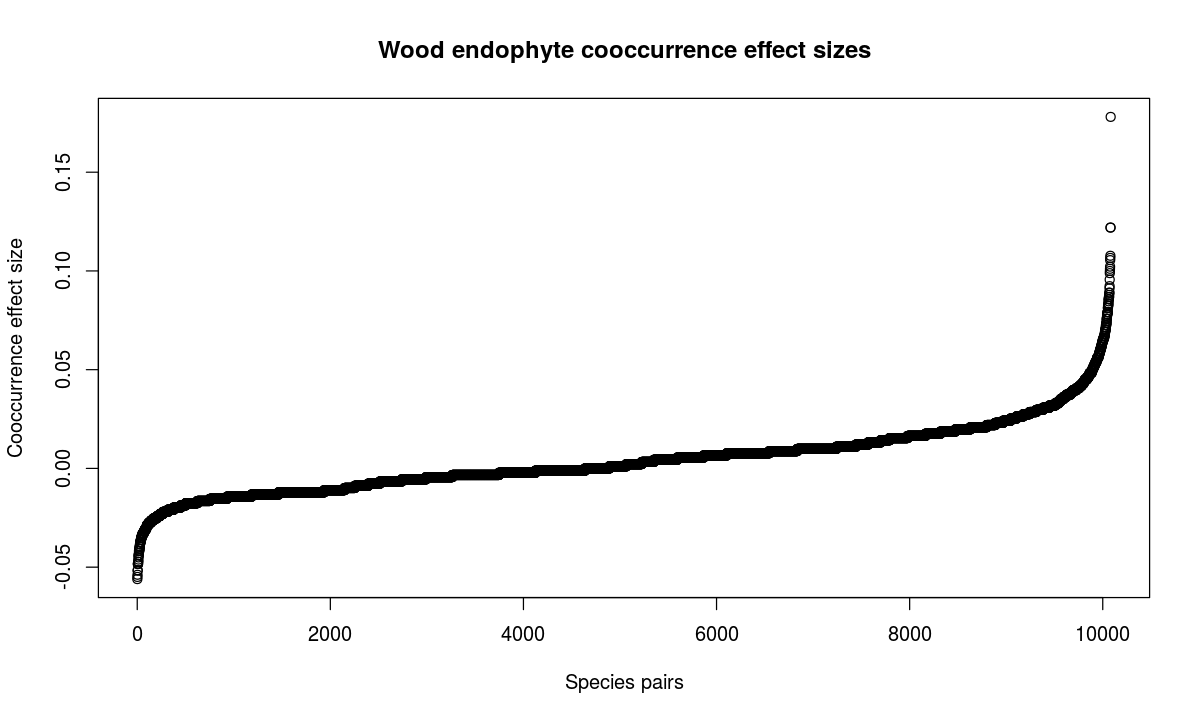

In [10]:
options(repr.plot.width = 10,repr.plot.height = 6)
plot(sort(woodcoocPC$effect), 
     xlab='Species pairs', 
     ylab = 'Cooccurrence effect size',
    main='Wood endophyte cooccurrence effect sizes')

Pretty standard sigmoidal curve, most of the species don't really seem to have effect on each other, and at either end we have some stronger negative and postive effects.

This is a massive number of tests, ~10,000. So let's correct with a benjamini-hochberg adjustment, and pick out interactions with an fdr of .05 or less. 

In [11]:
## add a corrected pvalue, benjamini-hochberg
woodcoocPC$p_gt_adj <- p.adjust(woodcoocPC$p_gt, method = "BH")

In [12]:
#save(woodcoocPC,file='woodcoocPC.rda')

In [57]:
## look for only strong effects, sig p vals
strong_woodcooc <- woodcoocPC[woodcoocPC$p_gt_adj <= 0.05,]
## clean up col names
strong_woodcooc <- strong_woodcooc[,-c(10,11)]
colnames(strong_woodcooc)[10:11] <- c('OTU_A','OTU_B')

Okay, now that we have reduced our interactions to those with an fdr below .05, what's left standing? Looking at the effect sizes:

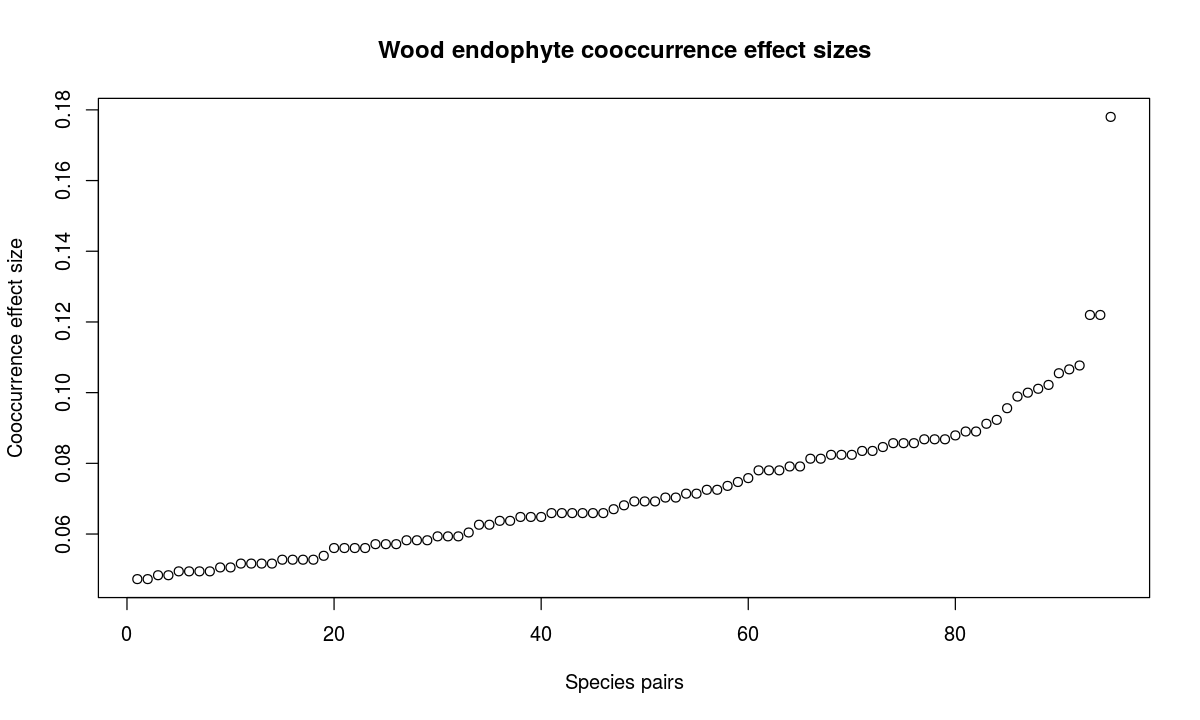

In [58]:
options(repr.plot.width = 10,repr.plot.height = 6)
plot(sort(strong_woodcooc$effect), 
    xlab='Species pairs',
    ylab = 'Cooccurrence effect size',
    main='Wood endophyte cooccurrence effect sizes')

In [26]:
dim(strong_woodcooc)

[1] 95 13

Most interactions drop off, including all negative ones (because I used the p-value associated with positive interactions, "p_gt"). Let's graph these remaining cooccurrences, using the [igraph](#http://igraph.org/r/) package.  

In [30]:
aa <- strong_woodcooc[,c(10,11,12,13)]
graphcooc_wood <- graph_from_data_frame(aa, directed=FALSE) ## quick igraph object

In [41]:
str(graphcooc_wood)

IGRAPH UN-- 75 95 -- 
+ attr: name (v/c), effects (e/n), p_gt_adj (e/n)
+ edges (vertex names):
 [1] Helicia_formosana  --OTU81:81Leaf    Helicia_formosana  --OTU284:131Leaf 
 [3] Helicia_formosana  --OTU1126:199wood Helicia_formosana  --OTU256:38Leaf  
 [5] Helicia_formosana  --OTU841:237wood  Helicia_formosana  --OTU68:55Leaf   
 [7] Helicia_formosana  --OTU65:128Leaf   Helicia_formosana  --OTU216:90Leaf  
 [9] Helicia_formosana  --OTU235:131Leaf  Helicia_formosana  --OTU113:194wood 
[11] Meliosma_squamulata--OTU164:51Leaf   OTU676:177wood     --OTU97:51Leaf   
[13] OTU676:177wood     --OTU1864:221wood OTU676:177wood     --OTU332:47Leaf  
[15] OTU195:164wood     --OTU165:119Leaf  OTU195:164wood     --OTU240:14Leaf  
[17] OTU195:164wood     --OTU223:47Leaf   OTU195:164wood     --OTU299:164wood 
[19] OTU195:164wood     --OTU431:47Leaf   OTU195:164wood     --OTU1076:169wood
[21] OTU97:51Leaf       --OTU101:93Leaf   OTU97:51Leaf       --OTU332:47Leaf  
[23] OTU97:51Leaf       --OTU359:11

*Helicia* and *Meliosma* were the only hosts in which we could detect strong cooccurrences with "loyal" fungi. 


We need a color vector for our vertices in the network, so we can tell our host trees from our fungi:

In [39]:
vcols <- vector(length = length(V(graphcooc_wood)))
vcols[] <- 'brown'
vcols[which(names(V(graphcooc_wood)) == "Helicia_formosana")] <- "red"
vcols[which(names(V(graphcooc_wood)) == "Meliosma_squamulata")] <- "blue"

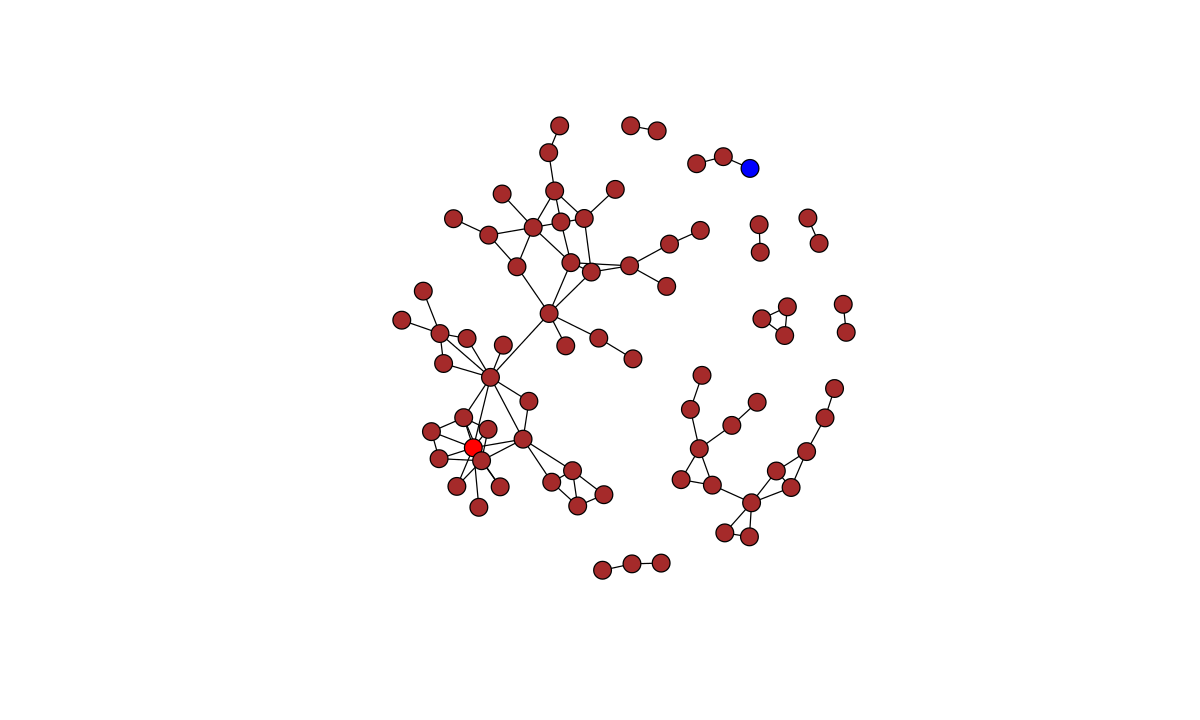

In [40]:
plot(graphcooc_wood, 
     vertex.color = vcols, 
     vertex.size = 8, 
     vertex.label = NA, 
     edge.color = 'black')

We can repeat the above pipeline, but relax the false discovery rate to 10%, to get a more forgiving glimpse at the species that may be causing the differences among the communities.

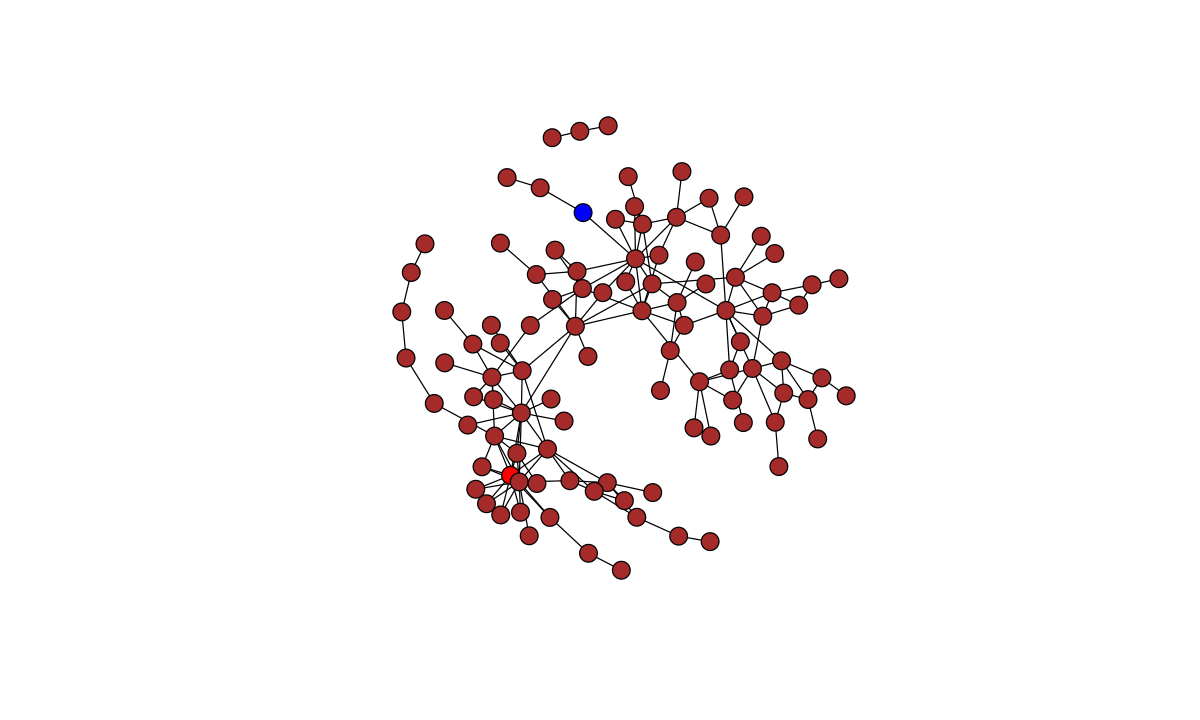

In [14]:
load('woodcoocPC.rda')
strong_woodcooc <- woodcoocPC[woodcoocPC$p_gt_adj <= 0.10,]
strong_woodcooc <- strong_woodcooc[,-c(10,11)]
colnames(strong_woodcooc)[10:11] <- c('OTU_A','OTU_B')
aa <- strong_woodcooc[,c(10,11,12,13)]
graphcooc_wood <- graph_from_data_frame(aa, directed=FALSE)
vcols <- vector(length = length(V(graphcooc_wood)))
vcols[] <- 'brown'
vcols[which(names(V(graphcooc_wood)) == "Helicia_formosana")] <- "red"
vcols[which(names(V(graphcooc_wood)) == "Meliosma_squamulata")] <- "blue"
#vcols[which(names(V(graphcooc_wood)) == "Myrsine_seguinii")] <- "yellow"
plot(graphcooc_wood, 
     vertex.color = vcols, 
     vertex.size = 8, 
     vertex.label = NA, 
     edge.color = 'black')

The trend continues when we relax the fdr to 20%, we get an increasingly complex network of cooccurring fungi. But we gain little information in terms of host affinities, it looks like the only two hosts that we really have enough data to examine in this way for wood endophytes are *Helicia* and *Meliosma*. 

We can look at the identifications given by UNITE for these. Here's a function, using the tax_table() function from phyloseq. To use it, we'll reset our FDR back down to .05. 

In [15]:
nettax <- function(net, phyl){
        require('phyloseq')
        require('igraph')
        require('cooccur')
        vertnames <- names(V(net))
        OTUS <- vertnames[grep('OTU',vertnames)] ## get rid of non-OTUs 
        tax <- tax_table(phyl)[OTUS]
        return(tax)
}

In [18]:
load('deseq95.rda')
nettax(graphcooc_wood, deseq95)

,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU825:192wood,Fungi,Ascomycota,Dothideomycetes,Capnodiales,NA,NA,NA
OTU676:177wood,Fungi,Ascomycota,Dothideomycetes,NA,NA,NA,NA
OTU81:81Leaf,Fungi,Ascomycota,Sordariomycetes,Xylariales,Amphisphaeriaceae,Pestalotiopsis,Pestalotiopsis_trachicarpicola_SH388708.07FU
OTU195:164wood,Fungi,Ascomycota,Dothideomycetes,Capnodiales,NA,NA,NA
OTU97:51Leaf,Fungi,Ascomycota,Dothideomycetes,NA,NA,NA,NA
OTU400:168wood,Fungi,Ascomycota,Dothideomycetes,Capnodiales,NA,NA,NA
OTU198:164wood,Fungi,Ascomycota,Dothideomycetes,Capnodiales,NA,NA,NA
OTU383:23Leaf,Fungi,Ascomycota,Dothideomycetes,Capnodiales,NA,NA,NA
OTU2963:203wood,Fungi,Ascomycota,Dothideomycetes,Capnodiales,NA,NA,NA
OTU339:167wood,Fungi,Ascomycota,Eurotiomycetes,Chaetothyriales,Herpotrichiellaceae,Cladophialophora,NA


Somehow, I will need to dive in and figure out which of these are close associates of hosts. 

<a id='leafcooc'></a>

### Leaf endophyte cooccurrence networks

Repeat this pipeline with the leaves. The details of creating the community matrix are a little different, otherwise network creation process is identical to the wood endophytes as above.

In [85]:
load('tp.rda') ## our site dataframe
load('deseq95.rda') ## our variance-stabilized biom
leaf95 <- subset_samples(deseq95, Library=="L") ## subset biom to leaf
leafOTU <- otu_table(leaf95) ## taxa are rows.
hostmat <- model.matrix(~0+Host_genus_species+Sample_ID,data=tp)
hostmat <- hostmat[,-35]
colnames(hostmat) <- gsub('Host_genus_species','',colnames(hostmat))
hostmat <- t(hostmat)

In [88]:
#save(hostmat, file='hostmat.rda')

The columns (samples) are out of order in the leaf half of our biom/phyloseq table, unlike the wood samples. Something to do with how I made our biom table. So order them, so we can stack our host-tree x site and leaf x site matrices in a way that makes sense. Then continue as with the wood reads.

In [40]:
## change to just sample numbers
colnames(leafOTU) <- sample_data(leaf95)$SampleNumber
## get rid of underscores:
colnames(leafOTU) <- gsub('_.*', '', colnames(leafOTU))
## order:
aa <- order(as.numeric(colnames(leafOTU)))
leafOTU <- leafOTU[,aa]
## subset columns in our host matrix
hostmat <- hostmat[,colnames(hostmat) %in% colnames(leafOTU)]
## drop the zero rows:
hostmat <- hostmat[rowSums(hostmat)>0,]
#Stack them, reduce leaf OTU reads to presence/absence:
host_leafOTU_mat <- rbind(hostmat, leafOTU)
host_leafOTU_mat[host_leafOTU_mat > 0] <- 1

In [ ]:
#save(host_leafOTU_mat, file='host_leafOTU_mat.rda')
#load('host_leafOTU_mat.rda')

Run this leaf-endophyte-and-host-by-site matrix through the cooccur/igraph pipeline, as done above with the wood library:

In [62]:
leafcooc <- cooccur(host_leafOTU_mat, spp_names=TRUE)

In [63]:
#load('leafcooc.2017.01.13.rda')

In [64]:
leafcoocP <- prob.table(leafcooc)
leafcoocC <- effect.sizes(leafcooc)
leafcoocPC <- cbind(leafcoocP, leafcoocC)

Warning message in prob.table(leafcooc):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”

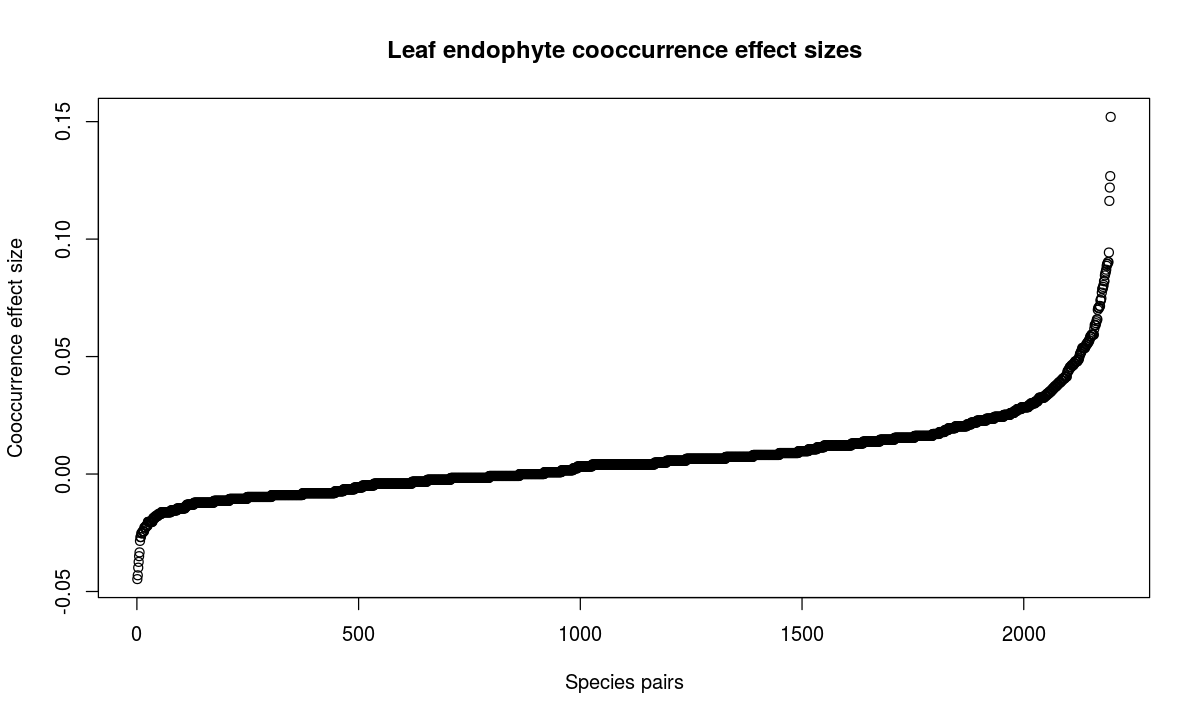

In [66]:
plot(sort(leafcoocPC$effect), 
     xlab='Species pairs',
     ylab = 'Cooccurrence effect size',
     main='Leaf endophyte cooccurrence effect sizes')

In [67]:
leafcoocPC <- leafcoocPC[,-c(10,11)]
leafcoocPC$p_gt_adj <- p.adjust(leafcoocPC$p_gt, method = "BH")
strong_leafcooc <- leafcoocPC[leafcoocPC$p_gt_adj <= 0.05,]
colnames(strong_leafcooc)[10:11] <- c('OTU_A','OTU_B')

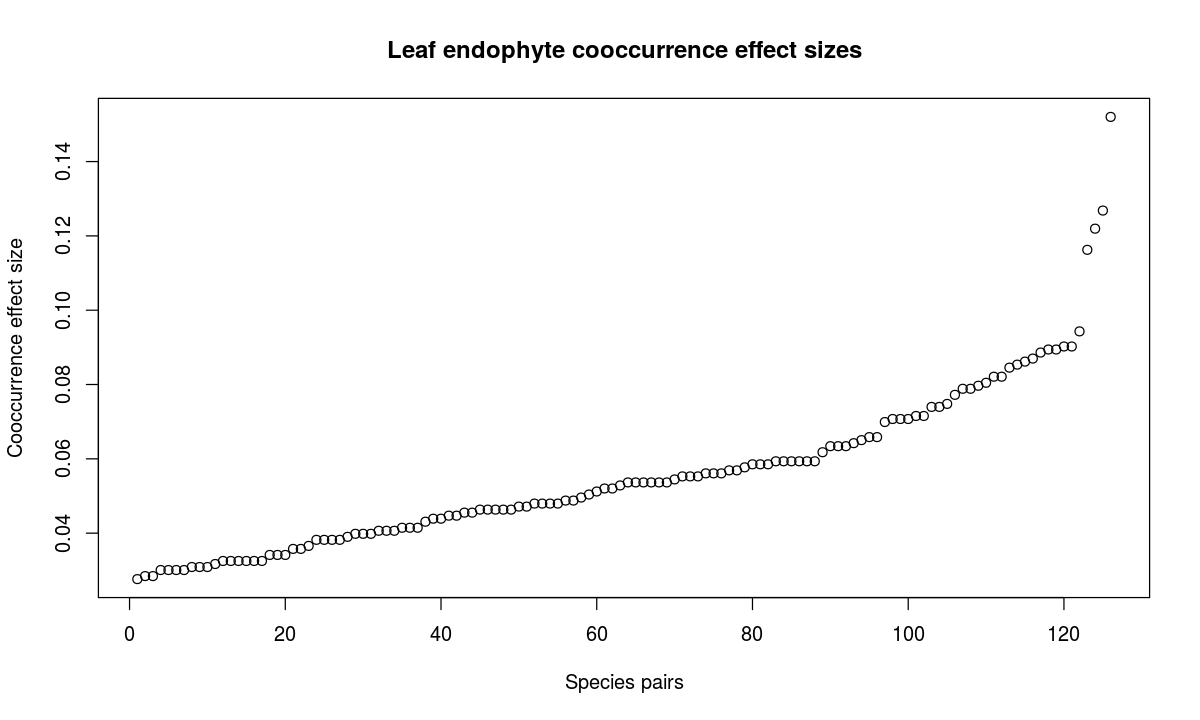

In [68]:
plot(sort(strong_leafcooc$effect),
     xlab='Species pairs',
     ylab = 'Cooccurrence effect size',
    main='Leaf endophyte cooccurrence effect sizes')

In [70]:
aa <- strong_leafcooc[,c(10,11,12,13)]
graphcooc_leaf <- graph_from_data_frame(aa, directed=FALSE)

In [71]:
names(V(graphcooc_leaf))

[1] "Blastus_cochinchinensis"             "Helicia_formosana"                  
 [3] "Limlia_uraiana"                      "OTU52:79Leaf"                       
 [5] "OTU63:90Leaf"                        "OTU190:81Leaf"                      
 [7] "OTU1016:15Leaf"                      "OTU72:16Leaf"                       
 [9] "OTU259:105Leaf"                      "OTU135:120Leaf"                     
[11] "OTU65:128Leaf"                       "OTU220:90Leaf"                      
[13] "OTU168:77Leaf"                       "OTU118:81Leaf"                      
[15] "OTU308:90Leaf"                       "OTU95:96Leaf"                       
[17] "OTU70:101Leaf"                       "OTU646:16Leaf"                      
[19] "OTU117:85Leaf"                       "OTU154:85Leaf"                      
[21] "OTU214:50Leaf"                       "OTU2:X_flabelliforme_australia_thai"
[23] "OTU290:130Leaf"                      "OTU75:21Leaf"                       
[25] "OTU226:101Leaf"                      "OTU253:105Leaf"                     
[27] "OTU136:130Leaf"                      "OTU229:81Leaf"                      
[29] "OTU221:103Leaf"                      "OTU88:4Leaf"                        
[31] "OTU60:93Leaf"                        "OTU365:120Leaf"                     
[33] "OTU93:51Leaf"                        "OTU4015:70Leaf"                     
[35] "OTU194:69Leaf"                       "OTU119:51Leaf"                      
[37] "OTU348:51Leaf"                       "OTU115:81Leaf"                      
[39] "OTU203:23Leaf"                       "OTU66:25Leaf"                       
[41] "OTU59:96Leaf"                        "OTU58:92Leaf"                       
[43] "OTU133:116Leaf"                      "OTU5434:100Leaf"                    
[45] "OTU92:117Leaf"                       "OTU281:97Leaf"                      
[47] "OTU134:16Leaf"                       "OTU212:103Leaf"                     
[49] "OTU74:66Leaf"                        "OTU462:30Leaf"                      
[51] "OTU73:69Leaf"                        "OTU114:23Leaf"

In [74]:
vcols <- vector(length = length(V(graphcooc_leaf)))
vcols[] <- 'green'
vcols[which(names(V(graphcooc_leaf)) == "Helicia_formosana")] <- "red"
vcols[which(names(V(graphcooc_leaf)) == "Blastus_cochinchinensis")] <- "purple"
vcols[which(names(V(graphcooc_leaf)) == "Limlia_uraiana")] <- "mediumvioletred"

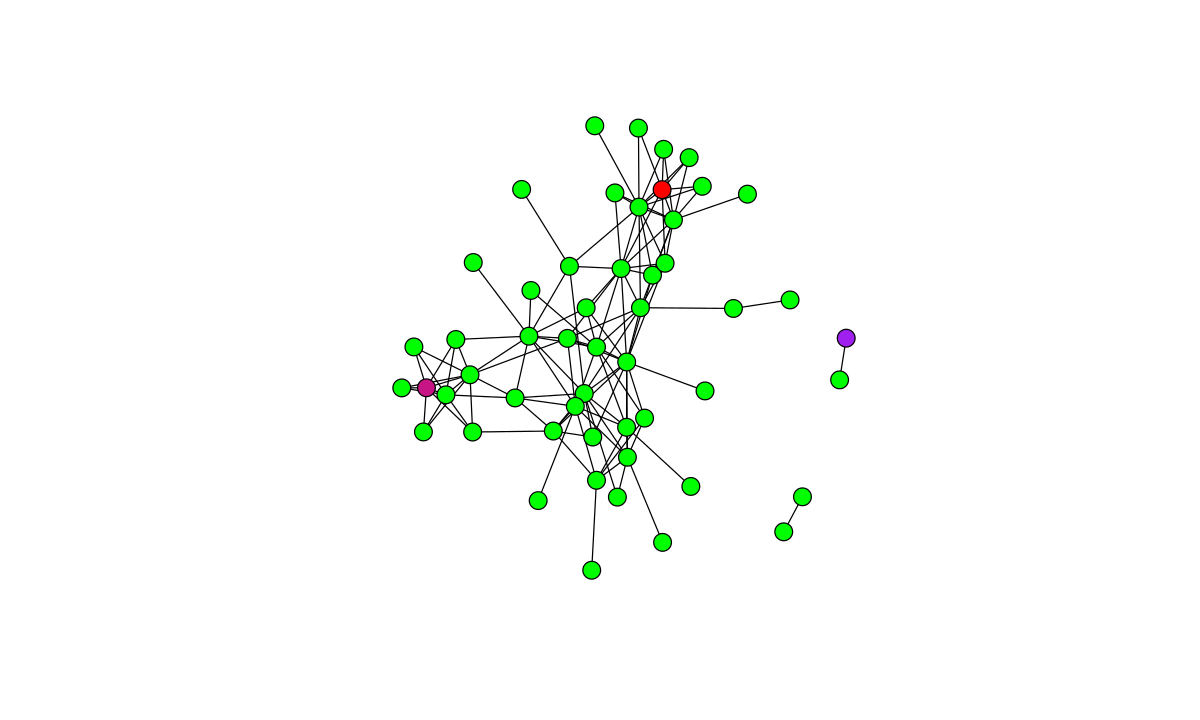

In [76]:
plot(graphcooc_leaf, vertex.color = vcols, vertex.size = 8, vertex.label = NA, edge.color='black')

<a id='sharedcooc'></a>

### Shared species endophyte cooccurrence networks

Let's look at species that were shared among these two illumina libraries, and see if any species emerge as important to explaining the dissimilarity of the communities that we noted [above](#WLNMS).

First we have to do a lot of shuffling around of our otu tables. The goal here is to create two matrices of equal dimensions, the wood and leaf OTU-by-site matrices, pruned to just shared species and sites (samples) that were successful for both wood and leaf sampling. We have to be more careful here than when we built a [combined matrix for NMS visualizion](#shareWvsL), because we build our network edges using a null probability model that in which each OTU/species has an equal chance of occurring in each site. If we have more leaf sites than wood, we may have an unequal variance problem. Not sure, but to be sure, we'll constrain the cooccurrence analysis to sites where both leaves and wood were successfully sampled for endophytes. 

Once we have created these equal dimension matrices, we'll sit them side-by-side, and cap them with rows indicating which samples are wood samples and which are leaf samples. We'll also include tree host info for each. 

In [7]:
## reload our previous data objects
load('shared95.rda') ## from the shared nms above
load('hostmat.rda')

# get our libraries
woodshared95 <- subset_samples(shared95, Library=='W')
leafshared95 <- subset_samples(shared95, Library=='L')

## wood endophyte table
aa <- otu_table(woodshared95)
colnames(aa) <- sample_data(woodshared95)$SampleNumber 
## leaf endophyte table. Columns need to be ordered.
bb <- otu_table(leafshared95)
leafsamp <- sample_data(leafshared95)$SampleNumber
leafsamp <- gsub("_.","",leafsamp)
colnames(bb) <- leafsamp
## subset to shared samples
aa <- aa[,colnames(aa) %in% colnames(bb)] 
bb <- bb[,colnames(bb) %in% colnames(aa)]
bb <- bb[,order(as.numeric(colnames(bb)))] ## order leaf columns
cc <- hostmat ## add host data
cc <- cc[,colnames(cc) %in% colnames(aa)]
aa <- rbind(cc, aa)
bb <- rbind(cc, bb)
## keep column names unique
colnames(aa) <- paste(colnames(aa), 'W', sep='') 
colnames(bb) <- paste(colnames(bb), 'L', sep='')
## sit them side-by-side
dd <- cbind(aa,bb)
## add tissue (wood vs. leaf) rows
woodPA <- vector(length=156)
woodPA[1:78] <- 1
woodPA[79:156] <- 0
leafPA <- vector(length=156)
leafPA[1:78] <- 0
leafPA[79:156] <- 1
## cap our grand matrix off with this info
WLcoocmat <- rbind(woodPA, leafPA, dd)
colnames(WLcoocmat) <- colnames(dd)
WLcoocmat[WLcoocmat > 0] <- 1 ## P/A

Looks like this:

In [11]:
WLcoocmat[32:41,75:85]

,129W,130W,131W,133W,1L,2L,3L,4L,5L,9L,13L
Randia_cochinchinensis,0,0,0,0,0,0,0,0,0,0,0
Schefflera_octophylla,0,0,0,0,0,0,0,0,0,0,0
Symplocos_glauca,0,0,0,0,0,0,0,0,0,0,0
Symplocos_theophrastifolia,0,0,0,0,0,0,0,0,0,0,0
Tricalysia_dubia,0,0,0,0,0,0,0,0,0,0,0
OTU297:14Leaf,0,0,0,0,0,0,0,0,0,0,0
OTU52:79Leaf,0,0,0,0,1,0,0,1,0,0,0
OTU271:163wood,0,0,0,0,0,0,0,0,0,0,0
OTU466:192wood,0,0,0,0,0,0,0,0,0,0,0
OTU81:81Leaf,1,0,1,0,0,0,0,0,0,0,0


In [13]:
#save(WLcoocmat, file='WLcoocmat.rda')

We can feed this to cooccur:

In [14]:
WLcooc <- cooccur(WLcoocmat, spp_names=TRUE)
#save(WLcooc, file = 'WLcooc.rda')

In [16]:
#load('WLcooc.rda')

Then run this cooccurrence object through the same visualization pipeline as [above](#makenet).

In [17]:
WLcoocP <- prob.table(WLcooc)
WLcoocC <- effect.sizes(WLcooc)
WLcoocPC <- cbind(WLcoocP, WLcoocC)
WLcoocPC <- WLcoocPC[,-c(10,11)]
WLcoocPC$p_gt_adj <- p.adjust(WLcoocPC$p_gt, method = "BH")
strong_WLcooc <- WLcoocPC[WLcoocPC$p_gt_adj <= 0.05,]
colnames(strong_WLcooc)[10:11] <- c('OTU_A','OTU_B')
aa <- strong_WLcooc[,c(10,11,12,13)]
graphcooc_WL <- graph_from_data_frame(aa, directed=FALSE)

Warning message in prob.table(WLcooc):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”

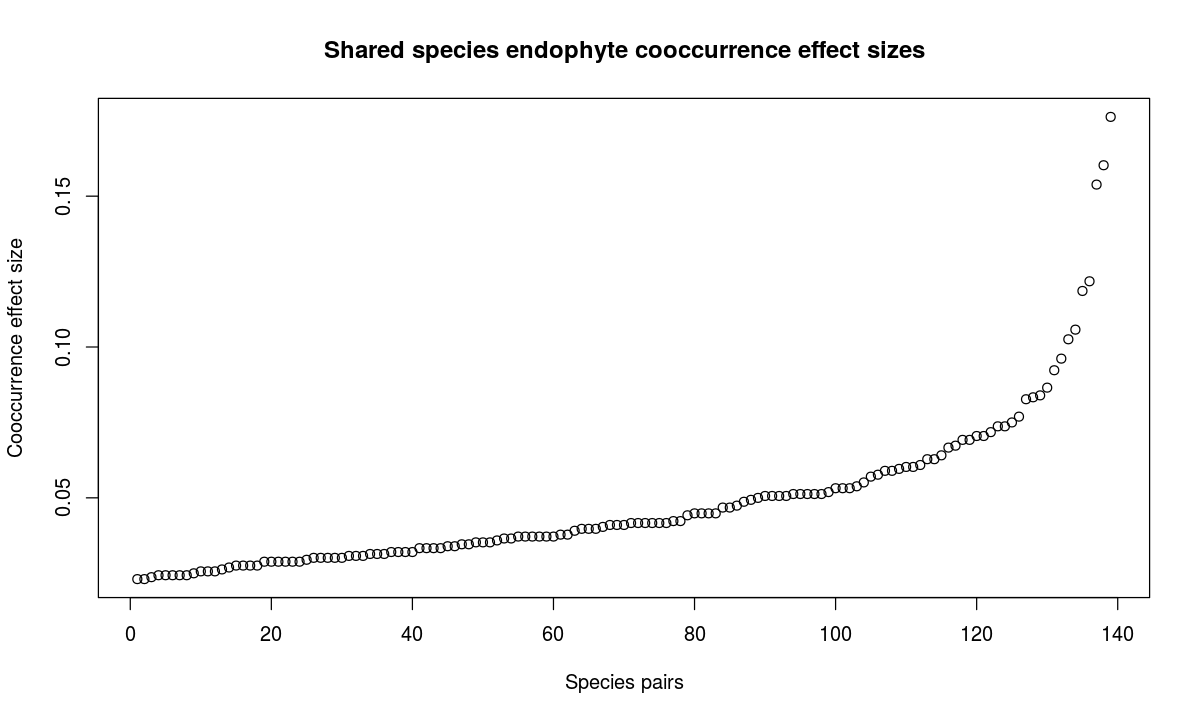

In [23]:
options(repr.plot.width = 10,repr.plot.height = 6)
plot(sort(strong_WLcooc$effect),
     xlab='Species pairs',
     ylab = 'Cooccurrence effect size',
    main='Shared species endophyte cooccurrence effect sizes')

In [21]:
vcols <- vector(length = length(V(graphcooc_WL)))
vcols[] <- 'blue'
vcols[which(names(V(graphcooc_WL)) == "woodPA")] <- "brown"
vcols[which(names(V(graphcooc_WL)) == "leafPA")] <- "green"
vcols[which(names(V(graphcooc_WL)) == "Helicia_formosana")] <- "red"

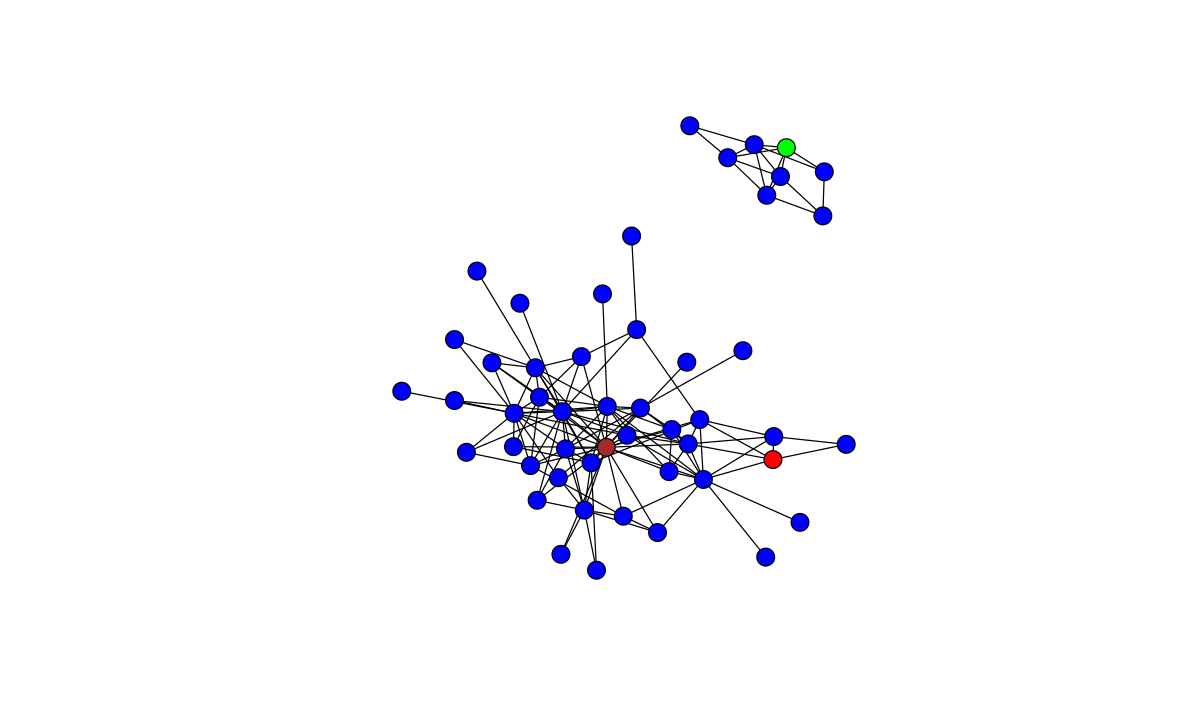

In [22]:
plot(graphcooc_WL, 
     vertex.color = vcols, 
     vertex.size = 8, 
     vertex.label = NA, 
     edge.color='black')

Wow, it looks like there is pretty different cast of fungi associated with wood compared to those that associate with leaves. At this fdr, there aren't really any shared strong cooccurrence relationships between the wood and leaves, though I'm not sure if I could pick these up with my method. I should have been able to see at least "bridge" species, two or more degrees away from the wood and leaf designations. This reinforces the dissimilarity that we saw in the NMS plots of shared species above. 

In [24]:
ls()

[1] "aa"            "bb"            "cc"            "dd"           
 [5] "graphcooc_WL"  "hostmat"       "leafPA"        "leafsamp"     
 [9] "leafshared95"  "shared95"      "strong_WLcooc" "vcols"        
[13] "WLcooc"        "WLcoocC"       "WLcoocmat"     "WLcoocP"      
[17] "WLcoocPC"      "woodPA"        "woodshared95"

<a id='spatial'></a>

# Spatial analysis

We need to examine the patterns we are seeing in a spatially explicit context, for two reasons: 

(1) Examining spatial patterns gives us greater precision when looking at our ecological data, all ecological observations are spatial observations, whether we want to admit it or not. With spatially explicit data we can examine the effects of various types of autocorrelation. Autocorrelation can give the impression of ecological significance to patterns that is really just the result of comparing observations be made close together in space with those that are far apart. And we can look for trends that are not explained by any of the environmental variables that we thought to measure but are obvious when we look at a map. 

(2) We will need a solid model of the spatial trends in our data to build a larger model of environmental predictors, "neutral"/spatial effects, and biological interactions, [below](#).

<a id='mantel'></a>

## Mantel tests

Our first look at the spatial trends in our data will be using a mantel test ([original literature here](#http://cancerres.aacrjournals.org/content/27/2_Part_1/209.long), but check out Legendre et al. for a better explanation). Mantel tests are crude, but can be a good first summary. When used in ecology to look at autocorrelation, mantel tests look to see how strongly dissimilarities of community composition (using a dissimilarity index like Bray-Curtis) coincides with physical distance between the sites between which each comparison is being made. This correlation is called Mantel's r. They are visualized by binning the comparisons into physical distance classes and showing the local angle of this correlation. 

In [8]:
## get our biom tables, variance stabilized, in phyloseq-object form
load('deseq95.rda')
load('shared95.rda')

We'll use the [ecodist mantel/correlogram functions](#https://cran.r-project.org/web/packages/ecodist/ecodist.pdf) rather than vegan [mantel()](#http://cc.oulu.fi/~jarioksa/softhelp/vegan/html/mantel.html) and [mantel.correlog()](#http://cc.oulu.fi/~jarioksa/softhelp/vegan/html/mantel.correlog.html) functions, because they are able to examine the possibility of negative autocorrelation. There exists the possibility that communities at a given distance apart become more similar than we would expect by chance, we will include a two-tailed hypothesis test here that allows for either departure from spatial randomness. As far as I can tell, the vegan functions only test for positive autocorrelation, the idea that communities will become more similar with proximity, and that community similarity will decay with distance.  

In [9]:
## wood endophytes
wood95 <- subset_samples(deseq95, Library=="W") ## subset biom to wood
## make our community distance matrix
aa <-t(otu_table(wood95))
aa[aa > 0] <- 1 ## P/A
wood_comdist <- vegdist(aa, method = "bray") 
## make our physical distance matrix
cc <- as.matrix(sample_data(wood95)[,c('X','Y')]) 
class(cc) <- "numeric"
physdist <- vegdist(cc, method = "euclidean")
woodmgram <- mgram(wood_comdist, physdist) ## correlogram object
wood_mant_test <- ecodist::mantel(wood_comdist ~ physdist, nperm = 10000) ## overall test

Warning message in as.matrix.data.frame(sample_data(wood95)[, c("X", "Y")]):
“Setting class(x) to NULL;   result will no longer be an S4 object”

On the spatial scale that we have looked at, with a Mantel test, do we detect a clear, overall spatial structure to our data?

In [10]:
wood_mant_test

mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.06823056 0.03100000 0.96910000 0.05500000 0.03367013 0.10015949

The mantelr is the global Mantel's r for this set of comparisons. It is weakly positive, indicating an overall trend of positive spatial autocorrelation in the wood endophyte communities. The first and second p-values correspond to one-tailed hypotheses of positive and negative autocorrelation, the middle is the two-tailed p-value.  

Repeat this with our leaf endophytes, and the entire community of shared endophytes. See the above code comments for explanation of code. 

In [11]:
## leaf endophytes
leaf95 <- subset_samples(deseq95, Library=="L") 
aa <-t(otu_table(leaf95))
aa[aa > 0] <- 1 
leaf_comdist <- vegdist(aa, method = "bray")
cc <- as.matrix(sample_data(leaf95)[,c('X','Y')])
class(cc) <- "numeric"
physdist <- vegdist(cc, method = "euclidean")
leafmgram <- mgram(leaf_comdist, physdist)
leaf_mant_test <- ecodist::mantel(leaf_comdist ~ physdist, nperm = 10000)

Warning message in as.matrix.data.frame(sample_data(leaf95)[, c("X", "Y")]):
“Setting class(x) to NULL;   result will no longer be an S4 object”

In [12]:
leaf_mant_test

mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
-0.01238695  0.67050000  0.32960000  0.65320000 -0.03983808  0.01592865

In the leaves we see no strong global correlation. Similarly in the shared community of wood and leaf endophytes:

In [13]:
## shared endophytes
aa <-t(otu_table(shared95))
aa[aa > 0] <- 1 ## P/A
shared_comdist <- vegdist(aa, method = "bray")
cc <- as.matrix(sample_data(shared95)[,c('X','Y')])
class(cc) <- "numeric"
physdist <- vegdist(cc, method = "euclidean")
sharedmgram <- mgram(shared_comdist, physdist)
shared_mant_test <- ecodist::mantel(shared_comdist ~ physdist, nperm = 10000)

Warning message in as.matrix.data.frame(sample_data(shared95)[, c("X", "Y")]):
“Setting class(x) to NULL;   result will no longer be an S4 object”

In [14]:
shared_mant_test

mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
-0.004783255  0.625600000  0.374500000  0.748100000 -0.017909175  0.008662840

Does this mean that there are not spatial trends in our leaf endophytes? Not necessarily. A mantel test like this is very underpowered for complex spatial trends, as it is trying to fit a single, simple correlation coefficient through all of the comparisons of observations in our study. There are many problems with this (see [here](#http://onlinelibrary.wiley.com/doi/10.1111/2041-210X.12425/full)), especially when dealing with non-linear patterns in differences among communities. But no statistical model is perfect. We can look a little deeper into our data using mantel correlograms, before moving onto to more powerful methods (but also not perfect) other than dissimilarity-matrix-based methods like mantel tests. Mantel correlograms break down the comparisons a little, and give more local estimates of correlations between distance and community similarity:

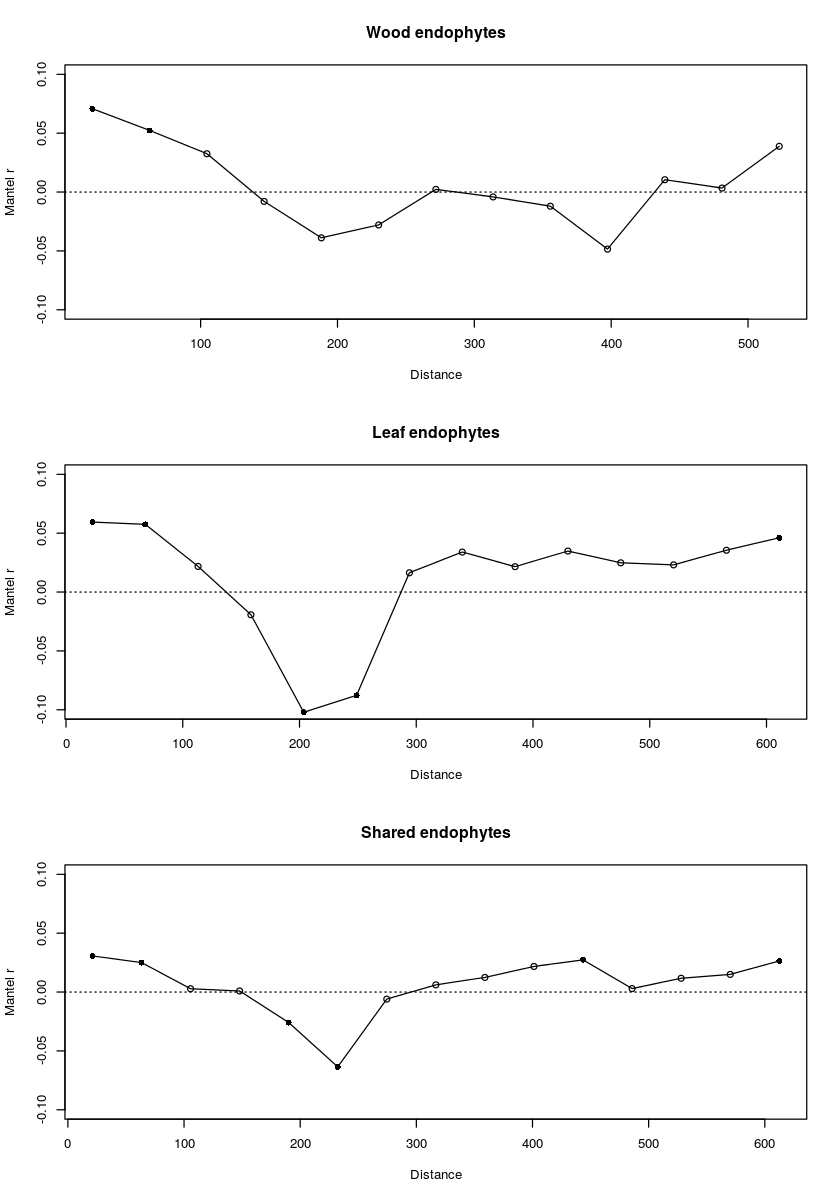

In [15]:
options(repr.plot.height = 10)
par(mfrow=c(3,1))
plot(woodmgram, 
        main="Wood endophytes",
        ylim=c(-.10,.10))
abline(h=0,lty=3)
plot(leafmgram, 
        main="Leaf endophytes",
        ylim=c(-.10,.10))
abline(h=0,lty=3)
plot(sharedmgram,
        main="Shared endophytes",
        ylim=c(-.10,.10))
abline(h=0,lty=3)
par(mfrow=c(1,1))

Here we begin to see an interesting story. The wood endophytes and leaf endophytes show a classic pattern of autocorrelation at close distances. In an environmentally homogenous plot, with enough distances sampled, this pattern often disappears (mantel's r goes to zero and remains). In our leaf samples, however, we see negative autocorrelation around 200 meters. This means that many samples that are ~200 m apart appear to be more similar than we would expect by chance. Presumably it is these leaf endophytes that are driving a similar trend in the shared species. We don't detect this negative autocorrelation in the wood endophytes, they display a more classic distance decay relationship, hovering around zero after some distance. 

<a id='dbmem'></a>

## Distance-Based MEM 

To gain a little precision with our spatial analysis, we'll use distance-based Moran's eigenvector maps, check out explanations [here](#http://www.sciencedirect.com/science/article/pii/S0304380006000925) and [here](#https://sites.google.com/site/mb3gustame/spatial-analysis/pcnm). It's a fairly complex method, with some eigen analysis I do not totally understand. As I understand it, we find the collection of eigenfunctions (principle coordinates) that serve as new bases for a modified distance matrix of all of our points. We then check to see which of these also seem useful for describing patterns of variation in our community matrix. Then we visualize the behavior of these principle coordinates on the landscape of our study, check to see if any of the environmental variables we have seem to also vary with these principle coordinates, and use them as components in statistical models. There are several advantages to this approach, mainly that (1) they stay a lot closer to the actual community matrix and spatial data of the study than dissimilarity approaches (mantel tests, etc): they can be visualized right onto a map of our [study site](#). And, (2), the eigenfunctions are orthogonal and can supposedly be treating like any other variable in a general linear model, etc. One of the main problems with spatially correlated data (which, whether researchers admit it or not, is most data from most ecological studies) is that variables are not independent obervations, and have some level of correlation due to spatial autocorrelation. If we can observe how much other variables are correlated with these purely spatial variables, we can begin to address this error. Finally, (3) they address different spatial scales - they are distinguished from each other by the physical size of their wavelengths. 

Let's make some. In general we are following the methods presented in chapter 7 of Borcard et al.'s [Numerical Ecology with R](http://www.springer.com/us/book/9781441979759).  

<a id='leafdbmem'></a>

### Leaf dbmem analysis

In [17]:
load('deseq95.rda')
leaf95 <- subset_samples(deseq95, Library=="L") ## subset biom to leaf

We need to get the spatial data for all of our leaf samples:

In [18]:
leafxy <- sample_data(leaf95)[,c('X', 'Y')]
rownames(leafxy) <- gsub("_.","",sample_data(leaf95)$SampleNumber)
leafxy <- data.frame(leafxy[order(as.numeric(rownames(leafxy))),])
leafxy$X <- as.numeric(leafxy$X)
leafxy$Y <- as.numeric(leafxy$Y)

In [24]:
leafxy

,X,Y
1,360,220
2,360,221
3,361,221
4,361,220
5,363,220
6,363,223
7,360,223
8,360,227
9,360,235
12,360,347


Make a diagonal matrix of distances between all points, modify it a bit to emphasize nearest neighbors, and create principle components from it:

In [20]:
## make spanning tree, get farthest "nearest neighbor":
ptd <- dist(leafxy)
span.ptd <- spantree(ptd)
dmin <- max(span.ptd$dist) ## 91.92 m
## truncate our distance matrix using this distance.
ptd[ptd > dmin] <- 4*dmin
ptd.PCoA <- cmdscale(ptd, k=nrow(leafxy)-1, eig = TRUE)
nb.ev <- length(which(ptd.PCoA$eig > 0.0000001)) ## keep only the positive eigenvalues
ptd.PCNM <- data.frame(ptd.PCoA$points[1:nrow(leafxy), 1:nb.ev])

Warning message in cmdscale(ptd, k = nrow(leafxy) - 1, eig = TRUE):
“only 75 of the first 122 eigenvalues are > 0”

Okay, we got some pcnms, let's see if any of them are useful, by seeing if they explain any variation in our species matrix with an RDA:

In [25]:
leafcom <- t(otu_table(leaf95)) ## get community matrix out of phyloseq
rownames(leafcom) <- gsub("_.","",sample_data(leaf95)$SampleNumber) ## fix sample names
leafcom <- data.frame(leafcom[order(as.numeric(rownames(leafcom))),]) ## order 
leafcom[leafcom > 0] <- 1 ## P/A
leafcom.hel <- decostand(leafcom,'hellinger') ## transform
leaf.pcnm.rda <- rda(leafcom.hel, ptd.PCNM) ## rda of our leaf community by the PCNMs
leaf.pcnm.sigtest <- anova.cca(leaf.pcnm.rda) ## significance test 

In [26]:
leaf.pcnm.sigtest

,Df,Variance,F,Pr(>F)
Model,36,0.2806264,1.09933,0.001
Residual,86,0.6098127,NA,NA


There are lot of these PCNMs:

In [27]:
head(ptd.PCNM)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36
-12.24390,-16.40882,192.3169,132.6053,-63.30822,6.643841,38.55102,13.856463,45.68720,-9.285076,⋯,1.338540,0.02512096,-0.08749394,-1.614784,-0.05943037,-0.4807450,-0.039814419,1.0041332,-0.008677632,0.0059164909
-12.24272,-16.40939,192.3333,132.6180,-63.31489,6.645941,38.43778,13.826450,45.59288,-9.277983,⋯,1.493526,0.03099111,-0.08574080,-1.754954,-0.07293468,0.3706694,-0.001674269,1.1295285,-0.014071577,0.0000207561
-12.24178,-16.41082,192.3569,132.6372,-63.32377,6.633360,38.27449,13.769214,45.47777,-9.313050,⋯,1.794871,0.02686544,-0.09419784,-1.927929,-0.06762097,-0.1497574,-0.021033100,1.0706720,-0.012253169,0.0024419644
-12.24296,-16.41026,192.3404,132.6244,-63.31710,6.631260,38.38773,13.799227,45.57208,-9.320143,⋯,1.639885,0.02099529,-0.09595098,-1.787759,-0.05411667,-1.0011718,-0.059173250,0.9452767,-0.006859224,0.0083376991
-11.79384,-15.69972,189.6346,130.7484,-62.45369,10.247207,-15.57217,-3.092479,-11.20009,23.496806,⋯,-3.974415,-0.02898175,0.06989570,3.007039,0.08025067,-2.3986340,-0.140282092,-0.8895464,0.027550511,0.0263241466
-11.79146,-15.70329,189.6854,130.7873,-62.47368,10.239083,-15.72366,-3.124420,-11.28586,23.401842,⋯,-3.488050,-0.01112854,0.07476702,2.568579,0.03940487,0.1570197,-0.025534812,-0.5075401,0.011318488,0.0085600305


How we know which of these are important the RDA? We can do some sort of model reduction, to find the important terms in the rda model. We'll use [ordistep()](#) to select the PCNMs to retain:

In [29]:
mod0 <- rda(leafcom.hel ~ 1, ptd.PCNM)
mod1 <- rda(leafcom.hel ~ ., ptd.PCNM)

step.res <- ordiR2step(mod0, mod1, perm.max = 1000)

Step: R2.adj= 0 
Call: leafcom.hel ~ 1 
 
                  R2.adjusted
<All variables>  2.847583e-02
+ X5             7.912184e-03
+ X3             5.366378e-03
+ X2             4.926537e-03
+ X29            3.535103e-03
+ X4             3.460082e-03
+ X25            2.173058e-03
+ X35            1.779265e-03
+ X22            1.711344e-03
+ X11            1.581638e-03
+ X7             1.023758e-03
+ X1             9.791717e-04
+ X26            7.919511e-04
+ X28            4.077155e-04
+ X20            2.558579e-04
+ X32            1.510908e-04
+ X31            1.340122e-04
+ X27            6.004508e-05
<none>           0.000000e+00
+ X9            -8.633910e-06
+ X14           -8.978712e-05
+ X16           -2.262360e-04
+ X8            -2.500055e-04
+ X10           -3.276433e-04
+ X21           -4.206645e-04
+ X17           -5.547542e-04
+ X18           -6.676980e-04
+ X6            -6.777623e-04
+ X30           -7.025249e-04
+ X24           -7.619975e-04
+ X19           -9.299538e-0

In [30]:
step.res

Call: rda(formula = leafcom.hel ~ X5 + X3 + X2 + X29 + X4, data =
ptd.PCNM)

              Inertia Proportion Rank
Total         0.89044    1.00000     
Constrained   0.05875    0.06598    5
Unconstrained 0.83169    0.93402  117
Inertia is variance 

Eigenvalues for constrained axes:
    RDA1     RDA2     RDA3     RDA4     RDA5 
0.019969 0.013363 0.009999 0.008372 0.007046 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8 
0.04049 0.03494 0.02673 0.02507 0.02436 0.02077 0.01995 0.01812 
(Showed only 8 of all 117 unconstrained eigenvalues)


In [31]:
step.res$anova

,R2.adj,Df,AIC,F,Pr(>F)
+ X5,0.007912184,1,-13.26649,1.972985,0.002
+ X3,0.013389216,1,-12.96818,1.671715,0.002
+ X2,0.018511067,1,-12.63767,1.626214,0.004
+ X29,0.022292919,1,-12.15051,1.460302,0.002
+ X4,0.026061832,1,-11.67239,1.456632,0.004
<All variables>,0.028475832,NA,NA,NA,NA


That's a pretty low amount of variance explained, but its part of the story.

So we keep five of these PCNMs as important to describing changes in our fungal community with space: X2,X3,X4,X5,X29. 

In [32]:
sigPCNM <- attributes(step.res$terms)$term.labels
sigPCNM <- sigPCNM[c(3,2,5,1,4)]
leafPCNM <- ptd.PCNM[,sigPCNM]

In [33]:
head(leafPCNM)

X2,X3,X4,X5,X29
-16.40882,192.3169,132.6053,-63.30822,-0.08749394
-16.40939,192.3333,132.6180,-63.31489,-0.08574080
-16.41082,192.3569,132.6372,-63.32377,-0.09419784
-16.41026,192.3404,132.6244,-63.31710,-0.09595098
-15.69972,189.6346,130.7484,-62.45369,0.06989570
-15.70329,189.6854,130.7873,-62.47368,0.07476702


How much variance in our community matrix is explained by just these five PCNMs?

In [34]:
leaf.pcnm.rda2 <- rda(leafcom.hel ~ ., leafPCNM)
leaf.pcnm.rda2

anova.cca(leaf.pcnm.rda2)

Call: rda(formula = leafcom.hel ~ X2 + X3 + X4 + X5 + X29, data =
leafPCNM)

              Inertia Proportion Rank
Total         0.89044    1.00000     
Constrained   0.05875    0.06598    5
Unconstrained 0.83169    0.93402  117
Inertia is variance 

Eigenvalues for constrained axes:
    RDA1     RDA2     RDA3     RDA4     RDA5 
0.019969 0.013363 0.009999 0.008372 0.007046 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8 
0.04049 0.03494 0.02673 0.02507 0.02436 0.02077 0.01995 0.01812 
(Showed only 8 of all 117 unconstrained eigenvalues)


,Df,Variance,F,Pr(>F)
Model,5,0.0587488,1.652925,0.001
Residual,117,0.8316903,NA,NA


5%-6% of the variance is at least partially explained by these patterns of spatial variation. Considering the limited scale of the study, this is pretty interesting. How can we visualize this? 

First we check to see if there are some useful axes to visualize this variation that is redundant in both our community matrix and our PCNMs. The we can use these to build a biplot of the PCNMs. 

In [35]:
axes.test <- anova.cca(leaf.pcnm.rda2, by='axis') ## takes a minute

In [36]:
axes.test

,Df,Variance,F,Pr(>F)
RDA1,1,0.019968609,2.8091312,0.001
RDA2,1,0.013363045,1.8798778,0.001
RDA3,1,0.009998603,1.4065771,0.007
RDA4,1,0.008372122,1.1777680,0.072
RDA5,1,0.007046418,0.9912714,0.511
Residual,117,0.831690326,NA,NA


So we have at least three axes that can be used to visualize these PCNMs and their importance. Vegan's plotter takes the two most important, I think:

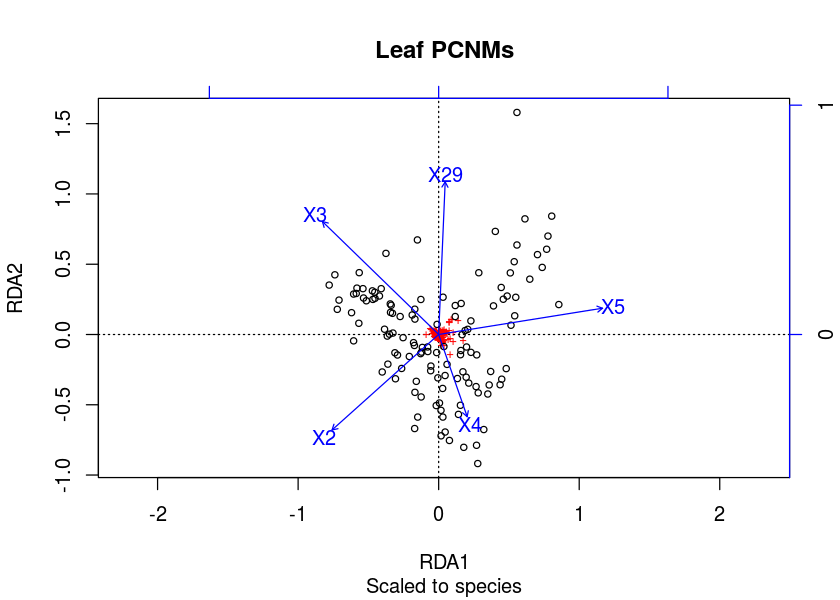

In [39]:
options(repr.plot.height = 5)
plot(leaf.pcnm.rda2, 
        display = c('sp','wa','bp'),
        scaling = 2,
        sub='Scaled to species',
        main='Leaf PCNMs'
)

Black circles are species, red plus-es are sites (scaled to species, so these aren't that useful). A some info on how to read these is [here](#https://sites.google.com/site/mb3gustame/constrained-analyses/rda), also the [R help file](#http://cc.oulu.fi/~jarioksa/softhelp/vegan/html/plot.cca.html). Crudely, I believe that a given species will most explained by an axis that it is far along, and close to. So each of these arrows is a particular scale that a species can seem to be changing along. X4 and X3 both seem to be directly affecting a lot of species, though very different species. The combination of X5 and X29 seems to explain some variation a lot of species. Etc. So for this to be really meaningful, we have to get an idea of what these spatial scales are...

There is a useful function, s.value() in the [ade4 package](https://cran.r-project.org/web/packages/ade4/ade4.pdf) that visualizes third ("z" variables in an x-y coordinate space. We'll use a modified version of this, sr.value() [source code available here](http://adn.biol.umontreal.ca/~numericalecology/numecolR/). 

In [41]:
source('/home/daniel/Documents/Taiwan_data/leaves/spatial/sr.value.R')

Bring in a raster of our sample site, and make a function to look at these pcnms in "real" space. 

<a id='mapP'><a>

In [79]:
mapP <- function(PCNM, P, bkg){
        require('png')
        topo <- readPNG(bkg) ## load scanned image of Fushan Map
        plot(1, type='n', 
                xlim=c(0,500), 
                ylim=c(0,500),
                xlab = '',
                ylab = '',
        main = paste('PCNM',colnames(PCNM)[P], sep = ' ')
        ) ##blank plot
        rasterImage(topo,0,0,500,500)
        sr.value(dfxy=leafxy, z=PCNM[,P], add.plot = TRUE)
}


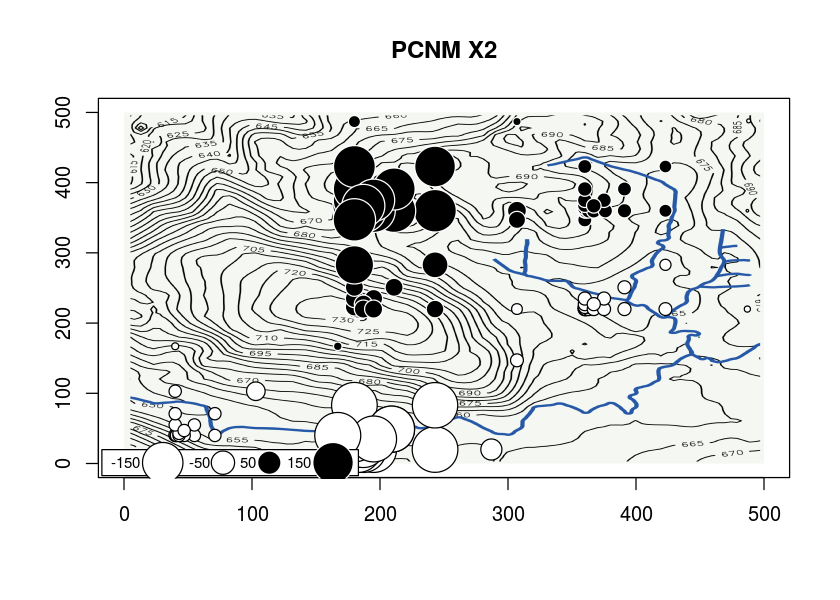

In [80]:
options(repr.plot.height = 5)
mapP(leafPCNM,1,'topo.png')

We can look at all of our 5 leaf PCNMs:

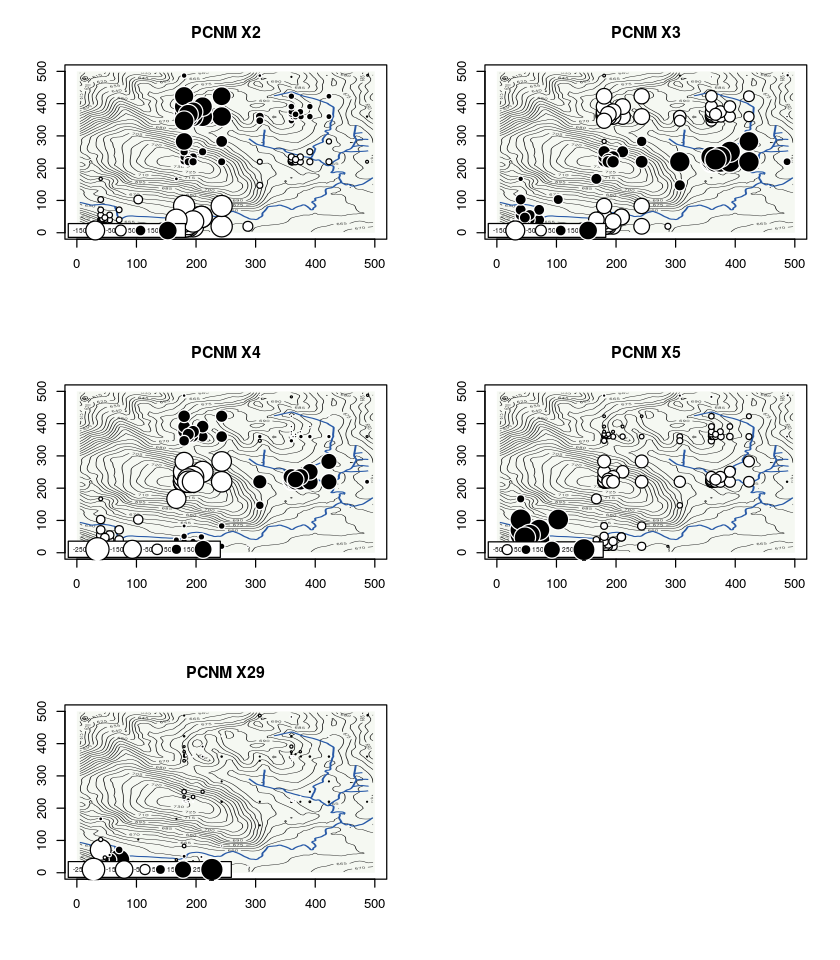

In [81]:
options(repr.plot.height = 8)
par(mfrow=c(3,2))
for (i in 1:5){mapP(leafPCNM,i,'topo.png')}
par(mfrow=c(1,1))

So what are these? We can sort of understand these as the different scales at which spatial correlation can occur. Circles of the same color and same size are expected to be similar to each other, on some level. Some amount of variation in our matrix has been shown to behave similarly to the spatial pattern described by each of these. 

X4 appears to be a mountain vs. valley habitat wavelength. X5 looks site specific, possibly showing local specialization of habitat. X2 looks like a general north-south trend, but perhaps caught up on the habitat pocket in the northwest valley. X3 is mystery to me, maybe one of our measured environmental variables will vary with this. X29 can probably be interpreted as a measure of autocorrelation, showing the smallest scale at which things seem to be different due to unmeasured environmental variability, this often is assumed to be the case with the [smallest PCNM](#). But let's see, do any of the measured environmental variables seem to be varying with with these PCNMs?

First we need to make a leaf environmental variable matrix. We really only have two environmental variables, see note [above](#otherperms). And as usual, with the leaf data from our phyloseq object, we need to do some ordering and rearranging:

In [69]:
leaf.env <- sample_data(leaf95)[,c('Forest_Type', 'vegcom')] ## fix weird rownames and order:
        rownames(leaf.env) <- gsub("_.","",sample_data(leaf95)$SampleNumber)
        leaf.env <- data.frame(leaf.env[order(as.numeric(rownames(leaf.env))),])
        leaf.env$Forest_Type <- as.factor(leaf.env$Forest_Type)
        leaf.env$vegcom <- as.factor(leaf.env$vegcom)


all(rownames(leaf.env) == rownames(leafPCNM)) ## check order of rows match

[1] TRUE

Since we are going to check each of these leaf PCNMs individually for correlations with these vegetation community and topographical variables, we are dealing with single vectors as the reponse side of our models (as opposed to matrices). So we can get back to good old fashioned linear models:

In [70]:
leafPCNM.X2 <- lm(leafPCNM[,1] ~ ., data=leaf.env)
leafPCNM.X3 <- lm(leafPCNM[,2] ~ ., data=leaf.env)
leafPCNM.X4 <- lm(leafPCNM[,3] ~ ., data=leaf.env)
leafPCNM.X5 <- lm(leafPCNM[,4] ~ ., data=leaf.env)
leafPCNM.X29 <- lm(leafPCNM[,5] ~ ., data=leaf.env)

And how do these look?

In [71]:
summary(leafPCNM.X2)


Call:
lm(formula = leafPCNM[, 1] ~ ., data = leaf.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-308.406   -9.379   11.084   50.644  235.048 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)    29.944     63.195   0.474   0.6365  
Forest_Type2    1.679     68.985   0.024   0.9806  
Forest_Type3  -76.286     76.038  -1.003   0.3179  
Forest_Type4  -92.815     98.314  -0.944   0.3471  
Forest_Type5  -20.563    101.434  -0.203   0.8397  
Forest_Type6  -18.243     95.289  -0.191   0.8485  
Forest_Type7 -158.496     93.725  -1.691   0.0936 .
vegcom2       103.563     68.904   1.503   0.1356  
vegcom3        58.325     69.061   0.845   0.4001  
vegcom4        50.758     93.826   0.541   0.5896  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 89.37 on 113 degrees of freedom
Multiple R-squared:  0.334,	Adjusted R-squared:  0.2809 
F-statistic: 6.295 on 9 and 113 DF,  p-value: 3.472e-07


In [72]:
summary(leafPCNM.X3)


Call:
lm(formula = leafPCNM[, 2] ~ ., data = leaf.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-139.293  -84.381    0.024   58.465  163.639 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    66.020     63.465   1.040    0.300
Forest_Type2   -8.471     69.280  -0.122    0.903
Forest_Type3  -24.829     76.363  -0.325    0.746
Forest_Type4   66.397     98.734   0.672    0.503
Forest_Type5  -60.173    101.867  -0.591    0.556
Forest_Type6  -76.013     95.696  -0.794    0.429
Forest_Type7   33.133     94.126   0.352    0.725
vegcom2       -70.436     69.198  -1.018    0.311
vegcom3      -112.875     69.356  -1.627    0.106
vegcom4       -16.416     94.226  -0.174    0.862

Residual standard error: 89.75 on 113 degrees of freedom
Multiple R-squared:  0.2679,	Adjusted R-squared:  0.2096 
F-statistic: 4.594 on 9 and 113 DF,  p-value: 3.52e-05


In [74]:
summary(leafPCNM.X4)


Call:
lm(formula = leafPCNM[, 3] ~ ., data = leaf.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-185.357  -40.429   -7.485   32.379  130.766 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -212.413     41.183  -5.158 1.08e-06 ***
Forest_Type2    7.534     44.957   0.168 0.867204    
Forest_Type3  116.776     49.553   2.357 0.020166 *  
Forest_Type4  -57.111     64.070  -0.891 0.374616    
Forest_Type5   59.054     66.103   0.893 0.373558    
Forest_Type6   82.850     62.099   1.334 0.184836    
Forest_Type7   55.425     61.080   0.907 0.366118    
vegcom2       200.383     44.904   4.463 1.93e-05 ***
vegcom3       164.769     45.006   3.661 0.000384 ***
vegcom4       125.789     61.145   2.057 0.041967 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 58.24 on 113 degrees of freedom
Multiple R-squared:  0.6714,	Adjusted R-squared:  0.6452 
F-statistic: 25.65 on 9 and 113 DF,  p-value: < 

In [73]:
summary(leafPCNM.X5)


Call:
lm(formula = leafPCNM[, 4] ~ ., data = leaf.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-156.813  -38.032    0.036   23.493  259.857 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -82.136     54.916  -1.496   0.1375  
Forest_Type2    4.088     59.947   0.068   0.9457  
Forest_Type3   26.852     66.077   0.406   0.6852  
Forest_Type4   87.015     85.434   1.019   0.3106  
Forest_Type5   20.561     88.145   0.233   0.8160  
Forest_Type6   -4.559     82.806  -0.055   0.9562  
Forest_Type7   23.193     81.446   0.285   0.7763  
vegcom2        33.663     59.877   0.562   0.5751  
vegcom3       131.645     60.013   2.194   0.0303 *
vegcom4       192.922     81.534   2.366   0.0197 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 77.66 on 113 degrees of freedom
Multiple R-squared:  0.3796,	Adjusted R-squared:  0.3302 
F-statistic: 7.681 on 9 and 113 DF,  p-value: 9.642e-09


In [77]:
summary(leafPCNM.X29)


Call:
lm(formula = leafPCNM[, 5] ~ ., data = leaf.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.6469  -0.3274  -0.1813   0.3202  22.4760 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    0.3151     2.3223   0.136    0.892
Forest_Type2  -0.3020     2.5351  -0.119    0.905
Forest_Type3  -0.0890     2.7942  -0.032    0.975
Forest_Type4  -0.3599     3.6128  -0.100    0.921
Forest_Type5  -0.7320     3.7275  -0.196    0.845
Forest_Type6  -0.8302     3.5017  -0.237    0.813
Forest_Type7  -0.8161     3.4442  -0.237    0.813
vegcom2        0.7464     2.5321   0.295    0.769
vegcom3       -0.2084     2.5378  -0.082    0.935
vegcom4        1.9315     3.4479   0.560    0.576

Residual standard error: 3.284 on 113 degrees of freedom
Multiple R-squared:  0.02191,	Adjusted R-squared:  -0.05599 
F-statistic: 0.2812 on 9 and 113 DF,  p-value: 0.9787


So the interesting patterns here seem to be that PCNMs X4 and X5 are strongly correlated with our environmental variables. X4 seems to be responding a little to the presence or absence of forest type 3, and seems generally responsive to above ground vegetative community. X5 seems responsive to vegetative community types 3 and 4, the lowland/wetland communities. 

Let's look at X4 and X5 over vegetative community, using our [plotting function](#mapP):

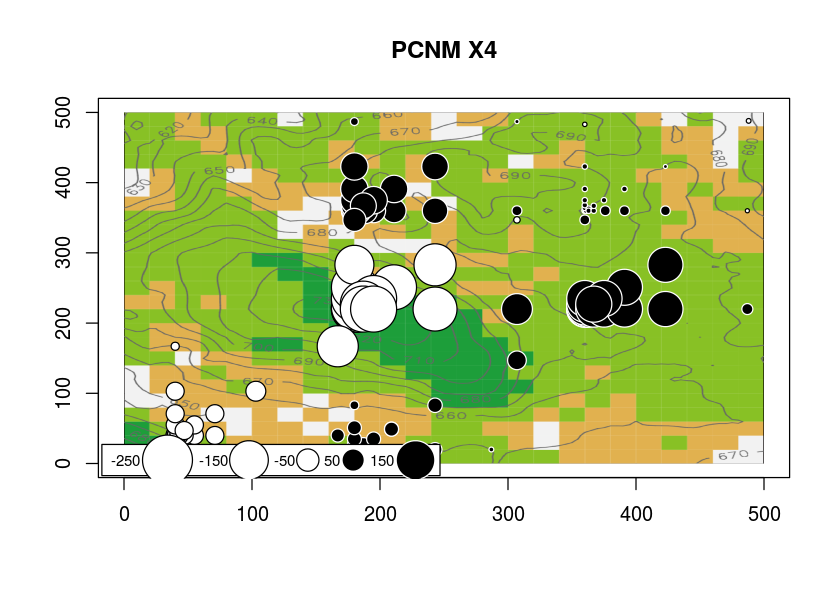

In [83]:
options(repr.plot.height = 5)
mapP(leafPCNM,3,'vegcom.png')

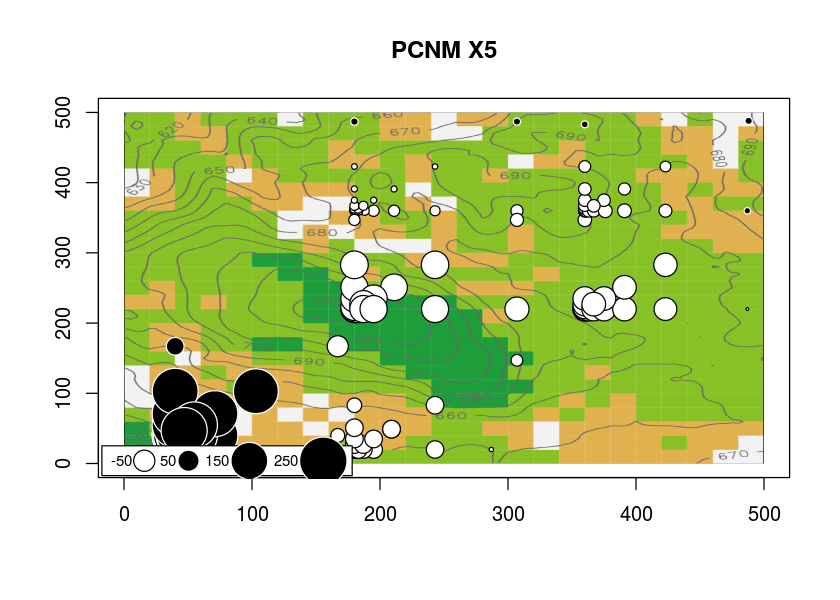

In [84]:
options(repr.plot.height = 5)
mapP(leafPCNM,4,'vegcom.png')